In [1]:
import json
import os
import argparse
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
class SepToken:
    tokens = {'deberta': "[SEP]"}

class Label2num:
    mapping = {'Entailment': 1, "Contradiction": 0}

In [3]:
# define dataset
class Recorddataset(Dataset):
    def __init__(self, args, path, split='train'):
        super(Recorddataset, self).__init__()
        self.args = args
        self.split = split
        self.statement = []
        self.trail1 = []
        self.trail2 = []
        self.label = []
        self.section = []
        self.sep_token_instance = SepToken()
        ctpath = os.path.join(path, "CT json")
        jspath = os.path.join(path, f"{split}.json") if split != 'trn&dev' else os.path.join(path, 'train.json')

        with open(jspath) as file:
            self.data = json.load(file)
            self.uuid_list = list(self.data.keys())

        if split == 'trn&dev':
            with open(os.path.join(path, 'dev.json')) as file:
                self.data = {**self.data, **json.load(file)}
                self.uuid_list = list(self.data.keys())

        for id in self.uuid_list:
            self.statement.append(self.data[id]['Statement'])
            if split != 'test':
                self.label.append(Label2num.mapping[self.data[id]['Label']])

            section = self.data[id]['Section_id']
            self.section.append(section)

            with open(os.path.join(ctpath, f"{self.data[id]['Primary_id']}.json")) as file:
                ct = json.load(file)
                trail1 = ct[section]
                self.trail1.append(self.format_change(trail1))

            if self.data[id]['Type'] == "Comparison":
                with open(os.path.join(ctpath, f"{self.data[id]['Secondary_id']}.json")) as file:
                    ct = json.load(file)
                    trail2 = ct[section]
                    self.trail2.append(self.format_change(trail2))
            else:
                default_sep_token = self.sep_token_instance.tokens.get('_', '')
                self.trail2.append(default_sep_token)

    def __getitem__(self, index):
        sep_token = self.sep_token_instance.tokens.get(self.args.lmn, '')

        if self.trail2[index] == '_':
            sent = f"{self.statement[index]} {sep_token} {self.section[index]} {sep_token} {self.trail1[index]}"
        else:
            sent = f"{self.statement[index]} {sep_token} {self.section[index]} {sep_token} {self.trail1[index]} {sep_token} {self.trail2[index]}"

        if self.split != 'test':
            return sent, torch.tensor(self.label[index])
        else:
            return sent, self.uuid_list[index]

    def __len__(self):
        return len(self.uuid_list)

    def format_change(self, sentence):
        return ",".join(sent.strip() for sent in sentence)

    def get_max_length(self):
        print([len(self.__getitem__(i)[0].split(' ')) for i in range(self.__len__())])
        return max([len(self.__getitem__(i)[0].split(' ')) for i in range(self.__len__())])


In [4]:
class Model(torch.nn.Module):
    def __init__(self, args, model_name, from_check_point=False, tokenizer_dir=None, model_dir=None):
        super(Model, self).__init__()
        assert type(from_check_point) == bool  # Check the datatype

        self.args = args
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
        if from_check_point:
            config = torch.load(model_dir)
            self.model.load_state_dict(config)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True) if from_check_point == False else AutoTokenizer.from_pretrained(tokenizer_dir, do_lower_case=True)

    def forward(self, sent, label, device):
        token = self.tokenizer(sent, padding='max_length', truncation=True, max_length=512, return_tensors="pt").to(device)
        output = self.model(**token, labels=label)
        return output

    def save_model(self, dir):
        self.tokenizer.save_pretrained(dir)
        torch.save(self.model.state_dict(), dir + f"/dev_best_seed{self.args.seed}.pth")


In [5]:
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def eval(model, loader, device, print_on_screen=True):
    prediction = []
    ground_label = []
    total_loss = 0
    with torch.no_grad():
        for id, (sent, label) in enumerate(loader):
            label = label.to(device)
            output = model(sent, label, device)
            total_loss += output[0].item()
            pred = torch.argmax(output[1], dim=-1)
            ground_label.append(label)
            prediction.append(pred)
        prediction = torch.stack(prediction).view(-1).cpu().numpy()
        ground_label = torch.stack(ground_label).view(-1).cpu().numpy()
        f_score = f1_score(ground_label, prediction)
        p_score = precision_score(ground_label, prediction)
        r_score = recall_score(ground_label, prediction)
        if print_on_screen:
            print('F1:{:f}'.format(f_score))
            print('precision_score:{:f}'.format(p_score))
            print('recall_score:{:f}'.format(r_score))
    return total_loss, f_score, p_score, r_score


In [11]:
class Args:
    gpu = 0
    ptlm = 'Microsoft/DeBERTa-v3-base'
    lmn = 'deberta'
    data = '/Hui/R&D/NLI4CT/training_data'
    epoch = 20
    eval_every = 8
    prompt = 2
    mode = 'trn'
    from_check_point = False
    tokenizer_dir = None
    model_dir = None
    seed = 621


# Creating an instance of the Args class
args = Args()

torch.cuda.set_device(args.gpu)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


if args.mode == 'trn':
    trn_dataset = Recorddataset(args, args.data, "train")
else:
    trn_dataset = Recorddataset(args, args.data, "trn&dev")
dev_dataset = Recorddataset(args, args.data, "dev")
tst_dataset = Recorddataset(args, args.data, "test")

trn_loader = DataLoader(trn_dataset, batch_size=4, shuffle=True, drop_last=False)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False, drop_last=True)
tst_loader = DataLoader(tst_dataset, batch_size=4, shuffle=False, drop_last=False)

seed_val = args.seed
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

output_dir = "/Hui/R&D/NLI4CT/training_data/result_base/{}_prompt{}_mode{}_epoch{}_eval{}/".format(args.ptlm, args.prompt, args.mode, args.epoch, args.eval_every)
os.makedirs(output_dir, exist_ok=True)

epochs = args.epoch
num_total_steps = len(trn_loader) * epochs
num_warmup_steps = len(trn_loader) * int(args.epoch / 8)

model = Model(args, args.ptlm, args.from_check_point, args.tokenizer_dir, args.model_dir)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-6, correct_bias=True)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_total_steps)

best_val, best_val_epoch = 0, 0
best_recall, best_precision = 0, 0


for epoch in range(epochs):
    total_loss = 0
    for iter, (sent, label) in enumerate(tqdm(trn_loader, desc=f'epoch: {epoch + 1}/{epochs}')):
        label = label.to(device)
        optimizer.zero_grad()
        output = model(sent, label, device)
        pred = torch.argmax(output[1], dim=-1)
        total_loss += output[0].item()

        output[0].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        if iter % args.eval_every == 0 and iter != 0:
            with torch.no_grad():
                l, f, p, r = eval(model, dev_loader, device, print_on_screen=False)
            print(f"The Validation result at epoch {epoch + 1} iter {iter}: val_loss: {l}, val_f1: {f}, val_precision: {p}, val_recall: {r}")

            if f > best_val:
                best_val_epoch = epoch + 1
                best_val = f
                best_precision = p
                best_recall = r
                model.save_model(output_dir)

    if epoch == best_val_epoch:
        model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for _, (sent, label) in enumerate(tqdm(dev_loader, desc='Evaluating')):
                label = label.to(device)
                output = model(sent, label, device)
                predictions = torch.argmax(output.logits, dim=-1)
                all_labels.extend(label.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())

        # 计算混淆矩阵
        conf_matrix = confusion_matrix(all_labels, all_predictions)

        # 选择样本
        positive_samples = []  # 正类别样本
        negative_samples = []  # 负类别样本
        false_positive_samples = []  # 假正例样本
        false_negative_samples = []  # 假负例样本

        for i in range(len(all_labels)):
            true_label = all_labels[i]
            predicted_label = all_predictions[i]

            # 根据混淆矩阵确定样本类别
            if true_label == 1 and predicted_label == 1:
                positive_samples.append(dev_dataset.__getitem__(i)[0])
            elif true_label == 0 and predicted_label == 0:
                negative_samples.append(dev_dataset.__getitem__(i)[0])
            elif true_label == 0 and predicted_label == 1:
                false_positive_samples.append(dev_dataset.__getitem__(i)[0])
            elif true_label == 1 and predicted_label == 0:
                false_negative_samples.append(dev_dataset.__getitem__(i)[0])

        # Save the samples to a JSON file
        samples_dict = {
            "positive_samples": positive_samples,
            "negative_samples": negative_samples,
            "false_positive_samples": false_positive_samples,
            "false_negative_samples": false_negative_samples
        }

        with open("/Hui/R&D/NLI4CT/training_data/result/samples_base.json", "w") as json_file:
            json.dump(samples_dict, json_file)


print("best_val", best_val, 'best_r', best_recall, 'best_p', best_precision, "best_val_epoch", best_val_epoch)

print("total_loss_per_epoch: ", total_loss, "best_val", best_val, 'best_r', best_recall, 'best_p', best_precision, "best_val_epoch", best_val_epoch)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at Microsoft/DeBERTa-v3-base and are newly initialized: ['classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\transformers\convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of 

The Validation result at epoch 1 iter 8: val_loss: 138.62763142585754, val_f1: 0.3, val_precision: 0.525, val_recall: 0.21


epoch: 1/20:   4%|█████▍                                                                                                                          | 18/425 [00:15<09:45,  1.44s/it]

The Validation result at epoch 1 iter 16: val_loss: 138.62760478258133, val_f1: 0.29577464788732394, val_precision: 0.5, val_recall: 0.21


epoch: 1/20:   6%|███████▏                                                                                                                        | 24/425 [00:16<02:12,  3.02it/s]

The Validation result at epoch 1 iter 24: val_loss: 138.62756031751633, val_f1: 0.3221476510067114, val_precision: 0.4897959183673469, val_recall: 0.24


epoch: 1/20:   8%|█████████▋                                                                                                                      | 32/425 [00:24<02:17,  2.85it/s]

The Validation result at epoch 1 iter 32: val_loss: 138.62753522396088, val_f1: 0.43428571428571433, val_precision: 0.5066666666666667, val_recall: 0.38


epoch: 1/20:   9%|████████████                                                                                                                    | 40/425 [00:32<02:15,  2.84it/s]

The Validation result at epoch 1 iter 40: val_loss: 138.62757396697998, val_f1: 0.455958549222798, val_precision: 0.4731182795698925, val_recall: 0.44


epoch: 1/20:  11%|██████████████▍                                                                                                                 | 48/425 [00:40<02:12,  2.85it/s]

The Validation result at epoch 1 iter 48: val_loss: 138.62763512134552, val_f1: 0.5462962962962962, val_precision: 0.5086206896551724, val_recall: 0.59


epoch: 1/20:  13%|████████████████▊                                                                                                               | 56/425 [00:48<02:10,  2.84it/s]

The Validation result at epoch 1 iter 56: val_loss: 138.6277032494545, val_f1: 0.576271186440678, val_precision: 0.5, val_recall: 0.68


epoch: 1/20:  15%|███████████████████▌                                                                                                            | 65/425 [01:01<12:00,  2.00s/it]

The Validation result at epoch 1 iter 64: val_loss: 138.62765854597092, val_f1: 0.576271186440678, val_precision: 0.5, val_recall: 0.68


epoch: 1/20:  17%|██████████████████████▎                                                                                                         | 74/425 [01:09<08:27,  1.44s/it]

The Validation result at epoch 1 iter 72: val_loss: 138.62762361764908, val_f1: 0.576271186440678, val_precision: 0.5, val_recall: 0.68


epoch: 1/20:  19%|████████████████████████                                                                                                        | 80/425 [01:10<01:55,  2.99it/s]

The Validation result at epoch 1 iter 80: val_loss: 138.62748265266418, val_f1: 0.5775862068965517, val_precision: 0.5075757575757576, val_recall: 0.67


epoch: 1/20:  21%|███████████████████████████                                                                                                     | 90/425 [01:24<08:00,  1.44s/it]

The Validation result at epoch 1 iter 88: val_loss: 138.62718778848648, val_f1: 0.4897959183673469, val_precision: 0.5, val_recall: 0.48


epoch: 1/20:  23%|█████████████████████████████▌                                                                                                  | 98/425 [01:31<07:52,  1.44s/it]

The Validation result at epoch 1 iter 96: val_loss: 138.62710934877396, val_f1: 0.4222222222222222, val_precision: 0.475, val_recall: 0.38


epoch: 1/20:  25%|███████████████████████████████▍                                                                                               | 105/425 [01:38<10:23,  1.95s/it]

The Validation result at epoch 1 iter 104: val_loss: 138.62716215848923, val_f1: 0.5167464114832536, val_precision: 0.4954128440366973, val_recall: 0.54


epoch: 1/20:  26%|█████████████████████████████████▍                                                                                             | 112/425 [01:39<01:43,  3.01it/s]

The Validation result at epoch 1 iter 112: val_loss: 138.62780076265335, val_f1: 0.6268656716417911, val_precision: 0.5, val_recall: 0.84


epoch: 1/20:  28%|███████████████████████████████████▊                                                                                           | 120/425 [01:47<01:47,  2.84it/s]

The Validation result at epoch 1 iter 120: val_loss: 138.6308553814888, val_f1: 0.6574394463667821, val_precision: 0.5026455026455027, val_recall: 0.95


epoch: 1/20:  30%|██████████████████████████████████████▏                                                                                        | 128/425 [01:55<01:45,  2.83it/s]

The Validation result at epoch 1 iter 128: val_loss: 138.63391613960266, val_f1: 0.6621621621621622, val_precision: 0.5, val_recall: 0.98


epoch: 1/20:  32%|████████████████████████████████████████▉                                                                                      | 137/425 [02:08<09:23,  1.96s/it]

The Validation result at epoch 1 iter 136: val_loss: 138.63459157943726, val_f1: 0.6599326599326599, val_precision: 0.49746192893401014, val_recall: 0.98


epoch: 1/20:  34%|███████████████████████████████████████████▋                                                                                   | 146/425 [02:16<06:35,  1.42s/it]

The Validation result at epoch 1 iter 144: val_loss: 138.63438427448273, val_f1: 0.6599326599326599, val_precision: 0.49746192893401014, val_recall: 0.98


epoch: 1/20:  36%|██████████████████████████████████████████████                                                                                 | 154/425 [02:23<06:21,  1.41s/it]

The Validation result at epoch 1 iter 152: val_loss: 138.6334384083748, val_f1: 0.6621621621621622, val_precision: 0.5, val_recall: 0.98


epoch: 1/20:  38%|████████████████████████████████████████████████▍                                                                              | 162/425 [02:30<06:10,  1.41s/it]

The Validation result at epoch 1 iter 160: val_loss: 138.62970942258835, val_f1: 0.6573426573426574, val_precision: 0.5053763440860215, val_recall: 0.94


epoch: 1/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:37<06:00,  1.41s/it]

The Validation result at epoch 1 iter 168: val_loss: 138.62734860181808, val_f1: 0.43333333333333335, val_precision: 0.4875, val_recall: 0.39


epoch: 1/20:  41%|████████████████████████████████████████████████████▌                                                                          | 176/425 [02:38<01:22,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  42%|█████████████████████████████████████████████████████▏                                                                         | 178/425 [02:44<05:48,  1.41s/it]

The Validation result at epoch 1 iter 176: val_loss: 138.63128238916397, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  43%|██████████████████████████████████████████████████████▉                                                                        | 184/425 [02:45<01:20,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  44%|███████████████████████████████████████████████████████▌                                                                       | 186/425 [02:51<05:37,  1.41s/it]

The Validation result at epoch 1 iter 184: val_loss: 138.63600248098373, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  45%|█████████████████████████████████████████████████████████▎                                                                     | 192/425 [02:52<01:17,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:58<05:25,  1.41s/it]

The Validation result at epoch 1 iter 192: val_loss: 138.63827526569366, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  47%|███████████████████████████████████████████████████████████▊                                                                   | 200/425 [02:59<01:15,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  48%|████████████████████████████████████████████████████████████▎                                                                  | 202/425 [03:05<05:15,  1.41s/it]

The Validation result at epoch 1 iter 200: val_loss: 138.64581269025803, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  49%|██████████████████████████████████████████████████████████████▏                                                                | 208/425 [03:06<01:12,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  49%|██████████████████████████████████████████████████████████████▊                                                                | 210/425 [03:12<05:07,  1.43s/it]

The Validation result at epoch 1 iter 208: val_loss: 138.65401446819305, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  51%|████████████████████████████████████████████████████████████████▌                                                              | 216/425 [03:13<01:09,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:19<04:53,  1.42s/it]

The Validation result at epoch 1 iter 216: val_loss: 138.65349411964417, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  53%|██████████████████████████████████████████████████████████████████▉                                                            | 224/425 [03:20<01:06,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:26<04:40,  1.41s/it]

The Validation result at epoch 1 iter 224: val_loss: 138.65068191289902, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                         | 232/425 [03:27<01:04,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 234/425 [03:33<04:29,  1.41s/it]

The Validation result at epoch 1 iter 232: val_loss: 138.64909225702286, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  56%|███████████████████████████████████████████████████████████████████████▋                                                       | 240/425 [03:34<01:01,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 242/425 [03:40<04:26,  1.45s/it]

The Validation result at epoch 1 iter 240: val_loss: 138.64290982484818, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  58%|██████████████████████████████████████████████████████████████████████████                                                     | 248/425 [03:41<00:59,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 250/425 [03:47<04:08,  1.42s/it]

The Validation result at epoch 1 iter 248: val_loss: 138.6438848376274, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 256/425 [03:48<00:56,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 258/425 [03:54<03:56,  1.42s/it]

The Validation result at epoch 1 iter 256: val_loss: 138.65118354558945, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 264/425 [03:55<00:53,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 266/425 [04:01<03:45,  1.42s/it]

The Validation result at epoch 1 iter 264: val_loss: 138.65871465206146, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 272/425 [04:02<00:50,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 274/425 [04:08<03:32,  1.41s/it]

The Validation result at epoch 1 iter 272: val_loss: 138.65473687648773, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 280/425 [04:09<00:48,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 282/425 [04:15<03:21,  1.41s/it]

The Validation result at epoch 1 iter 280: val_loss: 138.65669125318527, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 288/425 [04:16<00:45,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 290/425 [04:22<03:11,  1.42s/it]

The Validation result at epoch 1 iter 288: val_loss: 138.66446721553802, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 296/425 [04:23<00:42,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:29<02:59,  1.41s/it]

The Validation result at epoch 1 iter 296: val_loss: 138.6900572180748, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 304/425 [04:30<00:40,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 306/425 [04:36<02:52,  1.45s/it]

The Validation result at epoch 1 iter 304: val_loss: 138.69576048851013, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 312/425 [04:37<00:37,  2.98it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 314/425 [04:43<02:36,  1.41s/it]

The Validation result at epoch 1 iter 312: val_loss: 138.70275634527206, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 320/425 [04:44<00:34,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 322/425 [04:50<02:26,  1.43s/it]

The Validation result at epoch 1 iter 320: val_loss: 138.70149052143097, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 328/425 [04:51<00:32,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 330/425 [04:57<02:15,  1.42s/it]

The Validation result at epoch 1 iter 328: val_loss: 138.66691786050797, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 336/425 [04:58<00:29,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 338/425 [05:04<02:02,  1.41s/it]

The Validation result at epoch 1 iter 336: val_loss: 138.65378588438034, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 344/425 [05:05<00:27,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 346/425 [05:11<01:52,  1.42s/it]

The Validation result at epoch 1 iter 344: val_loss: 138.6506729722023, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 352/425 [05:12<00:24,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:18<01:42,  1.45s/it]

The Validation result at epoch 1 iter 352: val_loss: 138.6490357518196, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 360/425 [05:19<00:21,  2.97it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 1/20:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 362/425 [05:25<01:28,  1.41s/it]

The Validation result at epoch 1 iter 360: val_loss: 138.64211148023605, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 1/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 370/425 [05:32<01:18,  1.42s/it]

The Validation result at epoch 1 iter 368: val_loss: 138.6322741508484, val_f1: 0.0196078431372549, val_precision: 0.5, val_recall: 0.01


epoch: 1/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 378/425 [05:39<01:05,  1.40s/it]

The Validation result at epoch 1 iter 376: val_loss: 138.6275907754898, val_f1: 0.22047244094488191, val_precision: 0.5185185185185185, val_recall: 0.14


epoch: 1/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 385/425 [05:46<01:19,  1.98s/it]

The Validation result at epoch 1 iter 384: val_loss: 138.62808221578598, val_f1: 0.10714285714285712, val_precision: 0.5, val_recall: 0.06


epoch: 1/20:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 394/425 [05:53<00:43,  1.41s/it]

The Validation result at epoch 1 iter 392: val_loss: 138.62717497348785, val_f1: 0.34838709677419355, val_precision: 0.4909090909090909, val_recall: 0.27


epoch: 1/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [06:00<00:32,  1.41s/it]

The Validation result at epoch 1 iter 400: val_loss: 138.62607592344284, val_f1: 0.45054945054945056, val_precision: 0.5, val_recall: 0.41


epoch: 1/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 409/425 [06:07<00:31,  1.97s/it]

The Validation result at epoch 1 iter 408: val_loss: 138.62603652477264, val_f1: 0.4623655913978495, val_precision: 0.5, val_recall: 0.43


epoch: 1/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 417/425 [06:14<00:15,  1.93s/it]

The Validation result at epoch 1 iter 416: val_loss: 138.62917679548264, val_f1: 0.657243816254417, val_precision: 0.5081967213114754, val_recall: 0.93


epoch: 1/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 424/425 [06:16<00:00,  3.01it/s]

The Validation result at epoch 1 iter 424: val_loss: 138.6424595117569, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:   2%|███                                                                                                                             | 10/425 [00:07<09:45,  1.41s/it]

The Validation result at epoch 2 iter 8: val_loss: 138.6592167019844, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:   4%|█████                                                                                                                           | 17/425 [00:14<13:08,  1.93s/it]

The Validation result at epoch 2 iter 16: val_loss: 138.6772040128708, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:   6%|███████▌                                                                                                                        | 25/425 [00:21<12:54,  1.94s/it]

The Validation result at epoch 2 iter 24: val_loss: 138.69720190763474, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:   8%|█████████▉                                                                                                                      | 33/425 [00:28<12:37,  1.93s/it]

The Validation result at epoch 2 iter 32: val_loss: 138.70924031734467, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  10%|████████████▎                                                                                                                   | 41/425 [00:35<12:23,  1.94s/it]

The Validation result at epoch 2 iter 40: val_loss: 138.69000887870789, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  12%|██████████████▊                                                                                                                 | 49/425 [00:42<12:16,  1.96s/it]

The Validation result at epoch 2 iter 48: val_loss: 138.65521657466888, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  13%|█████████████████▏                                                                                                              | 57/425 [00:49<12:12,  1.99s/it]

The Validation result at epoch 2 iter 56: val_loss: 138.6552992463112, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  16%|███████████████████▉                                                                                                            | 66/425 [00:56<08:30,  1.42s/it]

The Validation result at epoch 2 iter 64: val_loss: 138.6651245355606, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  17%|█████████████████████▉                                                                                                          | 73/425 [01:03<11:40,  1.99s/it]

The Validation result at epoch 2 iter 72: val_loss: 138.66542041301727, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  19%|████████████████████████▍                                                                                                       | 81/425 [01:10<11:05,  1.94s/it]

The Validation result at epoch 2 iter 80: val_loss: 138.65860706567764, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  21%|██████████████████████████▊                                                                                                     | 89/425 [01:17<10:51,  1.94s/it]

The Validation result at epoch 2 iter 88: val_loss: 138.67332768440247, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  23%|█████████████████████████████▌                                                                                                  | 98/425 [01:24<07:42,  1.41s/it]

The Validation result at epoch 2 iter 96: val_loss: 138.68389809131622, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  25%|███████████████████████████████▍                                                                                               | 105/425 [01:31<10:29,  1.97s/it]

The Validation result at epoch 2 iter 104: val_loss: 138.73878872394562, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  27%|██████████████████████████████████                                                                                             | 114/425 [01:39<07:23,  1.43s/it]

The Validation result at epoch 2 iter 112: val_loss: 138.76942145824432, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  29%|████████████████████████████████████▍                                                                                          | 122/425 [01:46<07:23,  1.46s/it]

The Validation result at epoch 2 iter 120: val_loss: 138.7995685338974, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  31%|██████████████████████████████████████▊                                                                                        | 130/425 [01:53<06:59,  1.42s/it]

The Validation result at epoch 2 iter 128: val_loss: 138.7810544371605, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  32%|█████████████████████████████████████████▏                                                                                     | 138/425 [02:00<06:48,  1.42s/it]

The Validation result at epoch 2 iter 136: val_loss: 138.7907071709633, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  34%|███████████████████████████████████████████▋                                                                                   | 146/425 [02:07<06:39,  1.43s/it]

The Validation result at epoch 2 iter 144: val_loss: 138.7577127814293, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  36%|█████████████████████████████████████████████▋                                                                                 | 153/425 [02:14<08:48,  1.94s/it]

The Validation result at epoch 2 iter 152: val_loss: 138.70536863803864, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  38%|████████████████████████████████████████████████                                                                               | 161/425 [02:21<08:32,  1.94s/it]

The Validation result at epoch 2 iter 160: val_loss: 138.69707280397415, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:28<06:02,  1.42s/it]

The Validation result at epoch 2 iter 168: val_loss: 138.67978578805923, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  42%|█████████████████████████████████████████████████████▏                                                                         | 178/425 [02:35<05:58,  1.45s/it]

The Validation result at epoch 2 iter 176: val_loss: 138.64260160923004, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  44%|███████████████████████████████████████████████████████▌                                                                       | 186/425 [02:42<05:40,  1.42s/it]

The Validation result at epoch 2 iter 184: val_loss: 138.6383091211319, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:49<05:27,  1.42s/it]

The Validation result at epoch 2 iter 192: val_loss: 138.6194068789482, val_f1: 0.6643598615916955, val_precision: 0.5079365079365079, val_recall: 0.96


epoch: 2/20:  47%|████████████████████████████████████████████████████████████                                                                   | 201/425 [02:56<07:26,  1.99s/it]

The Validation result at epoch 2 iter 200: val_loss: 138.6180318593979, val_f1: 0.39759036144578314, val_precision: 0.5, val_recall: 0.33


epoch: 2/20:  49%|██████████████████████████████████████████████████████████████▏                                                                | 208/425 [02:58<01:13,  2.96it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  49%|██████████████████████████████████████████████████████████████▊                                                                | 210/425 [03:03<05:03,  1.41s/it]

The Validation result at epoch 2 iter 208: val_loss: 138.62861746549606, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  51%|████████████████████████████████████████████████████████████████▌                                                              | 216/425 [03:05<01:09,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:11<04:59,  1.45s/it]

The Validation result at epoch 2 iter 216: val_loss: 138.64921706914902, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  53%|██████████████████████████████████████████████████████████████████▉                                                            | 224/425 [03:12<01:07,  2.97it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:18<04:40,  1.41s/it]

The Validation result at epoch 2 iter 224: val_loss: 138.68940424919128, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                         | 232/425 [03:19<01:04,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 234/425 [03:25<04:28,  1.41s/it]

The Validation result at epoch 2 iter 232: val_loss: 138.7318418622017, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  56%|███████████████████████████████████████████████████████████████████████▋                                                       | 240/425 [03:26<01:01,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 242/425 [03:32<04:17,  1.41s/it]

The Validation result at epoch 2 iter 240: val_loss: 138.7045819759369, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  58%|██████████████████████████████████████████████████████████████████████████                                                     | 248/425 [03:33<00:58,  3.04it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 250/425 [03:39<04:07,  1.41s/it]

The Validation result at epoch 2 iter 248: val_loss: 138.73030978441238, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 256/425 [03:40<00:56,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 258/425 [03:46<03:54,  1.40s/it]

The Validation result at epoch 2 iter 256: val_loss: 138.73611444234848, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 264/425 [03:47<00:53,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 266/425 [03:52<03:43,  1.41s/it]

The Validation result at epoch 2 iter 264: val_loss: 138.70652204751968, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 272/425 [03:54<00:50,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 274/425 [04:00<03:34,  1.42s/it]

The Validation result at epoch 2 iter 272: val_loss: 138.67781686782837, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 280/425 [04:01<00:47,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 282/425 [04:06<03:21,  1.41s/it]

The Validation result at epoch 2 iter 280: val_loss: 138.65572601556778, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 288/425 [04:08<00:45,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 290/425 [04:14<03:15,  1.45s/it]

The Validation result at epoch 2 iter 288: val_loss: 138.63890308141708, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 296/425 [04:15<00:43,  2.97it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:21<03:00,  1.42s/it]

The Validation result at epoch 2 iter 296: val_loss: 138.63049447536469, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 304/425 [04:22<00:40,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 306/425 [04:28<02:48,  1.41s/it]

The Validation result at epoch 2 iter 304: val_loss: 138.6294368505478, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 312/425 [04:29<00:37,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 314/425 [04:35<02:36,  1.41s/it]

The Validation result at epoch 2 iter 312: val_loss: 138.64415395259857, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 320/425 [04:36<00:34,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 322/425 [04:42<02:24,  1.41s/it]

The Validation result at epoch 2 iter 320: val_loss: 138.6583468914032, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 328/425 [04:43<00:32,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 330/425 [04:49<02:13,  1.41s/it]

The Validation result at epoch 2 iter 328: val_loss: 138.65115189552307, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 336/425 [04:50<00:29,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 338/425 [04:56<02:02,  1.41s/it]

The Validation result at epoch 2 iter 336: val_loss: 138.6374580860138, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 346/425 [05:03<01:54,  1.45s/it]

The Validation result at epoch 2 iter 344: val_loss: 138.62325638532639, val_f1: 0.46486486486486484, val_precision: 0.5058823529411764, val_recall: 0.43


epoch: 2/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:10<01:40,  1.42s/it]

The Validation result at epoch 2 iter 352: val_loss: 138.63088256120682, val_f1: 0.6379928315412186, val_precision: 0.4972067039106145, val_recall: 0.89


epoch: 2/20:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 362/425 [05:17<01:28,  1.40s/it]

The Validation result at epoch 2 iter 360: val_loss: 138.6593558192253, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 369/425 [05:24<01:50,  1.97s/it]

The Validation result at epoch 2 iter 368: val_loss: 138.67058622837067, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 378/425 [05:31<01:08,  1.45s/it]

The Validation result at epoch 2 iter 376: val_loss: 138.6591546535492, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 386/425 [05:38<00:55,  1.41s/it]

The Validation result at epoch 2 iter 384: val_loss: 138.639662027359, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 2/20:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 393/425 [05:45<01:03,  1.98s/it]

The Validation result at epoch 2 iter 392: val_loss: 138.62941932678223, val_f1: 0.61003861003861, val_precision: 0.4968553459119497, val_recall: 0.79


epoch: 2/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:52<00:32,  1.43s/it]

The Validation result at epoch 2 iter 400: val_loss: 138.63418519496918, val_f1: 0.019801980198019802, val_precision: 1.0, val_recall: 0.01


epoch: 2/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 408/425 [05:53<00:05,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [05:59<00:21,  1.42s/it]

The Validation result at epoch 2 iter 408: val_loss: 138.6384498476982, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 416/425 [06:00<00:02,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:06<00:09,  1.41s/it]

The Validation result at epoch 2 iter 416: val_loss: 138.65427482128143, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 2/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 424/425 [06:07<00:00,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 2/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:13<00:00,  1.14it/s]


The Validation result at epoch 2 iter 424: val_loss: 138.67459839582443, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:   2%|██▍                                                                                                                              | 8/425 [00:01<01:18,  5.35it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:   2%|███                                                                                                                             | 10/425 [00:07<09:29,  1.37s/it]

The Validation result at epoch 3 iter 8: val_loss: 138.69811648130417, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:   4%|████▊                                                                                                                           | 16/425 [00:08<02:11,  3.11it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:   4%|█████▍                                                                                                                          | 18/425 [00:14<09:37,  1.42s/it]

The Validation result at epoch 3 iter 16: val_loss: 138.71571856737137, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:   6%|███████▏                                                                                                                        | 24/425 [00:15<02:12,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:   6%|███████▊                                                                                                                        | 26/425 [00:21<09:36,  1.45s/it]

The Validation result at epoch 3 iter 24: val_loss: 138.75244027376175, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:   8%|█████████▋                                                                                                                      | 32/425 [00:22<02:11,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:   8%|██████████▏                                                                                                                     | 34/425 [00:28<09:26,  1.45s/it]

The Validation result at epoch 3 iter 32: val_loss: 138.73581397533417, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:   9%|████████████                                                                                                                    | 40/425 [00:29<02:09,  2.98it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  10%|████████████▋                                                                                                                   | 42/425 [00:35<08:57,  1.40s/it]

The Validation result at epoch 3 iter 40: val_loss: 138.76193815469742, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  11%|██████████████▍                                                                                                                 | 48/425 [00:36<02:05,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  12%|███████████████                                                                                                                 | 50/425 [00:42<08:50,  1.42s/it]

The Validation result at epoch 3 iter 48: val_loss: 138.7418105006218, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  13%|████████████████▊                                                                                                               | 56/425 [00:43<02:02,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  14%|█████████████████▍                                                                                                              | 58/425 [00:49<08:35,  1.41s/it]

The Validation result at epoch 3 iter 56: val_loss: 138.71430605649948, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  15%|███████████████████▎                                                                                                            | 64/425 [00:50<01:58,  3.04it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  16%|███████████████████▉                                                                                                            | 66/425 [00:56<08:36,  1.44s/it]

The Validation result at epoch 3 iter 64: val_loss: 138.68024563789368, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  17%|█████████████████████▋                                                                                                          | 72/425 [00:57<01:58,  2.98it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  17%|██████████████████████▎                                                                                                         | 74/425 [01:03<08:17,  1.42s/it]

The Validation result at epoch 3 iter 72: val_loss: 138.65713775157928, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  19%|████████████████████████▋                                                                                                       | 82/425 [01:10<08:03,  1.41s/it]

The Validation result at epoch 3 iter 80: val_loss: 138.62921047210693, val_f1: 0.31506849315068497, val_precision: 0.5, val_recall: 0.23


epoch: 3/20:  21%|███████████████████████████                                                                                                     | 90/425 [01:17<07:54,  1.42s/it]

The Validation result at epoch 3 iter 88: val_loss: 138.62781196832657, val_f1: 0.43428571428571433, val_precision: 0.5066666666666667, val_recall: 0.38


epoch: 3/20:  23%|█████████████████████████████▌                                                                                                  | 98/425 [01:24<07:43,  1.42s/it]

The Validation result at epoch 3 iter 96: val_loss: 138.63125211000443, val_f1: 0.07619047619047618, val_precision: 0.8, val_recall: 0.04


epoch: 3/20:  24%|███████████████████████████████                                                                                                | 104/425 [01:25<01:46,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  25%|███████████████████████████████▋                                                                                               | 106/425 [01:31<07:31,  1.42s/it]

The Validation result at epoch 3 iter 104: val_loss: 138.64207690954208, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  26%|█████████████████████████████████▍                                                                                             | 112/425 [01:32<01:43,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  27%|██████████████████████████████████                                                                                             | 114/425 [01:38<07:19,  1.41s/it]

The Validation result at epoch 3 iter 112: val_loss: 138.66900712251663, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  28%|███████████████████████████████████▊                                                                                           | 120/425 [01:39<01:40,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  29%|████████████████████████████████████▍                                                                                          | 122/425 [01:45<07:07,  1.41s/it]

The Validation result at epoch 3 iter 120: val_loss: 138.66758126020432, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  30%|██████████████████████████████████████▏                                                                                        | 128/425 [01:46<01:38,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  31%|██████████████████████████████████████▊                                                                                        | 130/425 [01:52<06:57,  1.42s/it]

The Validation result at epoch 3 iter 128: val_loss: 138.64731442928314, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  32%|█████████████████████████████████████████▏                                                                                     | 138/425 [01:59<06:45,  1.41s/it]

The Validation result at epoch 3 iter 136: val_loss: 138.62300670146942, val_f1: 0.5934959349593496, val_precision: 0.5, val_recall: 0.73


epoch: 3/20:  34%|███████████████████████████████████████████▋                                                                                   | 146/425 [02:06<06:46,  1.46s/it]

The Validation result at epoch 3 iter 144: val_loss: 138.63810342550278, val_f1: 0.6529209621993126, val_precision: 0.4973821989528796, val_recall: 0.95


epoch: 3/20:  36%|██████████████████████████████████████████████                                                                                 | 154/425 [02:14<06:23,  1.42s/it]

The Validation result at epoch 3 iter 152: val_loss: 138.67734879255295, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  38%|████████████████████████████████████████████████                                                                               | 161/425 [02:20<08:31,  1.94s/it]

The Validation result at epoch 3 iter 160: val_loss: 138.68542408943176, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:28<06:01,  1.42s/it]

The Validation result at epoch 3 iter 168: val_loss: 138.69947481155396, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  42%|█████████████████████████████████████████████████████▏                                                                         | 178/425 [02:35<05:48,  1.41s/it]

The Validation result at epoch 3 iter 176: val_loss: 138.72397989034653, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  44%|███████████████████████████████████████████████████████▌                                                                       | 186/425 [02:42<05:39,  1.42s/it]

The Validation result at epoch 3 iter 184: val_loss: 138.70117956399918, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:49<05:26,  1.41s/it]

The Validation result at epoch 3 iter 192: val_loss: 138.63845324516296, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  48%|████████████████████████████████████████████████████████████▎                                                                  | 202/425 [02:56<05:16,  1.42s/it]

The Validation result at epoch 3 iter 200: val_loss: 138.6179896593094, val_f1: 0.6062992125984252, val_precision: 0.5, val_recall: 0.77


epoch: 3/20:  49%|██████████████████████████████████████████████████████████████▊                                                                | 210/425 [03:03<05:06,  1.43s/it]

The Validation result at epoch 3 iter 208: val_loss: 138.62100130319595, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:10<04:53,  1.42s/it]

The Validation result at epoch 3 iter 216: val_loss: 138.6454598903656, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:17<04:40,  1.41s/it]

The Validation result at epoch 3 iter 224: val_loss: 138.68026238679886, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 234/425 [03:24<04:33,  1.43s/it]

The Validation result at epoch 3 iter 232: val_loss: 138.6953770518303, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 242/425 [03:31<04:20,  1.42s/it]

The Validation result at epoch 3 iter 240: val_loss: 138.75894677639008, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 250/425 [03:38<04:08,  1.42s/it]

The Validation result at epoch 3 iter 248: val_loss: 138.76798033714294, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 258/425 [03:45<03:56,  1.41s/it]

The Validation result at epoch 3 iter 256: val_loss: 138.71720439195633, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 266/425 [03:52<03:43,  1.41s/it]

The Validation result at epoch 3 iter 264: val_loss: 138.6702280640602, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 274/425 [03:59<03:32,  1.40s/it]

The Validation result at epoch 3 iter 272: val_loss: 138.6472482085228, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 282/425 [04:06<03:20,  1.40s/it]

The Validation result at epoch 3 iter 280: val_loss: 138.65137612819672, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 290/425 [04:13<03:09,  1.41s/it]

The Validation result at epoch 3 iter 288: val_loss: 138.7070239186287, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:20<03:00,  1.42s/it]

The Validation result at epoch 3 iter 296: val_loss: 138.73051553964615, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 305/425 [04:26<03:51,  1.93s/it]

The Validation result at epoch 3 iter 304: val_loss: 138.8049671649933, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 314/425 [04:34<02:35,  1.40s/it]

The Validation result at epoch 3 iter 312: val_loss: 138.88770997524261, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 322/425 [04:41<02:26,  1.42s/it]

The Validation result at epoch 3 iter 320: val_loss: 138.8628021478653, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 330/425 [04:48<02:17,  1.44s/it]

The Validation result at epoch 3 iter 328: val_loss: 138.8333832025528, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 338/425 [04:55<02:03,  1.42s/it]

The Validation result at epoch 3 iter 336: val_loss: 138.7629507780075, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 346/425 [05:02<01:52,  1.42s/it]

The Validation result at epoch 3 iter 344: val_loss: 138.66031044721603, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 3/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:09<01:39,  1.41s/it]

The Validation result at epoch 3 iter 352: val_loss: 138.6235259771347, val_f1: 0.5991902834008098, val_precision: 0.5034013605442177, val_recall: 0.74


epoch: 3/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 360/425 [05:10<00:21,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 362/425 [05:16<01:29,  1.41s/it]

The Validation result at epoch 3 iter 360: val_loss: 138.64303481578827, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 368/425 [05:17<00:18,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 369/425 [05:23<01:48,  1.93s/it]

The Validation result at epoch 3 iter 368: val_loss: 138.69912558794022, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 376/425 [05:24<00:16,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 378/425 [05:30<01:05,  1.40s/it]

The Validation result at epoch 3 iter 376: val_loss: 138.71490520238876, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 384/425 [05:31<00:13,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 386/425 [05:37<00:54,  1.40s/it]

The Validation result at epoch 3 iter 384: val_loss: 138.76131868362427, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 392/425 [05:38<00:10,  3.04it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 394/425 [05:44<00:43,  1.41s/it]

The Validation result at epoch 3 iter 392: val_loss: 138.85056936740875, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 400/425 [05:45<00:08,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:51<00:32,  1.41s/it]

The Validation result at epoch 3 iter 400: val_loss: 138.93443322181702, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 408/425 [05:52<00:05,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [05:58<00:21,  1.41s/it]

The Validation result at epoch 3 iter 408: val_loss: 138.92459452152252, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 416/425 [05:59<00:02,  3.04it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:05<00:09,  1.42s/it]

The Validation result at epoch 3 iter 416: val_loss: 138.86959439516068, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 3/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 424/425 [06:06<00:00,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 3/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:11<00:00,  1.14it/s]


The Validation result at epoch 3 iter 424: val_loss: 138.7790251970291, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:   2%|██▍                                                                                                                              | 8/425 [00:01<01:17,  5.41it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:   2%|███                                                                                                                             | 10/425 [00:07<09:27,  1.37s/it]

The Validation result at epoch 4 iter 8: val_loss: 138.76773273944855, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:   4%|████▊                                                                                                                           | 16/425 [00:08<02:11,  3.10it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:   4%|█████▍                                                                                                                          | 18/425 [00:14<09:34,  1.41s/it]

The Validation result at epoch 4 iter 16: val_loss: 138.7551538348198, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:   6%|███████▏                                                                                                                        | 24/425 [00:15<02:12,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:   6%|███████▊                                                                                                                        | 26/425 [00:21<09:25,  1.42s/it]

The Validation result at epoch 4 iter 24: val_loss: 138.72837513685226, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:   8%|█████████▋                                                                                                                      | 32/425 [00:22<02:10,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:   8%|██████████▏                                                                                                                     | 34/425 [00:28<09:18,  1.43s/it]

The Validation result at epoch 4 iter 32: val_loss: 138.73376244306564, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:   9%|████████████                                                                                                                    | 40/425 [00:29<02:08,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  10%|████████████▋                                                                                                                   | 42/425 [00:35<09:04,  1.42s/it]

The Validation result at epoch 4 iter 40: val_loss: 138.70066130161285, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  11%|██████████████▍                                                                                                                 | 48/425 [00:36<02:05,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  12%|███████████████                                                                                                                 | 50/425 [00:42<08:48,  1.41s/it]

The Validation result at epoch 4 iter 48: val_loss: 138.63609558343887, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  13%|█████████████████▏                                                                                                              | 57/425 [00:49<11:53,  1.94s/it]

The Validation result at epoch 4 iter 56: val_loss: 138.61817526817322, val_f1: 0.5907172995780591, val_precision: 0.5109489051094891, val_recall: 0.7


epoch: 4/20:  15%|███████████████████▌                                                                                                            | 65/425 [00:56<11:40,  1.95s/it]

The Validation result at epoch 4 iter 64: val_loss: 138.63408362865448, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  17%|██████████████████████▎                                                                                                         | 74/425 [01:03<08:17,  1.42s/it]

The Validation result at epoch 4 iter 72: val_loss: 138.69148021936417, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  19%|████████████████████████▍                                                                                                       | 81/425 [01:10<11:06,  1.94s/it]

The Validation result at epoch 4 iter 80: val_loss: 138.70944291353226, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  21%|██████████████████████████▊                                                                                                     | 89/425 [01:17<10:52,  1.94s/it]

The Validation result at epoch 4 iter 88: val_loss: 138.71173375844955, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  23%|█████████████████████████████▌                                                                                                  | 98/425 [01:24<07:41,  1.41s/it]

The Validation result at epoch 4 iter 96: val_loss: 138.70694255828857, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  25%|███████████████████████████████▋                                                                                               | 106/425 [01:31<07:31,  1.42s/it]

The Validation result at epoch 4 iter 104: val_loss: 138.67467218637466, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  27%|█████████████████████████████████▊                                                                                             | 113/425 [01:38<10:07,  1.95s/it]

The Validation result at epoch 4 iter 112: val_loss: 138.64677435159683, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  28%|████████████████████████████████████▏                                                                                          | 121/425 [01:45<09:52,  1.95s/it]

The Validation result at epoch 4 iter 120: val_loss: 138.63791519403458, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  31%|██████████████████████████████████████▊                                                                                        | 130/425 [01:52<06:57,  1.42s/it]

The Validation result at epoch 4 iter 128: val_loss: 138.64214128255844, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  32%|█████████████████████████████████████████▏                                                                                     | 138/425 [01:59<06:46,  1.42s/it]

The Validation result at epoch 4 iter 136: val_loss: 138.6569452881813, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  34%|███████████████████████████████████████████▋                                                                                   | 146/425 [02:06<06:33,  1.41s/it]

The Validation result at epoch 4 iter 144: val_loss: 138.64073783159256, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  36%|██████████████████████████████████████████████                                                                                 | 154/425 [02:13<06:24,  1.42s/it]

The Validation result at epoch 4 iter 152: val_loss: 138.63160026073456, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  38%|████████████████████████████████████████████████                                                                               | 161/425 [02:20<08:32,  1.94s/it]

The Validation result at epoch 4 iter 160: val_loss: 138.63583356142044, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:27<06:00,  1.41s/it]

The Validation result at epoch 4 iter 168: val_loss: 138.62069886922836, val_f1: 0.6240601503759398, val_precision: 0.5, val_recall: 0.83


epoch: 4/20:  42%|████████████████████████████████████████████████████▉                                                                          | 177/425 [02:34<08:08,  1.97s/it]

The Validation result at epoch 4 iter 176: val_loss: 138.62014532089233, val_f1: 0.28368794326241137, val_precision: 0.4878048780487805, val_recall: 0.2


epoch: 4/20:  44%|███████████████████████████████████████████████████████▎                                                                       | 185/425 [02:41<07:47,  1.95s/it]

The Validation result at epoch 4 iter 184: val_loss: 138.6194657087326, val_f1: 0.5025641025641027, val_precision: 0.5157894736842106, val_recall: 0.49


epoch: 4/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:48<05:25,  1.41s/it]

The Validation result at epoch 4 iter 192: val_loss: 138.6199128627777, val_f1: 0.523076923076923, val_precision: 0.5368421052631579, val_recall: 0.51


epoch: 4/20:  47%|████████████████████████████████████████████████████████████                                                                   | 201/425 [02:55<07:09,  1.92s/it]

The Validation result at epoch 4 iter 200: val_loss: 138.6200628876686, val_f1: 0.4444444444444445, val_precision: 0.5, val_recall: 0.4


epoch: 4/20:  49%|██████████████████████████████████████████████████████████████▊                                                                | 210/425 [03:02<05:02,  1.41s/it]

The Validation result at epoch 4 iter 208: val_loss: 138.62044382095337, val_f1: 0.46808510638297873, val_precision: 0.5, val_recall: 0.44


epoch: 4/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:09<04:50,  1.40s/it]

The Validation result at epoch 4 iter 216: val_loss: 138.62300258874893, val_f1: 0.2537313432835821, val_precision: 0.5, val_recall: 0.17


epoch: 4/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:16<04:41,  1.41s/it]

The Validation result at epoch 4 iter 224: val_loss: 138.62308079004288, val_f1: 0.24060150375939848, val_precision: 0.48484848484848486, val_recall: 0.16


epoch: 4/20:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 234/425 [03:23<04:27,  1.40s/it]

The Validation result at epoch 4 iter 232: val_loss: 138.62661850452423, val_f1: 0.18181818181818182, val_precision: 0.5238095238095238, val_recall: 0.11


epoch: 4/20:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 242/425 [03:30<04:17,  1.41s/it]

The Validation result at epoch 4 iter 240: val_loss: 138.6196265220642, val_f1: 0.4137931034482759, val_precision: 0.4864864864864865, val_recall: 0.36


epoch: 4/20:  59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 249/425 [03:37<05:41,  1.94s/it]

The Validation result at epoch 4 iter 248: val_loss: 138.62060678005219, val_f1: 0.47619047619047616, val_precision: 0.5056179775280899, val_recall: 0.45


epoch: 4/20:  60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 257/425 [03:44<05:24,  1.93s/it]

The Validation result at epoch 4 iter 256: val_loss: 138.62705957889557, val_f1: 0.2773722627737226, val_precision: 0.5135135135135135, val_recall: 0.19


epoch: 4/20:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 265/425 [03:51<05:11,  1.95s/it]

The Validation result at epoch 4 iter 264: val_loss: 138.63016337156296, val_f1: 0.35294117647058826, val_precision: 0.5094339622641509, val_recall: 0.27


epoch: 4/20:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 274/425 [03:58<03:33,  1.41s/it]

The Validation result at epoch 4 iter 272: val_loss: 138.63146007061005, val_f1: 0.3625, val_precision: 0.48333333333333334, val_recall: 0.29


epoch: 4/20:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 281/425 [04:05<04:40,  1.95s/it]

The Validation result at epoch 4 iter 280: val_loss: 138.63226002454758, val_f1: 0.4530386740331492, val_precision: 0.5061728395061729, val_recall: 0.41


epoch: 4/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 290/425 [04:12<03:11,  1.42s/it]

The Validation result at epoch 4 iter 288: val_loss: 138.65896600484848, val_f1: 0.6476868327402137, val_precision: 0.5027624309392266, val_recall: 0.91


epoch: 4/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:19<03:02,  1.44s/it]

The Validation result at epoch 4 iter 296: val_loss: 138.66218024492264, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 4/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 306/425 [04:26<02:49,  1.42s/it]

The Validation result at epoch 4 iter 304: val_loss: 138.63976418972015, val_f1: 0.61003861003861, val_precision: 0.4968553459119497, val_recall: 0.79


epoch: 4/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 314/425 [04:33<02:37,  1.42s/it]

The Validation result at epoch 4 iter 312: val_loss: 138.6257559657097, val_f1: 0.47120418848167545, val_precision: 0.4945054945054945, val_recall: 0.45


epoch: 4/20:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 322/425 [04:40<02:25,  1.41s/it]

The Validation result at epoch 4 iter 320: val_loss: 138.6260803937912, val_f1: 0.5327102803738318, val_precision: 0.5, val_recall: 0.57


epoch: 4/20:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 330/425 [04:47<02:14,  1.42s/it]

The Validation result at epoch 4 iter 328: val_loss: 138.62865698337555, val_f1: 0.6062992125984252, val_precision: 0.5, val_recall: 0.77


epoch: 4/20:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 337/425 [04:54<02:54,  1.98s/it]

The Validation result at epoch 4 iter 336: val_loss: 138.62482845783234, val_f1: 0.5726495726495727, val_precision: 0.5, val_recall: 0.67


epoch: 4/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 346/425 [05:01<01:51,  1.41s/it]

The Validation result at epoch 4 iter 344: val_loss: 138.64352840185165, val_f1: 0.038461538461538464, val_precision: 0.5, val_recall: 0.02


epoch: 4/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 352/425 [05:03<00:24,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:08<01:40,  1.41s/it]

The Validation result at epoch 4 iter 352: val_loss: 138.68575829267502, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 360/425 [05:10<00:21,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 362/425 [05:15<01:28,  1.41s/it]

The Validation result at epoch 4 iter 360: val_loss: 138.69662350416183, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 368/425 [05:17<00:19,  2.98it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 370/425 [05:23<01:19,  1.45s/it]

The Validation result at epoch 4 iter 368: val_loss: 138.71564596891403, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 376/425 [05:24<00:16,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 378/425 [05:30<01:06,  1.42s/it]

The Validation result at epoch 4 iter 376: val_loss: 138.72079730033875, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 384/425 [05:31<00:13,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 386/425 [05:37<00:56,  1.45s/it]

The Validation result at epoch 4 iter 384: val_loss: 138.75739461183548, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 392/425 [05:38<00:11,  2.98it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 394/425 [05:44<00:44,  1.45s/it]

The Validation result at epoch 4 iter 392: val_loss: 138.70178717374802, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 400/425 [05:45<00:08,  2.97it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:51<00:33,  1.45s/it]

The Validation result at epoch 4 iter 400: val_loss: 138.68811362981796, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 408/425 [05:52<00:05,  2.98it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [05:58<00:21,  1.43s/it]

The Validation result at epoch 4 iter 408: val_loss: 138.69180870056152, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 416/425 [05:59<00:03,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:05<00:09,  1.42s/it]

The Validation result at epoch 4 iter 416: val_loss: 138.6635267138481, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 4/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 424/425 [06:06<00:00,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 4/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:12<00:00,  1.14it/s]


The Validation result at epoch 4 iter 424: val_loss: 138.64470845460892, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:   2%|██▍                                                                                                                              | 8/425 [00:01<01:18,  5.34it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:   2%|███                                                                                                                             | 10/425 [00:07<09:39,  1.40s/it]

The Validation result at epoch 5 iter 8: val_loss: 138.68047612905502, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:   4%|████▊                                                                                                                           | 16/425 [00:08<02:14,  3.05it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:   4%|█████▍                                                                                                                          | 18/425 [00:14<09:41,  1.43s/it]

The Validation result at epoch 5 iter 16: val_loss: 138.6726079583168, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:   6%|███████▏                                                                                                                        | 24/425 [00:15<02:13,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:   6%|███████▊                                                                                                                        | 26/425 [00:21<09:40,  1.45s/it]

The Validation result at epoch 5 iter 24: val_loss: 138.68275886774063, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:   8%|█████████▋                                                                                                                      | 32/425 [00:22<02:11,  2.99it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:   8%|██████████▏                                                                                                                     | 34/425 [00:28<09:14,  1.42s/it]

The Validation result at epoch 5 iter 32: val_loss: 138.6975401043892, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:   9%|████████████                                                                                                                    | 40/425 [00:29<02:07,  3.02it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  10%|████████████▋                                                                                                                   | 42/425 [00:35<09:07,  1.43s/it]

The Validation result at epoch 5 iter 40: val_loss: 138.6726417541504, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  11%|██████████████▍                                                                                                                 | 48/425 [00:36<02:05,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  12%|███████████████                                                                                                                 | 50/425 [00:42<08:52,  1.42s/it]

The Validation result at epoch 5 iter 48: val_loss: 138.6667104959488, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  13%|████████████████▊                                                                                                               | 56/425 [00:43<02:03,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  14%|█████████████████▍                                                                                                              | 58/425 [00:49<08:44,  1.43s/it]

The Validation result at epoch 5 iter 56: val_loss: 138.70252442359924, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  15%|███████████████████▎                                                                                                            | 64/425 [00:51<01:59,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  16%|███████████████████▉                                                                                                            | 66/425 [00:56<08:31,  1.42s/it]

The Validation result at epoch 5 iter 64: val_loss: 138.78034287691116, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  17%|█████████████████████▋                                                                                                          | 72/425 [00:58<01:57,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  17%|██████████████████████▎                                                                                                         | 74/425 [01:04<08:19,  1.42s/it]

The Validation result at epoch 5 iter 72: val_loss: 138.79923617839813, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  19%|████████████████████████                                                                                                        | 80/425 [01:05<01:54,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  19%|████████████████████████▋                                                                                                       | 82/425 [01:11<08:18,  1.45s/it]

The Validation result at epoch 5 iter 80: val_loss: 138.8314123749733, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  21%|██████████████████████████▌                                                                                                     | 88/425 [01:12<01:53,  2.97it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  21%|███████████████████████████                                                                                                     | 90/425 [01:18<07:56,  1.42s/it]

The Validation result at epoch 5 iter 88: val_loss: 138.78744369745255, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  23%|████████████████████████████▉                                                                                                   | 96/425 [01:19<01:48,  3.03it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  23%|█████████████████████████████▌                                                                                                  | 98/425 [01:25<07:54,  1.45s/it]

The Validation result at epoch 5 iter 96: val_loss: 138.72135412693024, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  24%|███████████████████████████████                                                                                                | 104/425 [01:26<01:48,  2.97it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  25%|███████████████████████████████▋                                                                                               | 106/425 [01:32<07:32,  1.42s/it]

The Validation result at epoch 5 iter 104: val_loss: 138.66969257593155, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  26%|█████████████████████████████████▍                                                                                             | 112/425 [01:33<01:44,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  27%|██████████████████████████████████                                                                                             | 114/425 [01:39<07:21,  1.42s/it]

The Validation result at epoch 5 iter 112: val_loss: 138.63906013965607, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  28%|████████████████████████████████████▏                                                                                          | 121/425 [01:46<09:50,  1.94s/it]

The Validation result at epoch 5 iter 120: val_loss: 138.61717969179153, val_f1: 0.19672131147540983, val_precision: 0.5454545454545454, val_recall: 0.12


epoch: 5/20:  31%|██████████████████████████████████████▊                                                                                        | 130/425 [01:53<06:59,  1.42s/it]

The Validation result at epoch 5 iter 128: val_loss: 138.61439216136932, val_f1: 0.4210526315789474, val_precision: 0.5070422535211268, val_recall: 0.36


epoch: 5/20:  32%|█████████████████████████████████████████▏                                                                                     | 138/425 [02:00<06:48,  1.42s/it]

The Validation result at epoch 5 iter 136: val_loss: 138.6155482530594, val_f1: 0.24427480916030533, val_precision: 0.5161290322580645, val_recall: 0.16


epoch: 5/20:  34%|███████████████████████████████████████████▋                                                                                   | 146/425 [02:07<06:36,  1.42s/it]

The Validation result at epoch 5 iter 144: val_loss: 138.61898547410965, val_f1: 0.038834951456310676, val_precision: 0.6666666666666666, val_recall: 0.02


epoch: 5/20:  36%|█████████████████████████████████████████████▍                                                                                 | 152/425 [02:08<01:30,  3.01it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  36%|██████████████████████████████████████████████                                                                                 | 154/425 [02:14<06:26,  1.43s/it]

The Validation result at epoch 5 iter 152: val_loss: 138.62187206745148, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  38%|███████████████████████████████████████████████▊                                                                               | 160/425 [02:15<01:28,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  38%|████████████████████████████████████████████████▍                                                                              | 162/425 [02:21<06:14,  1.42s/it]

The Validation result at epoch 5 iter 160: val_loss: 138.62031209468842, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:28<06:03,  1.42s/it]

The Validation result at epoch 5 iter 168: val_loss: 138.61681920289993, val_f1: 0.12500000000000003, val_precision: 0.5833333333333334, val_recall: 0.07


epoch: 5/20:  42%|█████████████████████████████████████████████████████▏                                                                         | 178/425 [02:35<05:59,  1.46s/it]

The Validation result at epoch 5 iter 176: val_loss: 138.61835712194443, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 5/20:  43%|██████████████████████████████████████████████████████▉                                                                        | 184/425 [02:37<01:21,  2.96it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  44%|███████████████████████████████████████████████████████▌                                                                       | 186/425 [02:42<05:37,  1.41s/it]

The Validation result at epoch 5 iter 184: val_loss: 138.6214849948883, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:49<05:26,  1.41s/it]

The Validation result at epoch 5 iter 192: val_loss: 138.6152206659317, val_f1: 0.3466666666666667, val_precision: 0.52, val_recall: 0.26


epoch: 5/20:  48%|████████████████████████████████████████████████████████████▎                                                                  | 202/425 [02:56<05:15,  1.41s/it]

The Validation result at epoch 5 iter 200: val_loss: 138.61568522453308, val_f1: 0.2877697841726619, val_precision: 0.5128205128205128, val_recall: 0.2


epoch: 5/20:  49%|██████████████████████████████████████████████████████████████▊                                                                | 210/425 [03:03<05:04,  1.42s/it]

The Validation result at epoch 5 iter 208: val_loss: 138.61726266145706, val_f1: 0.12500000000000003, val_precision: 0.5833333333333334, val_recall: 0.07


epoch: 5/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:11<04:59,  1.45s/it]

The Validation result at epoch 5 iter 216: val_loss: 138.6173779964447, val_f1: 0.10810810810810809, val_precision: 0.5454545454545454, val_recall: 0.06


epoch: 5/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:18<04:42,  1.42s/it]

The Validation result at epoch 5 iter 224: val_loss: 138.62554210424423, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 5/20:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 234/425 [03:25<04:29,  1.41s/it]

The Validation result at epoch 5 iter 232: val_loss: 138.62198197841644, val_f1: 0.038834951456310676, val_precision: 0.6666666666666666, val_recall: 0.02


epoch: 5/20:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 242/425 [03:32<04:23,  1.44s/it]

The Validation result at epoch 5 iter 240: val_loss: 138.62238210439682, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 5/20:  58%|██████████████████████████████████████████████████████████████████████████                                                     | 248/425 [03:33<00:59,  2.98it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 250/425 [03:39<04:13,  1.45s/it]

The Validation result at epoch 5 iter 248: val_loss: 138.64859330654144, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 256/425 [03:40<00:56,  3.00it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 258/425 [03:46<04:03,  1.46s/it]

The Validation result at epoch 5 iter 256: val_loss: 138.65595042705536, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 264/425 [03:47<00:54,  2.95it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 266/425 [03:53<03:49,  1.44s/it]

The Validation result at epoch 5 iter 264: val_loss: 138.64811235666275, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 272/425 [03:54<00:52,  2.94it/s]C:\Users\huiyu818\.conda\envs\pytorch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch: 5/20:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 274/425 [04:01<03:43,  1.48s/it]

The Validation result at epoch 5 iter 272: val_loss: 138.63163536787033, val_f1: 0.0, val_precision: 0.0, val_recall: 0.0


epoch: 5/20:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 281/425 [04:07<04:43,  1.97s/it]

The Validation result at epoch 5 iter 280: val_loss: 138.61637234687805, val_f1: 0.09259259259259259, val_precision: 0.625, val_recall: 0.05


epoch: 5/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 290/425 [04:15<03:14,  1.44s/it]

The Validation result at epoch 5 iter 288: val_loss: 138.61581003665924, val_f1: 0.6644295302013423, val_precision: 0.5, val_recall: 0.99


epoch: 5/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:22<03:03,  1.44s/it]

The Validation result at epoch 5 iter 296: val_loss: 138.66731613874435, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 306/425 [04:29<02:51,  1.44s/it]

The Validation result at epoch 5 iter 304: val_loss: 138.68395179510117, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 313/425 [04:36<03:39,  1.96s/it]

The Validation result at epoch 5 iter 312: val_loss: 138.64045643806458, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 322/425 [04:43<02:27,  1.43s/it]

The Validation result at epoch 5 iter 320: val_loss: 138.6262788772583, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 329/425 [04:50<03:07,  1.96s/it]

The Validation result at epoch 5 iter 328: val_loss: 138.64331471920013, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 338/425 [04:57<02:04,  1.43s/it]

The Validation result at epoch 5 iter 336: val_loss: 138.65484803915024, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 345/425 [05:04<02:37,  1.97s/it]

The Validation result at epoch 5 iter 344: val_loss: 138.6347212791443, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:12<01:43,  1.46s/it]

The Validation result at epoch 5 iter 352: val_loss: 138.64261054992676, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 361/425 [05:19<02:06,  1.98s/it]

The Validation result at epoch 5 iter 360: val_loss: 138.63691157102585, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 369/425 [05:26<01:50,  1.97s/it]

The Validation result at epoch 5 iter 368: val_loss: 138.6228551864624, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 5/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 378/425 [05:33<01:07,  1.43s/it]

The Validation result at epoch 5 iter 376: val_loss: 138.61244350671768, val_f1: 0.543778801843318, val_precision: 0.5042735042735043, val_recall: 0.59


epoch: 5/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 386/425 [05:40<00:56,  1.46s/it]

The Validation result at epoch 5 iter 384: val_loss: 138.61834621429443, val_f1: 0.038461538461538464, val_precision: 0.5, val_recall: 0.02


epoch: 5/20:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 394/425 [05:47<00:44,  1.44s/it]

The Validation result at epoch 5 iter 392: val_loss: 138.62145465612411, val_f1: 0.038461538461538464, val_precision: 0.5, val_recall: 0.02


epoch: 5/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:54<00:33,  1.44s/it]

The Validation result at epoch 5 iter 400: val_loss: 138.6204115152359, val_f1: 0.038461538461538464, val_precision: 0.5, val_recall: 0.02


epoch: 5/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:02<00:21,  1.46s/it]

The Validation result at epoch 5 iter 408: val_loss: 138.61704868078232, val_f1: 0.056603773584905655, val_precision: 0.5, val_recall: 0.03


epoch: 5/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 417/425 [06:09<00:15,  1.97s/it]

The Validation result at epoch 5 iter 416: val_loss: 138.61143058538437, val_f1: 0.5701754385964912, val_precision: 0.5078125, val_recall: 0.65


epoch: 5/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:16<00:00,  1.13it/s]


The Validation result at epoch 5 iter 424: val_loss: 138.64562302827835, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:   2%|███                                                                                                                             | 10/425 [00:07<09:48,  1.42s/it]

The Validation result at epoch 6 iter 8: val_loss: 138.66010439395905, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:   4%|█████                                                                                                                           | 17/425 [00:14<13:39,  2.01s/it]

The Validation result at epoch 6 iter 16: val_loss: 138.62876963615417, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:   6%|███████▊                                                                                                                        | 26/425 [00:22<09:43,  1.46s/it]

The Validation result at epoch 6 iter 24: val_loss: 138.6124690771103, val_f1: 0.4444444444444445, val_precision: 0.5, val_recall: 0.4


epoch: 6/20:   8%|█████████▉                                                                                                                      | 33/425 [00:28<12:47,  1.96s/it]

The Validation result at epoch 6 iter 32: val_loss: 138.61396342515945, val_f1: 0.4117647058823529, val_precision: 0.5, val_recall: 0.35


epoch: 6/20:  10%|████████████▋                                                                                                                   | 42/425 [00:36<09:08,  1.43s/it]

The Validation result at epoch 6 iter 40: val_loss: 138.61565953493118, val_f1: 0.48704663212435234, val_precision: 0.5053763440860215, val_recall: 0.47


epoch: 6/20:  12%|███████████████                                                                                                                 | 50/425 [00:43<08:55,  1.43s/it]

The Validation result at epoch 6 iter 48: val_loss: 138.6268560886383, val_f1: 0.6183206106870229, val_precision: 0.5, val_recall: 0.81


epoch: 6/20:  13%|█████████████████▏                                                                                                              | 57/425 [00:50<12:03,  1.97s/it]

The Validation result at epoch 6 iter 56: val_loss: 138.63097590208054, val_f1: 0.6598639455782312, val_precision: 0.5, val_recall: 0.97


epoch: 6/20:  16%|███████████████████▉                                                                                                            | 66/425 [00:57<08:28,  1.42s/it]

The Validation result at epoch 6 iter 64: val_loss: 138.62841796875, val_f1: 0.6576271186440679, val_precision: 0.49743589743589745, val_recall: 0.97


epoch: 6/20:  17%|██████████████████████▎                                                                                                         | 74/425 [01:04<08:21,  1.43s/it]

The Validation result at epoch 6 iter 72: val_loss: 138.6207830309868, val_f1: 0.6217228464419475, val_precision: 0.49700598802395207, val_recall: 0.83


epoch: 6/20:  19%|████████████████████████▋                                                                                                       | 82/425 [01:11<08:07,  1.42s/it]

The Validation result at epoch 6 iter 80: val_loss: 138.61372661590576, val_f1: 0.38271604938271603, val_precision: 0.5, val_recall: 0.31


epoch: 6/20:  21%|███████████████████████████                                                                                                     | 90/425 [01:18<07:58,  1.43s/it]

The Validation result at epoch 6 iter 88: val_loss: 138.61464965343475, val_f1: 0.2773722627737226, val_precision: 0.5135135135135135, val_recall: 0.19


epoch: 6/20:  23%|█████████████████████████████▏                                                                                                  | 97/425 [01:25<10:38,  1.95s/it]

The Validation result at epoch 6 iter 96: val_loss: 138.61518347263336, val_f1: 0.23255813953488372, val_precision: 0.5172413793103449, val_recall: 0.15


epoch: 6/20:  25%|███████████████████████████████▋                                                                                               | 106/425 [01:32<07:32,  1.42s/it]

The Validation result at epoch 6 iter 104: val_loss: 138.6149200797081, val_f1: 0.24242424242424243, val_precision: 0.5, val_recall: 0.16


epoch: 6/20:  27%|██████████████████████████████████                                                                                             | 114/425 [01:39<07:21,  1.42s/it]

The Validation result at epoch 6 iter 112: val_loss: 138.61968517303467, val_f1: 0.1391304347826087, val_precision: 0.5333333333333333, val_recall: 0.08


epoch: 6/20:  29%|████████████████████████████████████▍                                                                                          | 122/425 [01:46<07:10,  1.42s/it]

The Validation result at epoch 6 iter 120: val_loss: 138.61661970615387, val_f1: 0.23076923076923075, val_precision: 0.5, val_recall: 0.15


epoch: 6/20:  30%|██████████████████████████████████████▌                                                                                        | 129/425 [01:53<09:34,  1.94s/it]

The Validation result at epoch 6 iter 128: val_loss: 138.61665999889374, val_f1: 0.23076923076923075, val_precision: 0.5, val_recall: 0.15


epoch: 6/20:  32%|████████████████████████████████████████▉                                                                                      | 137/425 [02:00<09:21,  1.95s/it]

The Validation result at epoch 6 iter 136: val_loss: 138.62198919057846, val_f1: 0.16666666666666669, val_precision: 0.5, val_recall: 0.1


epoch: 6/20:  34%|███████████████████████████████████████████▋                                                                                   | 146/425 [02:07<06:43,  1.45s/it]

The Validation result at epoch 6 iter 144: val_loss: 138.6149109005928, val_f1: 0.3773584905660377, val_precision: 0.5084745762711864, val_recall: 0.3


epoch: 6/20:  36%|██████████████████████████████████████████████                                                                                 | 154/425 [02:14<06:25,  1.42s/it]

The Validation result at epoch 6 iter 152: val_loss: 138.61412459611893, val_f1: 0.38271604938271603, val_precision: 0.5, val_recall: 0.31


epoch: 6/20:  38%|████████████████████████████████████████████████▍                                                                              | 162/425 [02:21<06:15,  1.43s/it]

The Validation result at epoch 6 iter 160: val_loss: 138.61470156908035, val_f1: 0.38271604938271603, val_precision: 0.5, val_recall: 0.31


epoch: 6/20:  40%|██████████████████████████████████████████████████▌                                                                            | 169/425 [02:28<08:21,  1.96s/it]

The Validation result at epoch 6 iter 168: val_loss: 138.61379617452621, val_f1: 0.39759036144578314, val_precision: 0.5, val_recall: 0.33


epoch: 6/20:  42%|████████████████████████████████████████████████████▉                                                                          | 177/425 [02:35<08:05,  1.96s/it]

The Validation result at epoch 6 iter 176: val_loss: 138.6139697432518, val_f1: 0.5412844036697249, val_precision: 0.5, val_recall: 0.59


epoch: 6/20:  44%|███████████████████████████████████████████████████████▌                                                                       | 186/425 [02:43<05:40,  1.42s/it]

The Validation result at epoch 6 iter 184: val_loss: 138.61385303735733, val_f1: 0.56, val_precision: 0.504, val_recall: 0.63


epoch: 6/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:50<05:30,  1.43s/it]

The Validation result at epoch 6 iter 192: val_loss: 138.6154409646988, val_f1: 0.6153846153846154, val_precision: 0.5, val_recall: 0.8


epoch: 6/20:  48%|████████████████████████████████████████████████████████████▎                                                                  | 202/425 [02:57<05:20,  1.44s/it]

The Validation result at epoch 6 iter 200: val_loss: 138.61937075853348, val_f1: 0.6451612903225807, val_precision: 0.5027932960893855, val_recall: 0.9


epoch: 6/20:  49%|██████████████████████████████████████████████████████████████▊                                                                | 210/425 [03:04<05:06,  1.42s/it]

The Validation result at epoch 6 iter 208: val_loss: 138.61472541093826, val_f1: 0.6048387096774194, val_precision: 0.5067567567567568, val_recall: 0.75


epoch: 6/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:11<04:55,  1.43s/it]

The Validation result at epoch 6 iter 216: val_loss: 138.62265980243683, val_f1: 0.6549295774647887, val_precision: 0.5054347826086957, val_recall: 0.93


epoch: 6/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:18<04:43,  1.42s/it]

The Validation result at epoch 6 iter 224: val_loss: 138.66619247198105, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 234/425 [03:25<04:35,  1.44s/it]

The Validation result at epoch 6 iter 232: val_loss: 138.65272438526154, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 242/425 [03:32<04:21,  1.43s/it]

The Validation result at epoch 6 iter 240: val_loss: 138.6475554704666, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 249/425 [03:39<05:42,  1.95s/it]

The Validation result at epoch 6 iter 248: val_loss: 138.6540568470955, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 258/425 [03:46<03:59,  1.43s/it]

The Validation result at epoch 6 iter 256: val_loss: 138.67507755756378, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 265/425 [03:53<05:14,  1.96s/it]

The Validation result at epoch 6 iter 264: val_loss: 138.70673793554306, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 273/425 [04:00<05:00,  1.97s/it]

The Validation result at epoch 6 iter 272: val_loss: 138.764244556427, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 281/425 [04:07<04:44,  1.97s/it]

The Validation result at epoch 6 iter 280: val_loss: 138.66730868816376, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 6/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 290/425 [04:15<03:13,  1.44s/it]

The Validation result at epoch 6 iter 288: val_loss: 138.62534719705582, val_f1: 0.6576271186440679, val_precision: 0.49743589743589745, val_recall: 0.97


epoch: 6/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:22<03:02,  1.43s/it]

The Validation result at epoch 6 iter 296: val_loss: 138.6075575351715, val_f1: 0.4093567251461988, val_precision: 0.49295774647887325, val_recall: 0.35


epoch: 6/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 305/425 [04:29<03:57,  1.98s/it]

The Validation result at epoch 6 iter 304: val_loss: 138.62241899967194, val_f1: 0.20634920634920637, val_precision: 0.5, val_recall: 0.13


epoch: 6/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 313/425 [04:36<03:41,  1.98s/it]

The Validation result at epoch 6 iter 312: val_loss: 138.65736556053162, val_f1: 0.07407407407407407, val_precision: 0.5, val_recall: 0.04


epoch: 6/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 321/425 [04:43<03:23,  1.96s/it]

The Validation result at epoch 6 iter 320: val_loss: 138.67633944749832, val_f1: 0.03773584905660377, val_precision: 0.3333333333333333, val_recall: 0.02


epoch: 6/20:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 330/425 [04:50<02:15,  1.42s/it]

The Validation result at epoch 6 iter 328: val_loss: 138.72710466384888, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 6/20:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 337/425 [04:57<02:53,  1.97s/it]

The Validation result at epoch 6 iter 336: val_loss: 138.73145598173141, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 6/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 345/425 [05:04<02:37,  1.97s/it]

The Validation result at epoch 6 iter 344: val_loss: 138.71327370405197, val_f1: 0.038834951456310676, val_precision: 0.6666666666666666, val_recall: 0.02


epoch: 6/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 353/425 [05:11<02:21,  1.97s/it]

The Validation result at epoch 6 iter 352: val_loss: 138.74355578422546, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 6/20:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 362/425 [05:19<01:30,  1.43s/it]

The Validation result at epoch 6 iter 360: val_loss: 138.7506364583969, val_f1: 0.019801980198019802, val_precision: 1.0, val_recall: 0.01


epoch: 6/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 369/425 [05:26<01:50,  1.98s/it]

The Validation result at epoch 6 iter 368: val_loss: 138.7402058839798, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 6/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 378/425 [05:33<01:07,  1.43s/it]

The Validation result at epoch 6 iter 376: val_loss: 138.73470032215118, val_f1: 0.0392156862745098, val_precision: 1.0, val_recall: 0.02


epoch: 6/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 386/425 [05:40<00:55,  1.43s/it]

The Validation result at epoch 6 iter 384: val_loss: 138.74357664585114, val_f1: 0.038834951456310676, val_precision: 0.6666666666666666, val_recall: 0.02


epoch: 6/20:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 394/425 [05:47<00:43,  1.42s/it]

The Validation result at epoch 6 iter 392: val_loss: 138.6778597831726, val_f1: 0.07407407407407407, val_precision: 0.5, val_recall: 0.04


epoch: 6/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:54<00:32,  1.42s/it]

The Validation result at epoch 6 iter 400: val_loss: 138.64224189519882, val_f1: 0.15254237288135594, val_precision: 0.5, val_recall: 0.09


epoch: 6/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:01<00:21,  1.42s/it]

The Validation result at epoch 6 iter 408: val_loss: 138.63060301542282, val_f1: 0.18181818181818182, val_precision: 0.5238095238095238, val_recall: 0.11


epoch: 6/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:08<00:09,  1.42s/it]

The Validation result at epoch 6 iter 416: val_loss: 138.6191519498825, val_f1: 0.20634920634920637, val_precision: 0.5, val_recall: 0.13


epoch: 6/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:15<00:00,  1.13it/s]


The Validation result at epoch 6 iter 424: val_loss: 138.61095213890076, val_f1: 0.25563909774436094, val_precision: 0.5151515151515151, val_recall: 0.17


epoch: 7/20:   2%|██▋                                                                                                                              | 9/425 [00:07<13:15,  1.91s/it]

The Validation result at epoch 7 iter 8: val_loss: 138.62247210741043, val_f1: 0.18181818181818182, val_precision: 0.5238095238095238, val_recall: 0.11


epoch: 7/20:   4%|█████                                                                                                                           | 17/425 [00:14<13:16,  1.95s/it]

The Validation result at epoch 7 iter 16: val_loss: 138.62727975845337, val_f1: 0.18181818181818182, val_precision: 0.5238095238095238, val_recall: 0.11


epoch: 7/20:   6%|███████▊                                                                                                                        | 26/425 [00:21<09:24,  1.42s/it]

The Validation result at epoch 7 iter 24: val_loss: 138.63724046945572, val_f1: 0.15384615384615385, val_precision: 0.5294117647058824, val_recall: 0.09


epoch: 7/20:   8%|██████████▏                                                                                                                     | 34/425 [00:28<09:13,  1.42s/it]

The Validation result at epoch 7 iter 32: val_loss: 138.64116096496582, val_f1: 0.13793103448275865, val_precision: 0.5, val_recall: 0.08


epoch: 7/20:  10%|████████████▎                                                                                                                   | 41/425 [00:35<12:26,  1.94s/it]

The Validation result at epoch 7 iter 40: val_loss: 138.6044704914093, val_f1: 0.36942675159235666, val_precision: 0.5087719298245614, val_recall: 0.29


epoch: 7/20:  12%|██████████████▊                                                                                                                 | 49/425 [00:42<12:10,  1.94s/it]

The Validation result at epoch 7 iter 48: val_loss: 138.60425126552582, val_f1: 0.3717948717948718, val_precision: 0.5178571428571429, val_recall: 0.29


epoch: 7/20:  13%|█████████████████▏                                                                                                              | 57/425 [00:49<11:56,  1.95s/it]

The Validation result at epoch 7 iter 56: val_loss: 138.59769862890244, val_f1: 0.42528735632183906, val_precision: 0.5, val_recall: 0.37


epoch: 7/20:  15%|███████████████████▌                                                                                                            | 65/425 [00:56<11:40,  1.95s/it]

The Validation result at epoch 7 iter 64: val_loss: 138.6019967198372, val_f1: 0.3773584905660377, val_precision: 0.5084745762711864, val_recall: 0.3


epoch: 7/20:  17%|█████████████████████▉                                                                                                          | 73/425 [01:03<11:24,  1.94s/it]

The Validation result at epoch 7 iter 72: val_loss: 138.60279375314713, val_f1: 0.33783783783783783, val_precision: 0.5208333333333334, val_recall: 0.25


epoch: 7/20:  19%|████████████████████████▋                                                                                                       | 82/425 [01:10<08:07,  1.42s/it]

The Validation result at epoch 7 iter 80: val_loss: 138.60306257009506, val_f1: 0.348993288590604, val_precision: 0.5306122448979592, val_recall: 0.26


epoch: 7/20:  21%|███████████████████████████                                                                                                     | 90/425 [01:17<07:54,  1.42s/it]

The Validation result at epoch 7 iter 88: val_loss: 138.59382724761963, val_f1: 0.46808510638297873, val_precision: 0.5, val_recall: 0.44


epoch: 7/20:  23%|█████████████████████████████▏                                                                                                  | 97/425 [01:24<10:38,  1.95s/it]

The Validation result at epoch 7 iter 96: val_loss: 138.62347960472107, val_f1: 0.6575342465753424, val_precision: 0.5, val_recall: 0.96


epoch: 7/20:  25%|███████████████████████████████▋                                                                                               | 106/425 [01:31<07:35,  1.43s/it]

The Validation result at epoch 7 iter 104: val_loss: 138.71579110622406, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  27%|██████████████████████████████████                                                                                             | 114/425 [01:38<07:24,  1.43s/it]

The Validation result at epoch 7 iter 112: val_loss: 138.78537410497665, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  29%|████████████████████████████████████▍                                                                                          | 122/425 [01:45<07:09,  1.42s/it]

The Validation result at epoch 7 iter 120: val_loss: 138.71328330039978, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  31%|██████████████████████████████████████▊                                                                                        | 130/425 [01:52<07:00,  1.43s/it]

The Validation result at epoch 7 iter 128: val_loss: 138.69143253564835, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  32%|█████████████████████████████████████████▏                                                                                     | 138/425 [01:59<06:48,  1.42s/it]

The Validation result at epoch 7 iter 136: val_loss: 138.66396123170853, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  34%|███████████████████████████████████████████▎                                                                                   | 145/425 [02:06<09:11,  1.97s/it]

The Validation result at epoch 7 iter 144: val_loss: 138.62769657373428, val_f1: 0.6575342465753424, val_precision: 0.5, val_recall: 0.96


epoch: 7/20:  36%|██████████████████████████████████████████████                                                                                 | 154/425 [02:14<06:27,  1.43s/it]

The Validation result at epoch 7 iter 152: val_loss: 138.6081532239914, val_f1: 0.5950413223140496, val_precision: 0.5070422535211268, val_recall: 0.72


epoch: 7/20:  38%|████████████████████████████████████████████████                                                                               | 161/425 [02:21<08:37,  1.96s/it]

The Validation result at epoch 7 iter 160: val_loss: 138.6267461180687, val_f1: 0.6575342465753424, val_precision: 0.5, val_recall: 0.96


epoch: 7/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:28<06:01,  1.42s/it]

The Validation result at epoch 7 iter 168: val_loss: 138.62737649679184, val_f1: 0.6666666666666666, val_precision: 0.5051546391752577, val_recall: 0.98


epoch: 7/20:  42%|████████████████████████████████████████████████████▉                                                                          | 177/425 [02:35<08:06,  1.96s/it]

The Validation result at epoch 7 iter 176: val_loss: 138.64412146806717, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  44%|███████████████████████████████████████████████████████▌                                                                       | 186/425 [02:42<05:37,  1.41s/it]

The Validation result at epoch 7 iter 184: val_loss: 138.68351244926453, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:49<05:28,  1.42s/it]

The Validation result at epoch 7 iter 192: val_loss: 138.6753669977188, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  47%|████████████████████████████████████████████████████████████                                                                   | 201/425 [02:56<07:17,  1.95s/it]

The Validation result at epoch 7 iter 200: val_loss: 138.73323959112167, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  49%|██████████████████████████████████████████████████████████████▊                                                                | 210/425 [03:03<05:06,  1.42s/it]

The Validation result at epoch 7 iter 208: val_loss: 138.80104804039001, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:10<04:56,  1.43s/it]

The Validation result at epoch 7 iter 216: val_loss: 138.77494084835052, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  53%|███████████████████████████████████████████████████████████████████▏                                                           | 225/425 [03:17<06:38,  1.99s/it]

The Validation result at epoch 7 iter 224: val_loss: 138.71552294492722, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                         | 232/425 [03:18<01:05,  2.96it/s]

The Validation result at epoch 7 iter 232: val_loss: 138.6080253124237, val_f1: 0.6688963210702341, val_precision: 0.5025125628140703, val_recall: 1.0


epoch: 7/20:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 242/425 [03:32<04:23,  1.44s/it]

The Validation result at epoch 7 iter 240: val_loss: 138.5753743648529, val_f1: 0.5352112676056338, val_precision: 0.504424778761062, val_recall: 0.57


epoch: 7/20:  59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 250/425 [03:39<04:08,  1.42s/it]

The Validation result at epoch 7 iter 248: val_loss: 138.5743224620819, val_f1: 0.39759036144578314, val_precision: 0.5, val_recall: 0.33


epoch: 7/20:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 258/425 [03:46<04:00,  1.44s/it]

The Validation result at epoch 7 iter 256: val_loss: 138.57778304815292, val_f1: 0.32653061224489793, val_precision: 0.5106382978723404, val_recall: 0.24


epoch: 7/20:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 265/425 [03:53<05:12,  1.95s/it]

The Validation result at epoch 7 iter 264: val_loss: 138.57278090715408, val_f1: 0.4302325581395348, val_precision: 0.5138888888888888, val_recall: 0.37


epoch: 7/20:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 273/425 [04:00<04:57,  1.96s/it]

The Validation result at epoch 7 iter 272: val_loss: 138.57733362913132, val_f1: 0.348993288590604, val_precision: 0.5306122448979592, val_recall: 0.26


epoch: 7/20:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 281/425 [04:07<04:40,  1.95s/it]

The Validation result at epoch 7 iter 280: val_loss: 138.56948018074036, val_f1: 0.3773584905660377, val_precision: 0.5084745762711864, val_recall: 0.3


epoch: 7/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 289/425 [04:14<04:25,  1.95s/it]

The Validation result at epoch 7 iter 288: val_loss: 138.56872254610062, val_f1: 0.3773584905660377, val_precision: 0.5084745762711864, val_recall: 0.3


epoch: 7/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:22<03:00,  1.42s/it]

The Validation result at epoch 7 iter 296: val_loss: 138.56647622585297, val_f1: 0.46153846153846156, val_precision: 0.5121951219512195, val_recall: 0.42


epoch: 7/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 305/425 [04:29<03:54,  1.95s/it]

The Validation result at epoch 7 iter 304: val_loss: 138.57220327854156, val_f1: 0.24615384615384614, val_precision: 0.5333333333333333, val_recall: 0.16


epoch: 7/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 314/425 [04:36<02:37,  1.42s/it]

The Validation result at epoch 7 iter 312: val_loss: 138.59208291769028, val_f1: 0.1391304347826087, val_precision: 0.5333333333333333, val_recall: 0.08


epoch: 7/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 321/425 [04:43<03:23,  1.96s/it]

The Validation result at epoch 7 iter 320: val_loss: 138.64614909887314, val_f1: 0.07407407407407407, val_precision: 0.5, val_recall: 0.04


epoch: 7/20:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 329/425 [04:50<03:07,  1.95s/it]

The Validation result at epoch 7 iter 328: val_loss: 138.60874992609024, val_f1: 0.1391304347826087, val_precision: 0.5333333333333333, val_recall: 0.08


epoch: 7/20:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 338/425 [04:57<02:04,  1.43s/it]

The Validation result at epoch 7 iter 336: val_loss: 138.58890581130981, val_f1: 0.21875000000000003, val_precision: 0.5, val_recall: 0.14


epoch: 7/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 346/425 [05:04<01:52,  1.42s/it]

The Validation result at epoch 7 iter 344: val_loss: 138.57038807868958, val_f1: 0.35526315789473684, val_precision: 0.5192307692307693, val_recall: 0.27


epoch: 7/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:11<01:41,  1.43s/it]

The Validation result at epoch 7 iter 352: val_loss: 138.55028730630875, val_f1: 0.449438202247191, val_precision: 0.5128205128205128, val_recall: 0.4


epoch: 7/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 361/425 [05:18<02:05,  1.96s/it]

The Validation result at epoch 7 iter 360: val_loss: 138.5362496972084, val_f1: 0.4623655913978495, val_precision: 0.5, val_recall: 0.43


epoch: 7/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 370/425 [05:25<01:18,  1.42s/it]

The Validation result at epoch 7 iter 368: val_loss: 138.5342032313347, val_f1: 0.5283018867924528, val_precision: 0.5, val_recall: 0.56


epoch: 7/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 377/425 [05:32<01:33,  1.96s/it]

The Validation result at epoch 7 iter 376: val_loss: 138.535375893116, val_f1: 0.576271186440678, val_precision: 0.5, val_recall: 0.68


epoch: 7/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 385/425 [05:39<01:19,  1.98s/it]

The Validation result at epoch 7 iter 384: val_loss: 138.54258823394775, val_f1: 0.609375, val_precision: 0.5, val_recall: 0.78


epoch: 7/20:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 393/425 [05:46<01:02,  1.96s/it]

The Validation result at epoch 7 iter 392: val_loss: 138.54595309495926, val_f1: 0.6311787072243346, val_precision: 0.50920245398773, val_recall: 0.83


epoch: 7/20:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 401/425 [05:53<00:46,  1.95s/it]

The Validation result at epoch 7 iter 400: val_loss: 138.55744576454163, val_f1: 0.6622073578595318, val_precision: 0.49748743718592964, val_recall: 0.99


epoch: 7/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:00<00:21,  1.43s/it]

The Validation result at epoch 7 iter 408: val_loss: 138.55482810735703, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 7/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:08<00:09,  1.42s/it]

The Validation result at epoch 7 iter 416: val_loss: 138.526693880558, val_f1: 0.633587786259542, val_precision: 0.5123456790123457, val_recall: 0.83


epoch: 7/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:14<00:00,  1.13it/s]


The Validation result at epoch 7 iter 424: val_loss: 138.51154512166977, val_f1: 0.4974619289340101, val_precision: 0.5051546391752577, val_recall: 0.49


epoch: 8/20:   2%|███                                                                                                                             | 10/425 [00:07<09:39,  1.40s/it]

The Validation result at epoch 8 iter 8: val_loss: 138.5019634962082, val_f1: 0.389937106918239, val_precision: 0.5254237288135594, val_recall: 0.31


epoch: 8/20:   4%|█████                                                                                                                           | 17/425 [00:14<13:35,  2.00s/it]

The Validation result at epoch 8 iter 16: val_loss: 138.49638378620148, val_f1: 0.3424657534246575, val_precision: 0.5434782608695652, val_recall: 0.25


epoch: 8/20:   6%|███████▊                                                                                                                        | 26/425 [00:21<09:31,  1.43s/it]

The Validation result at epoch 8 iter 24: val_loss: 138.49219471216202, val_f1: 0.3356643356643356, val_precision: 0.5581395348837209, val_recall: 0.24


epoch: 8/20:   8%|██████████▏                                                                                                                     | 34/425 [00:28<09:21,  1.44s/it]

The Validation result at epoch 8 iter 32: val_loss: 138.49143320322037, val_f1: 0.3424657534246575, val_precision: 0.5434782608695652, val_recall: 0.25


epoch: 8/20:  10%|████████████▎                                                                                                                   | 41/425 [00:35<12:38,  1.97s/it]

The Validation result at epoch 8 iter 40: val_loss: 138.49683022499084, val_f1: 0.32653061224489793, val_precision: 0.5106382978723404, val_recall: 0.24


epoch: 8/20:  12%|███████████████                                                                                                                 | 50/425 [00:43<08:58,  1.44s/it]

The Validation result at epoch 8 iter 48: val_loss: 138.48277896642685, val_f1: 0.3285714285714286, val_precision: 0.575, val_recall: 0.23


epoch: 8/20:  14%|█████████████████▍                                                                                                              | 58/425 [00:50<08:44,  1.43s/it]

The Validation result at epoch 8 iter 56: val_loss: 138.46147525310516, val_f1: 0.37662337662337664, val_precision: 0.5370370370370371, val_recall: 0.29


epoch: 8/20:  16%|███████████████████▉                                                                                                            | 66/425 [00:57<08:35,  1.44s/it]

The Validation result at epoch 8 iter 64: val_loss: 138.42522555589676, val_f1: 0.37662337662337664, val_precision: 0.5370370370370371, val_recall: 0.29


epoch: 8/20:  17%|█████████████████████▉                                                                                                          | 73/425 [01:04<11:30,  1.96s/it]

The Validation result at epoch 8 iter 72: val_loss: 138.400272667408, val_f1: 0.39490445859872614, val_precision: 0.543859649122807, val_recall: 0.31


epoch: 8/20:  19%|████████████████████████▋                                                                                                       | 82/425 [01:11<08:12,  1.44s/it]

The Validation result at epoch 8 iter 80: val_loss: 138.40201896429062, val_f1: 0.4294478527607362, val_precision: 0.5555555555555556, val_recall: 0.35


epoch: 8/20:  21%|██████████████████████████▊                                                                                                     | 89/425 [01:18<10:59,  1.96s/it]

The Validation result at epoch 8 iter 88: val_loss: 138.45362955331802, val_f1: 0.29850746268656714, val_precision: 0.5882352941176471, val_recall: 0.2


epoch: 8/20:  23%|█████████████████████████████▌                                                                                                  | 98/425 [01:25<07:47,  1.43s/it]

The Validation result at epoch 8 iter 96: val_loss: 138.5131447315216, val_f1: 0.14035087719298248, val_precision: 0.5714285714285714, val_recall: 0.08


epoch: 8/20:  25%|███████████████████████████████▋                                                                                               | 106/425 [01:32<07:39,  1.44s/it]

The Validation result at epoch 8 iter 104: val_loss: 138.48617511987686, val_f1: 0.15517241379310345, val_precision: 0.5625, val_recall: 0.09


epoch: 8/20:  27%|█████████████████████████████████▊                                                                                             | 113/425 [01:39<10:14,  1.97s/it]

The Validation result at epoch 8 iter 112: val_loss: 138.41064202785492, val_f1: 0.19999999999999998, val_precision: 0.6, val_recall: 0.12


epoch: 8/20:  29%|████████████████████████████████████▍                                                                                          | 122/425 [01:46<07:15,  1.44s/it]

The Validation result at epoch 8 iter 120: val_loss: 138.44774115085602, val_f1: 0.07547169811320754, val_precision: 0.6666666666666666, val_recall: 0.04


epoch: 8/20:  31%|██████████████████████████████████████▊                                                                                        | 130/425 [01:54<07:13,  1.47s/it]

The Validation result at epoch 8 iter 128: val_loss: 138.41499108076096, val_f1: 0.05769230769230769, val_precision: 0.75, val_recall: 0.03


epoch: 8/20:  32%|█████████████████████████████████████████▏                                                                                     | 138/425 [02:01<06:49,  1.43s/it]

The Validation result at epoch 8 iter 136: val_loss: 138.4425659775734, val_f1: 0.038834951456310676, val_precision: 0.6666666666666666, val_recall: 0.02


epoch: 8/20:  34%|███████████████████████████████████████████▋                                                                                   | 146/425 [02:08<06:39,  1.43s/it]

The Validation result at epoch 8 iter 144: val_loss: 138.42231875658035, val_f1: 0.09345794392523366, val_precision: 0.7142857142857143, val_recall: 0.05


epoch: 8/20:  36%|██████████████████████████████████████████████                                                                                 | 154/425 [02:15<06:27,  1.43s/it]

The Validation result at epoch 8 iter 152: val_loss: 138.40252459049225, val_f1: 0.1983471074380165, val_precision: 0.5714285714285714, val_recall: 0.12


epoch: 8/20:  38%|████████████████████████████████████████████████                                                                               | 161/425 [02:22<08:37,  1.96s/it]

The Validation result at epoch 8 iter 160: val_loss: 138.4148777127266, val_f1: 0.4804469273743017, val_precision: 0.5443037974683544, val_recall: 0.43


epoch: 8/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:29<06:03,  1.43s/it]

The Validation result at epoch 8 iter 168: val_loss: 138.42266583442688, val_f1: 0.5076142131979695, val_precision: 0.5154639175257731, val_recall: 0.5


epoch: 8/20:  42%|█████████████████████████████████████████████████████▏                                                                         | 178/425 [02:36<06:01,  1.46s/it]

The Validation result at epoch 8 iter 176: val_loss: 138.40490394830704, val_f1: 0.49197860962566853, val_precision: 0.5287356321839081, val_recall: 0.46


epoch: 8/20:  44%|███████████████████████████████████████████████████████▌                                                                       | 186/425 [02:43<05:42,  1.43s/it]

The Validation result at epoch 8 iter 184: val_loss: 138.3910094499588, val_f1: 0.581497797356828, val_precision: 0.5196850393700787, val_recall: 0.66


epoch: 8/20:  46%|█████████████████████████████████████████████████████████▉                                                                     | 194/425 [02:50<05:28,  1.42s/it]

The Validation result at epoch 8 iter 192: val_loss: 138.3680956363678, val_f1: 0.6384615384615385, val_precision: 0.51875, val_recall: 0.83


epoch: 8/20:  48%|████████████████████████████████████████████████████████████▎                                                                  | 202/425 [02:57<05:17,  1.42s/it]

The Validation result at epoch 8 iter 200: val_loss: 138.33845227956772, val_f1: 0.6643109540636042, val_precision: 0.5136612021857924, val_recall: 0.94


epoch: 8/20:  49%|██████████████████████████████████████████████████████████████▍                                                                | 209/425 [03:04<07:01,  1.95s/it]

The Validation result at epoch 8 iter 208: val_loss: 138.30970454216003, val_f1: 0.6688963210702341, val_precision: 0.5025125628140703, val_recall: 1.0


epoch: 8/20:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 218/425 [03:12<05:02,  1.46s/it]

The Validation result at epoch 8 iter 216: val_loss: 138.28541737794876, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 8/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:19<04:44,  1.43s/it]

The Validation result at epoch 8 iter 224: val_loss: 138.29827845096588, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 8/20:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 234/425 [03:26<04:34,  1.44s/it]

The Validation result at epoch 8 iter 232: val_loss: 138.3044843673706, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 8/20:  56%|███████████████████████████████████████████████████████████████████████▋                                                       | 240/425 [03:27<01:02,  2.97it/s]

The Validation result at epoch 8 iter 240: val_loss: 138.29701435565948, val_f1: 0.6711409395973155, val_precision: 0.5050505050505051, val_recall: 1.0


epoch: 8/20:  59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 249/425 [03:41<05:48,  1.98s/it]

The Validation result at epoch 8 iter 248: val_loss: 138.30495792627335, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 8/20:  60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 257/425 [03:48<05:29,  1.96s/it]

The Validation result at epoch 8 iter 256: val_loss: 138.2730434536934, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 8/20:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 266/425 [03:55<03:47,  1.43s/it]

The Validation result at epoch 8 iter 264: val_loss: 138.21857637166977, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 8/20:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 274/425 [04:02<03:36,  1.43s/it]

The Validation result at epoch 8 iter 272: val_loss: 138.10769540071487, val_f1: 0.6711409395973155, val_precision: 0.5050505050505051, val_recall: 1.0


epoch: 8/20:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 281/425 [04:09<04:49,  2.01s/it]

The Validation result at epoch 8 iter 280: val_loss: 138.04437613487244, val_f1: 0.6711409395973155, val_precision: 0.5050505050505051, val_recall: 1.0


epoch: 8/20:  68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 288/425 [04:11<00:46,  2.96it/s]

The Validation result at epoch 8 iter 288: val_loss: 137.92002993822098, val_f1: 0.6735395189003437, val_precision: 0.5130890052356021, val_recall: 0.98


epoch: 8/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 296/425 [04:19<00:46,  2.76it/s]

The Validation result at epoch 8 iter 296: val_loss: 137.89782375097275, val_f1: 0.678082191780822, val_precision: 0.515625, val_recall: 0.99


epoch: 8/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 306/425 [04:33<02:51,  1.44s/it]

The Validation result at epoch 8 iter 304: val_loss: 137.83195090293884, val_f1: 0.6339622641509434, val_precision: 0.509090909090909, val_recall: 0.84


epoch: 8/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 313/425 [04:40<03:39,  1.96s/it]

The Validation result at epoch 8 iter 312: val_loss: 137.80160561203957, val_f1: 0.56, val_precision: 0.504, val_recall: 0.63


epoch: 8/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 321/425 [04:47<03:23,  1.96s/it]

The Validation result at epoch 8 iter 320: val_loss: 137.65950667858124, val_f1: 0.505263157894737, val_precision: 0.5333333333333333, val_recall: 0.48


epoch: 8/20:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 330/425 [04:54<02:19,  1.46s/it]

The Validation result at epoch 8 iter 328: val_loss: 137.6029493510723, val_f1: 0.4867724867724868, val_precision: 0.5168539325842697, val_recall: 0.46


epoch: 8/20:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 337/425 [05:01<02:53,  1.97s/it]

The Validation result at epoch 8 iter 336: val_loss: 137.36189448833466, val_f1: 0.5247524752475248, val_precision: 0.5196078431372549, val_recall: 0.53


epoch: 8/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 346/425 [05:08<01:53,  1.43s/it]

The Validation result at epoch 8 iter 344: val_loss: 137.28020441532135, val_f1: 0.5507246376811593, val_precision: 0.5327102803738317, val_recall: 0.57


epoch: 8/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:15<01:41,  1.43s/it]

The Validation result at epoch 8 iter 352: val_loss: 136.97530937194824, val_f1: 0.6431372549019607, val_precision: 0.5290322580645161, val_recall: 0.82


epoch: 8/20:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 362/425 [05:22<01:29,  1.42s/it]

The Validation result at epoch 8 iter 360: val_loss: 136.3345968425274, val_f1: 0.6688963210702341, val_precision: 0.5025125628140703, val_recall: 1.0


epoch: 8/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 370/425 [05:29<01:18,  1.43s/it]

The Validation result at epoch 8 iter 368: val_loss: 136.7836023569107, val_f1: 0.6666666666666666, val_precision: 0.5, val_recall: 1.0


epoch: 8/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 377/425 [05:37<01:36,  2.02s/it]

The Validation result at epoch 8 iter 376: val_loss: 136.3916159272194, val_f1: 0.6688963210702341, val_precision: 0.5025125628140703, val_recall: 1.0


epoch: 8/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 385/425 [05:44<01:20,  2.02s/it]

The Validation result at epoch 8 iter 384: val_loss: 136.37562209367752, val_f1: 0.6688963210702341, val_precision: 0.5025125628140703, val_recall: 1.0


epoch: 8/20:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 394/425 [05:51<00:45,  1.46s/it]

The Validation result at epoch 8 iter 392: val_loss: 136.61299869418144, val_f1: 0.6423357664233577, val_precision: 0.5057471264367817, val_recall: 0.88


epoch: 8/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:58<00:33,  1.46s/it]

The Validation result at epoch 8 iter 400: val_loss: 136.2667297720909, val_f1: 0.6104417670682732, val_precision: 0.5100671140939598, val_recall: 0.76


epoch: 8/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:06<00:21,  1.46s/it]

The Validation result at epoch 8 iter 408: val_loss: 135.96185085177422, val_f1: 0.5821596244131455, val_precision: 0.5486725663716814, val_recall: 0.62


epoch: 8/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:13<00:10,  1.45s/it]

The Validation result at epoch 8 iter 416: val_loss: 136.40690776705742, val_f1: 0.5251396648044693, val_precision: 0.5949367088607594, val_recall: 0.47


epoch: 8/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:20<00:00,  1.12it/s]


The Validation result at epoch 8 iter 424: val_loss: 136.80725941061974, val_f1: 0.45569620253164556, val_precision: 0.6206896551724138, val_recall: 0.36


epoch: 9/20:   2%|██▋                                                                                                                              | 9/425 [00:07<13:23,  1.93s/it]

The Validation result at epoch 9 iter 8: val_loss: 135.809934258461, val_f1: 0.4848484848484849, val_precision: 0.6153846153846154, val_recall: 0.4


epoch: 9/20:   4%|█████                                                                                                                           | 17/425 [00:14<13:33,  1.99s/it]

The Validation result at epoch 9 iter 16: val_loss: 134.7987353503704, val_f1: 0.5084745762711864, val_precision: 0.5844155844155844, val_recall: 0.45


epoch: 9/20:   6%|███████▊                                                                                                                        | 26/425 [00:21<09:31,  1.43s/it]

The Validation result at epoch 9 iter 24: val_loss: 134.1490979194641, val_f1: 0.5136612021857923, val_precision: 0.5662650602409639, val_recall: 0.47


epoch: 9/20:   8%|██████████▏                                                                                                                     | 34/425 [00:28<09:19,  1.43s/it]

The Validation result at epoch 9 iter 32: val_loss: 134.22941747307777, val_f1: 0.5027932960893855, val_precision: 0.569620253164557, val_recall: 0.45


epoch: 9/20:  10%|████████████▎                                                                                                                   | 41/425 [00:35<12:30,  1.95s/it]

The Validation result at epoch 9 iter 40: val_loss: 134.779875472188, val_f1: 0.56, val_precision: 0.56, val_recall: 0.56


epoch: 9/20:  12%|██████████████▊                                                                                                                 | 49/425 [00:42<12:15,  1.96s/it]

The Validation result at epoch 9 iter 48: val_loss: 134.4827928841114, val_f1: 0.5643564356435642, val_precision: 0.5588235294117647, val_recall: 0.57


epoch: 9/20:  14%|█████████████████▍                                                                                                              | 58/425 [00:50<08:53,  1.45s/it]

The Validation result at epoch 9 iter 56: val_loss: 134.16445417702198, val_f1: 0.542713567839196, val_precision: 0.5454545454545454, val_recall: 0.54


epoch: 9/20:  16%|███████████████████▉                                                                                                            | 66/425 [00:57<08:29,  1.42s/it]

The Validation result at epoch 9 iter 64: val_loss: 133.95746718347073, val_f1: 0.5297297297297296, val_precision: 0.5764705882352941, val_recall: 0.49


epoch: 9/20:  17%|██████████████████████▎                                                                                                         | 74/425 [01:04<08:28,  1.45s/it]

The Validation result at epoch 9 iter 72: val_loss: 134.4005143046379, val_f1: 0.5280898876404494, val_precision: 0.6025641025641025, val_recall: 0.47


epoch: 9/20:  19%|████████████████████████▍                                                                                                       | 81/425 [01:11<11:16,  1.97s/it]

The Validation result at epoch 9 iter 80: val_loss: 134.15125127136707, val_f1: 0.5088757396449703, val_precision: 0.6231884057971014, val_recall: 0.43


epoch: 9/20:  21%|███████████████████████████                                                                                                     | 90/425 [01:18<07:59,  1.43s/it]

The Validation result at epoch 9 iter 88: val_loss: 134.30247956514359, val_f1: 0.5060240963855421, val_precision: 0.6363636363636364, val_recall: 0.42


epoch: 9/20:  23%|█████████████████████████████▌                                                                                                  | 98/425 [01:25<07:48,  1.43s/it]

The Validation result at epoch 9 iter 96: val_loss: 134.17946302890778, val_f1: 0.5060240963855421, val_precision: 0.6363636363636364, val_recall: 0.42


epoch: 9/20:  25%|███████████████████████████████▋                                                                                               | 106/425 [01:32<07:36,  1.43s/it]

The Validation result at epoch 9 iter 104: val_loss: 133.82803317904472, val_f1: 0.4939759036144578, val_precision: 0.6212121212121212, val_recall: 0.41


epoch: 9/20:  27%|██████████████████████████████████                                                                                             | 114/425 [01:39<07:22,  1.42s/it]

The Validation result at epoch 9 iter 112: val_loss: 133.20893704891205, val_f1: 0.48101265822784806, val_precision: 0.6551724137931034, val_recall: 0.38


epoch: 9/20:  29%|████████████████████████████████████▍                                                                                          | 122/425 [01:46<07:20,  1.45s/it]

The Validation result at epoch 9 iter 120: val_loss: 133.9062691628933, val_f1: 0.4675324675324675, val_precision: 0.6666666666666666, val_recall: 0.36


epoch: 9/20:  31%|██████████████████████████████████████▊                                                                                        | 130/425 [01:53<06:59,  1.42s/it]

The Validation result at epoch 9 iter 128: val_loss: 134.4584505856037, val_f1: 0.45859872611464964, val_precision: 0.631578947368421, val_recall: 0.36


epoch: 9/20:  32%|█████████████████████████████████████████▏                                                                                     | 138/425 [02:01<06:49,  1.43s/it]

The Validation result at epoch 9 iter 136: val_loss: 134.144295245409, val_f1: 0.4814814814814815, val_precision: 0.6290322580645161, val_recall: 0.39


epoch: 9/20:  34%|███████████████████████████████████████████▎                                                                                   | 145/425 [02:08<09:23,  2.01s/it]

The Validation result at epoch 9 iter 144: val_loss: 133.62979251146317, val_f1: 0.5, val_precision: 0.6176470588235294, val_recall: 0.42


epoch: 9/20:  36%|█████████████████████████████████████████████▋                                                                                 | 153/425 [02:15<08:56,  1.97s/it]

The Validation result at epoch 9 iter 152: val_loss: 133.84729586541653, val_f1: 0.5340909090909091, val_precision: 0.618421052631579, val_recall: 0.47


epoch: 9/20:  38%|████████████████████████████████████████████████                                                                               | 161/425 [02:22<08:37,  1.96s/it]

The Validation result at epoch 9 iter 160: val_loss: 133.46920676529408, val_f1: 0.4848484848484849, val_precision: 0.6153846153846154, val_recall: 0.4


epoch: 9/20:  40%|██████████████████████████████████████████████████▊                                                                            | 170/425 [02:29<06:06,  1.44s/it]

The Validation result at epoch 9 iter 168: val_loss: 133.53340882062912, val_f1: 0.4848484848484849, val_precision: 0.6153846153846154, val_recall: 0.4


epoch: 9/20:  42%|████████████████████████████████████████████████████▉                                                                          | 177/425 [02:36<08:04,  1.95s/it]

The Validation result at epoch 9 iter 176: val_loss: 133.82343818247318, val_f1: 0.4625, val_precision: 0.6166666666666667, val_recall: 0.37


epoch: 9/20:  44%|███████████████████████████████████████████████████████▎                                                                       | 185/425 [02:43<07:47,  1.95s/it]

The Validation result at epoch 9 iter 184: val_loss: 134.1796074360609, val_f1: 0.47852760736196315, val_precision: 0.6190476190476191, val_recall: 0.39


epoch: 9/20:  45%|█████████████████████████████████████████████████████████▋                                                                     | 193/425 [02:50<07:34,  1.96s/it]

The Validation result at epoch 9 iter 192: val_loss: 134.37394660711288, val_f1: 0.48780487804878053, val_precision: 0.625, val_recall: 0.4


epoch: 9/20:  47%|████████████████████████████████████████████████████████████                                                                   | 201/425 [02:57<07:19,  1.96s/it]

The Validation result at epoch 9 iter 200: val_loss: 134.31745365262032, val_f1: 0.45962732919254656, val_precision: 0.6065573770491803, val_recall: 0.37


epoch: 9/20:  49%|██████████████████████████████████████████████████████████████▍                                                                | 209/425 [03:04<07:03,  1.96s/it]

The Validation result at epoch 9 iter 208: val_loss: 134.25144527852535, val_f1: 0.4430379746835443, val_precision: 0.603448275862069, val_recall: 0.35


epoch: 9/20:  51%|████████████████████████████████████████████████████████████████▊                                                              | 217/425 [03:11<06:57,  2.01s/it]

The Validation result at epoch 9 iter 216: val_loss: 134.18423074483871, val_f1: 0.43870967741935485, val_precision: 0.6181818181818182, val_recall: 0.34


epoch: 9/20:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 226/425 [03:19<04:44,  1.43s/it]

The Validation result at epoch 9 iter 224: val_loss: 134.1726112216711, val_f1: 0.43708609271523186, val_precision: 0.6470588235294118, val_recall: 0.33


epoch: 9/20:  55%|█████████████████████████████████████████████████████████████████████▋                                                         | 233/425 [03:26<06:24,  2.00s/it]

The Validation result at epoch 9 iter 232: val_loss: 134.45678435266018, val_f1: 0.4, val_precision: 0.7714285714285715, val_recall: 0.27


epoch: 9/20:  57%|████████████████████████████████████████████████████████████████████████                                                       | 241/425 [03:33<06:08,  2.00s/it]

The Validation result at epoch 9 iter 240: val_loss: 134.55934916436672, val_f1: 0.366412213740458, val_precision: 0.7741935483870968, val_recall: 0.24


epoch: 9/20:  59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 249/425 [03:40<05:48,  1.98s/it]

The Validation result at epoch 9 iter 248: val_loss: 134.58841782808304, val_f1: 0.366412213740458, val_precision: 0.7741935483870968, val_recall: 0.24


epoch: 9/20:  60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 257/425 [03:47<05:28,  1.95s/it]

The Validation result at epoch 9 iter 256: val_loss: 134.4196189790964, val_f1: 0.3795620437956205, val_precision: 0.7027027027027027, val_recall: 0.26


epoch: 9/20:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 265/425 [03:54<05:12,  1.96s/it]

The Validation result at epoch 9 iter 264: val_loss: 134.39410631358624, val_f1: 0.3829787234042553, val_precision: 0.6585365853658537, val_recall: 0.27


epoch: 9/20:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 273/425 [04:01<05:04,  2.00s/it]

The Validation result at epoch 9 iter 272: val_loss: 134.8610176295042, val_f1: 0.3829787234042553, val_precision: 0.6585365853658537, val_recall: 0.27


epoch: 9/20:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 281/425 [04:08<04:43,  1.97s/it]

The Validation result at epoch 9 iter 280: val_loss: 134.5565707013011, val_f1: 0.3829787234042553, val_precision: 0.6585365853658537, val_recall: 0.27


epoch: 9/20:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 290/425 [04:16<03:12,  1.43s/it]

The Validation result at epoch 9 iter 288: val_loss: 134.3549024760723, val_f1: 0.37142857142857144, val_precision: 0.65, val_recall: 0.26


epoch: 9/20:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 298/425 [04:23<03:00,  1.42s/it]

The Validation result at epoch 9 iter 296: val_loss: 134.08655447512865, val_f1: 0.4473684210526316, val_precision: 0.6538461538461539, val_recall: 0.34


epoch: 9/20:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 305/425 [04:30<04:00,  2.00s/it]

The Validation result at epoch 9 iter 304: val_loss: 134.1647380143404, val_f1: 0.43243243243243246, val_precision: 0.6666666666666666, val_recall: 0.32


epoch: 9/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 314/425 [04:37<02:38,  1.43s/it]

The Validation result at epoch 9 iter 312: val_loss: 133.9227680414915, val_f1: 0.44000000000000006, val_precision: 0.66, val_recall: 0.33


epoch: 9/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 321/425 [04:44<03:27,  2.00s/it]

The Validation result at epoch 9 iter 320: val_loss: 133.7689949721098, val_f1: 0.4473684210526316, val_precision: 0.6538461538461539, val_recall: 0.34


epoch: 9/20:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 330/425 [04:51<02:16,  1.43s/it]

The Validation result at epoch 9 iter 328: val_loss: 133.61617544293404, val_f1: 0.45454545454545453, val_precision: 0.6481481481481481, val_recall: 0.35


epoch: 9/20:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 337/425 [04:58<02:51,  1.95s/it]

The Validation result at epoch 9 iter 336: val_loss: 133.36196772754192, val_f1: 0.45454545454545453, val_precision: 0.6481481481481481, val_recall: 0.35


epoch: 9/20:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 346/425 [05:05<01:51,  1.41s/it]

The Validation result at epoch 9 iter 344: val_loss: 133.4166053980589, val_f1: 0.45454545454545453, val_precision: 0.6481481481481481, val_recall: 0.35


epoch: 9/20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 354/425 [05:12<01:40,  1.42s/it]

The Validation result at epoch 9 iter 352: val_loss: 133.64281117916107, val_f1: 0.45454545454545453, val_precision: 0.6481481481481481, val_recall: 0.35


epoch: 9/20:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 362/425 [05:19<01:29,  1.43s/it]

The Validation result at epoch 9 iter 360: val_loss: 133.54927679896355, val_f1: 0.44000000000000006, val_precision: 0.66, val_recall: 0.33


epoch: 9/20:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 370/425 [05:26<01:18,  1.42s/it]

The Validation result at epoch 9 iter 368: val_loss: 133.4436451792717, val_f1: 0.4533333333333334, val_precision: 0.68, val_recall: 0.34


epoch: 9/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 378/425 [05:34<01:07,  1.43s/it]

The Validation result at epoch 9 iter 376: val_loss: 133.4399586468935, val_f1: 0.47133757961783446, val_precision: 0.6491228070175439, val_recall: 0.37


epoch: 9/20:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 385/425 [05:40<01:18,  1.95s/it]

The Validation result at epoch 9 iter 384: val_loss: 132.9910942465067, val_f1: 0.48447204968944096, val_precision: 0.639344262295082, val_recall: 0.39


epoch: 9/20:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 394/425 [05:48<00:44,  1.43s/it]

The Validation result at epoch 9 iter 392: val_loss: 132.9357901662588, val_f1: 0.5149700598802395, val_precision: 0.6417910447761194, val_recall: 0.43


epoch: 9/20:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:55<00:32,  1.42s/it]

The Validation result at epoch 9 iter 400: val_loss: 132.87386353313923, val_f1: 0.5149700598802395, val_precision: 0.6417910447761194, val_recall: 0.43


epoch: 9/20:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:02<00:21,  1.45s/it]

The Validation result at epoch 9 iter 408: val_loss: 132.95657922327518, val_f1: 0.49689440993788825, val_precision: 0.6557377049180327, val_recall: 0.4


epoch: 9/20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:09<00:09,  1.42s/it]

The Validation result at epoch 9 iter 416: val_loss: 133.15877479314804, val_f1: 0.4875, val_precision: 0.65, val_recall: 0.39


epoch: 9/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:16<00:00,  1.13it/s]


The Validation result at epoch 9 iter 424: val_loss: 133.35831041634083, val_f1: 0.4875, val_precision: 0.65, val_recall: 0.39


epoch: 10/20:   2%|██▉                                                                                                                            | 10/425 [00:07<09:33,  1.38s/it]

The Validation result at epoch 10 iter 8: val_loss: 132.88130775094032, val_f1: 0.4875, val_precision: 0.65, val_recall: 0.39


epoch: 10/20:   4%|█████▍                                                                                                                         | 18/425 [00:14<09:36,  1.42s/it]

The Validation result at epoch 10 iter 16: val_loss: 132.56233225762844, val_f1: 0.4875, val_precision: 0.65, val_recall: 0.39


epoch: 10/20:   6%|███████▊                                                                                                                       | 26/425 [00:21<09:25,  1.42s/it]

The Validation result at epoch 10 iter 24: val_loss: 132.33751718699932, val_f1: 0.49689440993788825, val_precision: 0.6557377049180327, val_recall: 0.4


epoch: 10/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:14,  1.42s/it]

The Validation result at epoch 10 iter 32: val_loss: 132.12499329447746, val_f1: 0.49696969696969695, val_precision: 0.6307692307692307, val_recall: 0.41


epoch: 10/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:03,  1.42s/it]

The Validation result at epoch 10 iter 40: val_loss: 132.16643992811441, val_f1: 0.5444444444444445, val_precision: 0.6125, val_recall: 0.49


epoch: 10/20:  12%|██████████████▉                                                                                                                | 50/425 [00:42<08:53,  1.42s/it]

The Validation result at epoch 10 iter 48: val_loss: 133.10393906384706, val_f1: 0.5561497326203209, val_precision: 0.5977011494252874, val_recall: 0.52


epoch: 10/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:49<08:44,  1.43s/it]

The Validation result at epoch 10 iter 56: val_loss: 132.73010282218456, val_f1: 0.5683060109289617, val_precision: 0.6265060240963856, val_recall: 0.52


epoch: 10/20:  16%|███████████████████▋                                                                                                           | 66/425 [00:56<08:32,  1.43s/it]

The Validation result at epoch 10 iter 64: val_loss: 132.28057584166527, val_f1: 0.5683060109289617, val_precision: 0.6265060240963856, val_recall: 0.52


epoch: 10/20:  17%|██████████████████████                                                                                                         | 74/425 [01:03<08:20,  1.42s/it]

The Validation result at epoch 10 iter 72: val_loss: 132.4597026258707, val_f1: 0.572972972972973, val_precision: 0.6235294117647059, val_recall: 0.53


epoch: 10/20:  19%|████████████████████████▏                                                                                                      | 81/425 [01:10<11:13,  1.96s/it]

The Validation result at epoch 10 iter 80: val_loss: 132.2599181085825, val_f1: 0.5683060109289617, val_precision: 0.6265060240963856, val_recall: 0.52


epoch: 10/20:  21%|██████████████████████████▌                                                                                                    | 89/425 [01:17<10:54,  1.95s/it]

The Validation result at epoch 10 iter 88: val_loss: 132.38695511221886, val_f1: 0.5714285714285714, val_precision: 0.6341463414634146, val_recall: 0.52


epoch: 10/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:24<07:45,  1.42s/it]

The Validation result at epoch 10 iter 96: val_loss: 132.1824858635664, val_f1: 0.5287356321839081, val_precision: 0.6216216216216216, val_recall: 0.46


epoch: 10/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:31<07:34,  1.42s/it]

The Validation result at epoch 10 iter 104: val_loss: 131.87496948242188, val_f1: 0.5, val_precision: 0.6176470588235294, val_recall: 0.42


epoch: 10/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:38<07:23,  1.43s/it]

The Validation result at epoch 10 iter 112: val_loss: 131.72386020421982, val_f1: 0.4750000000000001, val_precision: 0.6333333333333333, val_recall: 0.38


epoch: 10/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:46<07:25,  1.47s/it]

The Validation result at epoch 10 iter 120: val_loss: 131.84718719124794, val_f1: 0.47368421052631576, val_precision: 0.6923076923076923, val_recall: 0.36


epoch: 10/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:53<07:01,  1.43s/it]

The Validation result at epoch 10 iter 128: val_loss: 132.2860232591629, val_f1: 0.44137931034482764, val_precision: 0.7111111111111111, val_recall: 0.32


epoch: 10/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:00<06:51,  1.43s/it]

The Validation result at epoch 10 iter 136: val_loss: 133.00854542851448, val_f1: 0.4142857142857143, val_precision: 0.725, val_recall: 0.29


epoch: 10/20:  34%|███████████████████████████████████████████▎                                                                                  | 146/425 [02:07<06:40,  1.44s/it]

The Validation result at epoch 10 iter 144: val_loss: 133.10328355431557, val_f1: 0.4142857142857143, val_precision: 0.725, val_recall: 0.29


epoch: 10/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:14<06:27,  1.43s/it]

The Validation result at epoch 10 iter 152: val_loss: 132.33875446021557, val_f1: 0.45945945945945954, val_precision: 0.7083333333333334, val_recall: 0.34


epoch: 10/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:21<06:17,  1.44s/it]

The Validation result at epoch 10 iter 160: val_loss: 131.61045847833157, val_f1: 0.48717948717948717, val_precision: 0.6785714285714286, val_recall: 0.38


epoch: 10/20:  40%|██████████████████████████████████████████████████▍                                                                           | 170/425 [02:28<06:04,  1.43s/it]

The Validation result at epoch 10 iter 168: val_loss: 131.54182650148869, val_f1: 0.509090909090909, val_precision: 0.6461538461538462, val_recall: 0.42


epoch: 10/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:35<05:53,  1.43s/it]

The Validation result at epoch 10 iter 176: val_loss: 131.79141964018345, val_f1: 0.49411764705882355, val_precision: 0.6, val_recall: 0.42


epoch: 10/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:42<05:39,  1.42s/it]

The Validation result at epoch 10 iter 184: val_loss: 132.17759922146797, val_f1: 0.4970414201183433, val_precision: 0.6086956521739131, val_recall: 0.42


epoch: 10/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:50<05:32,  1.44s/it]

The Validation result at epoch 10 iter 192: val_loss: 134.62718376517296, val_f1: 0.5434782608695652, val_precision: 0.5952380952380952, val_recall: 0.5


epoch: 10/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:57<05:19,  1.43s/it]

The Validation result at epoch 10 iter 200: val_loss: 134.18275307118893, val_f1: 0.5333333333333332, val_precision: 0.6, val_recall: 0.48


epoch: 10/20:  49%|██████████████████████████████████████████████████████████████▎                                                               | 210/425 [03:04<05:08,  1.43s/it]

The Validation result at epoch 10 iter 208: val_loss: 132.23532886058092, val_f1: 0.5088757396449703, val_precision: 0.6231884057971014, val_recall: 0.43


epoch: 10/20:  51%|████████████████████████████████████████████████████████████████▎                                                             | 217/425 [03:11<06:49,  1.97s/it]

The Validation result at epoch 10 iter 216: val_loss: 131.70846496522427, val_f1: 0.48780487804878053, val_precision: 0.625, val_recall: 0.4


epoch: 10/20:  53%|██████████████████████████████████████████████████████████████████▋                                                           | 225/425 [03:18<06:31,  1.96s/it]

The Validation result at epoch 10 iter 224: val_loss: 131.95980821549892, val_f1: 0.4970414201183433, val_precision: 0.6086956521739131, val_recall: 0.42


epoch: 10/20:  55%|█████████████████████████████████████████████████████████████████████                                                         | 233/425 [03:25<06:13,  1.94s/it]

The Validation result at epoch 10 iter 232: val_loss: 131.74212450534105, val_f1: 0.502994011976048, val_precision: 0.6268656716417911, val_recall: 0.42


epoch: 10/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:32<04:20,  1.42s/it]

The Validation result at epoch 10 iter 240: val_loss: 130.81299624592066, val_f1: 0.4936708860759494, val_precision: 0.6724137931034483, val_recall: 0.39


epoch: 10/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:39<04:06,  1.41s/it]

The Validation result at epoch 10 iter 248: val_loss: 130.26453553140163, val_f1: 0.48717948717948717, val_precision: 0.6785714285714286, val_recall: 0.38


epoch: 10/20:  61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 258/425 [03:46<03:56,  1.42s/it]

The Validation result at epoch 10 iter 256: val_loss: 130.08427581191063, val_f1: 0.4705882352941176, val_precision: 0.6792452830188679, val_recall: 0.36


epoch: 10/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:53<03:46,  1.43s/it]

The Validation result at epoch 10 iter 264: val_loss: 130.77561800181866, val_f1: 0.48717948717948717, val_precision: 0.6785714285714286, val_recall: 0.38


epoch: 10/20:  64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 273/425 [04:00<04:54,  1.94s/it]

The Validation result at epoch 10 iter 272: val_loss: 131.66426368057728, val_f1: 0.4968152866242039, val_precision: 0.6842105263157895, val_recall: 0.39


epoch: 10/20:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 281/425 [04:07<04:39,  1.94s/it]

The Validation result at epoch 10 iter 280: val_loss: 131.86293302476406, val_f1: 0.49382716049382713, val_precision: 0.6451612903225806, val_recall: 0.4


epoch: 10/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 290/425 [04:14<03:11,  1.42s/it]

The Validation result at epoch 10 iter 288: val_loss: 133.41346459835768, val_f1: 0.5227272727272727, val_precision: 0.6052631578947368, val_recall: 0.46


epoch: 10/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 298/425 [04:21<03:00,  1.42s/it]

The Validation result at epoch 10 iter 296: val_loss: 137.75037422776222, val_f1: 0.57, val_precision: 0.57, val_recall: 0.57


epoch: 10/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 306/425 [04:28<02:48,  1.41s/it]

The Validation result at epoch 10 iter 304: val_loss: 138.03891041129827, val_f1: 0.58, val_precision: 0.58, val_recall: 0.58


epoch: 10/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 314/425 [04:35<02:37,  1.42s/it]

The Validation result at epoch 10 iter 312: val_loss: 134.86948817968369, val_f1: 0.5396825396825395, val_precision: 0.5730337078651685, val_recall: 0.51


epoch: 10/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 321/425 [04:42<03:21,  1.94s/it]

The Validation result at epoch 10 iter 320: val_loss: 133.49522514641285, val_f1: 0.5280898876404494, val_precision: 0.6025641025641025, val_recall: 0.47


epoch: 10/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:49<02:16,  1.43s/it]

The Validation result at epoch 10 iter 328: val_loss: 133.00489327311516, val_f1: 0.5257142857142858, val_precision: 0.6133333333333333, val_recall: 0.46


epoch: 10/20:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 338/425 [04:56<02:04,  1.43s/it]

The Validation result at epoch 10 iter 336: val_loss: 132.4933816343546, val_f1: 0.5257142857142858, val_precision: 0.6133333333333333, val_recall: 0.46


epoch: 10/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:03<02:35,  1.94s/it]

The Validation result at epoch 10 iter 344: val_loss: 132.19197572767735, val_f1: 0.5057471264367815, val_precision: 0.5945945945945946, val_recall: 0.44


epoch: 10/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:10<01:40,  1.41s/it]

The Validation result at epoch 10 iter 352: val_loss: 132.16410075128078, val_f1: 0.5333333333333332, val_precision: 0.6, val_recall: 0.48


epoch: 10/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 362/425 [05:17<01:28,  1.41s/it]

The Validation result at epoch 10 iter 360: val_loss: 131.6184583902359, val_f1: 0.5232558139534884, val_precision: 0.625, val_recall: 0.45


epoch: 10/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 370/425 [05:24<01:17,  1.41s/it]

The Validation result at epoch 10 iter 368: val_loss: 131.344061717391, val_f1: 0.4939759036144578, val_precision: 0.6212121212121212, val_recall: 0.41


epoch: 10/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 378/425 [05:31<01:07,  1.43s/it]

The Validation result at epoch 10 iter 376: val_loss: 130.9589937031269, val_f1: 0.47798742138364775, val_precision: 0.6440677966101694, val_recall: 0.38


epoch: 10/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:38<00:55,  1.43s/it]

The Validation result at epoch 10 iter 384: val_loss: 130.8060254007578, val_f1: 0.47133757961783446, val_precision: 0.6491228070175439, val_recall: 0.37


epoch: 10/20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 393/425 [05:45<01:01,  1.94s/it]

The Validation result at epoch 10 iter 392: val_loss: 130.8112269937992, val_f1: 0.47852760736196315, val_precision: 0.6190476190476191, val_recall: 0.39


epoch: 10/20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:52<00:32,  1.41s/it]

The Validation result at epoch 10 iter 400: val_loss: 130.21931309998035, val_f1: 0.4774193548387097, val_precision: 0.6727272727272727, val_recall: 0.37


epoch: 10/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 409/425 [05:59<00:31,  1.94s/it]

The Validation result at epoch 10 iter 408: val_loss: 129.87908862531185, val_f1: 0.46052631578947373, val_precision: 0.6730769230769231, val_recall: 0.35


epoch: 10/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:06<00:09,  1.41s/it]

The Validation result at epoch 10 iter 416: val_loss: 129.7665262967348, val_f1: 0.4635761589403974, val_precision: 0.6862745098039216, val_recall: 0.35


epoch: 10/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:13<00:00,  1.14it/s]


The Validation result at epoch 10 iter 424: val_loss: 130.13936410844326, val_f1: 0.45637583892617456, val_precision: 0.6938775510204082, val_recall: 0.34


epoch: 11/20:   2%|██▋                                                                                                                             | 9/425 [00:07<13:10,  1.90s/it]

The Validation result at epoch 11 iter 8: val_loss: 130.02665039896965, val_f1: 0.4489795918367347, val_precision: 0.7021276595744681, val_recall: 0.33


epoch: 11/20:   4%|█████                                                                                                                          | 17/425 [00:14<13:21,  1.96s/it]

The Validation result at epoch 11 iter 16: val_loss: 129.77107679843903, val_f1: 0.4799999999999999, val_precision: 0.72, val_recall: 0.36


epoch: 11/20:   6%|███████▍                                                                                                                       | 25/425 [00:21<13:11,  1.98s/it]

The Validation result at epoch 11 iter 24: val_loss: 129.41318941116333, val_f1: 0.4743589743589744, val_precision: 0.6607142857142857, val_recall: 0.37


epoch: 11/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:14,  1.42s/it]

The Validation result at epoch 11 iter 32: val_loss: 130.03388957679272, val_f1: 0.49079754601227, val_precision: 0.6349206349206349, val_recall: 0.4


epoch: 11/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:15,  1.45s/it]

The Validation result at epoch 11 iter 40: val_loss: 130.55818770825863, val_f1: 0.5060240963855421, val_precision: 0.6363636363636364, val_recall: 0.42


epoch: 11/20:  12%|██████████████▉                                                                                                                | 50/425 [00:42<08:57,  1.43s/it]

The Validation result at epoch 11 iter 48: val_loss: 130.46520141512156, val_f1: 0.49696969696969695, val_precision: 0.6307692307692307, val_recall: 0.41


epoch: 11/20:  13%|█████████████████                                                                                                              | 57/425 [00:49<11:59,  1.95s/it]

The Validation result at epoch 11 iter 56: val_loss: 130.54239278286695, val_f1: 0.5060240963855421, val_precision: 0.6363636363636364, val_recall: 0.42


epoch: 11/20:  16%|███████████████████▋                                                                                                           | 66/425 [00:57<08:43,  1.46s/it]

The Validation result at epoch 11 iter 64: val_loss: 131.4690979719162, val_f1: 0.5029239766081871, val_precision: 0.6056338028169014, val_recall: 0.43


epoch: 11/20:  17%|█████████████████████▊                                                                                                         | 73/425 [01:04<11:32,  1.97s/it]

The Validation result at epoch 11 iter 72: val_loss: 131.96717198193073, val_f1: 0.5202312138728323, val_precision: 0.6164383561643836, val_recall: 0.45


epoch: 11/20:  19%|████████████████████████▏                                                                                                      | 81/425 [01:11<11:19,  1.97s/it]

The Validation result at epoch 11 iter 80: val_loss: 131.21595703810453, val_f1: 0.5207100591715976, val_precision: 0.6376811594202898, val_recall: 0.44


epoch: 11/20:  21%|██████████████████████████▌                                                                                                    | 89/425 [01:18<11:01,  1.97s/it]

The Validation result at epoch 11 iter 88: val_loss: 130.350888825953, val_f1: 0.5217391304347826, val_precision: 0.6885245901639344, val_recall: 0.42


epoch: 11/20:  23%|████████████████████████████▉                                                                                                  | 97/425 [01:25<10:59,  2.01s/it]

The Validation result at epoch 11 iter 96: val_loss: 129.7749978750944, val_f1: 0.4936708860759494, val_precision: 0.6724137931034483, val_recall: 0.39


epoch: 11/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:32<07:46,  1.46s/it]

The Validation result at epoch 11 iter 104: val_loss: 129.58095198869705, val_f1: 0.5031446540880503, val_precision: 0.6779661016949152, val_recall: 0.4


epoch: 11/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:40<07:35,  1.46s/it]

The Validation result at epoch 11 iter 112: val_loss: 128.90827326476574, val_f1: 0.4705882352941176, val_precision: 0.6792452830188679, val_recall: 0.36


epoch: 11/20:  28%|███████████████████████████████████▊                                                                                          | 121/425 [01:47<09:59,  1.97s/it]

The Validation result at epoch 11 iter 120: val_loss: 129.33209308981895, val_f1: 0.4689655172413793, val_precision: 0.7555555555555555, val_recall: 0.34


epoch: 11/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:54<07:04,  1.44s/it]

The Validation result at epoch 11 iter 128: val_loss: 129.24969352781773, val_f1: 0.4657534246575342, val_precision: 0.7391304347826086, val_recall: 0.34


epoch: 11/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:01<06:54,  1.44s/it]

The Validation result at epoch 11 iter 136: val_loss: 129.3633639216423, val_f1: 0.47297297297297297, val_precision: 0.7291666666666666, val_recall: 0.35


epoch: 11/20:  34%|███████████████████████████████████████████▎                                                                                  | 146/425 [02:08<06:42,  1.44s/it]

The Validation result at epoch 11 iter 144: val_loss: 129.2381063401699, val_f1: 0.49350649350649356, val_precision: 0.7037037037037037, val_recall: 0.38


epoch: 11/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:15<06:30,  1.44s/it]

The Validation result at epoch 11 iter 152: val_loss: 129.13264882564545, val_f1: 0.5032258064516129, val_precision: 0.7090909090909091, val_recall: 0.39


epoch: 11/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:22<06:19,  1.44s/it]

The Validation result at epoch 11 iter 160: val_loss: 128.71247605234385, val_f1: 0.5000000000000001, val_precision: 0.6964285714285714, val_recall: 0.39


epoch: 11/20:  40%|██████████████████████████████████████████████████                                                                            | 169/425 [02:29<08:32,  2.00s/it]

The Validation result at epoch 11 iter 168: val_loss: 129.0414802134037, val_f1: 0.5121951219512195, val_precision: 0.65625, val_recall: 0.42


epoch: 11/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:37<05:53,  1.43s/it]

The Validation result at epoch 11 iter 176: val_loss: 129.25190044939518, val_f1: 0.5357142857142857, val_precision: 0.6617647058823529, val_recall: 0.45


epoch: 11/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:44<05:43,  1.44s/it]

The Validation result at epoch 11 iter 184: val_loss: 129.03508944809437, val_f1: 0.5333333333333334, val_precision: 0.676923076923077, val_recall: 0.44


epoch: 11/20:  45%|█████████████████████████████████████████████████████████▏                                                                    | 193/425 [02:51<07:36,  1.97s/it]

The Validation result at epoch 11 iter 192: val_loss: 129.02802677452564, val_f1: 0.5238095238095238, val_precision: 0.6470588235294118, val_recall: 0.44


epoch: 11/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:58<05:19,  1.43s/it]

The Validation result at epoch 11 iter 200: val_loss: 129.16762790828943, val_f1: 0.5325443786982249, val_precision: 0.6521739130434783, val_recall: 0.45


epoch: 11/20:  49%|█████████████████████████████████████████████████████████████▉                                                                | 209/425 [03:05<07:04,  1.97s/it]

The Validation result at epoch 11 iter 208: val_loss: 129.02625407278538, val_f1: 0.5238095238095238, val_precision: 0.6470588235294118, val_recall: 0.44


epoch: 11/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:12<04:56,  1.43s/it]

The Validation result at epoch 11 iter 216: val_loss: 129.1274757310748, val_f1: 0.5411764705882354, val_precision: 0.6571428571428571, val_recall: 0.46


epoch: 11/20:  53%|██████████████████████████████████████████████████████████████████▋                                                           | 225/425 [03:19<06:37,  1.99s/it]

The Validation result at epoch 11 iter 224: val_loss: 129.12637263536453, val_f1: 0.5269461077844311, val_precision: 0.6567164179104478, val_recall: 0.44


epoch: 11/20:  55%|█████████████████████████████████████████████████████████████████████                                                         | 233/425 [03:26<06:19,  1.97s/it]

The Validation result at epoch 11 iter 232: val_loss: 128.8882803246379, val_f1: 0.5301204819277109, val_precision: 0.6666666666666666, val_recall: 0.44


epoch: 11/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:34<04:23,  1.44s/it]

The Validation result at epoch 11 iter 240: val_loss: 129.19383477419615, val_f1: 0.544378698224852, val_precision: 0.6666666666666666, val_recall: 0.46


epoch: 11/20:  59%|█████████████████████████████████████████████████████████████████████████▊                                                    | 249/425 [03:41<05:53,  2.01s/it]

The Validation result at epoch 11 iter 248: val_loss: 129.48821073770523, val_f1: 0.5348837209302325, val_precision: 0.6388888888888888, val_recall: 0.46


epoch: 11/20:  60%|████████████████████████████████████████████████████████████████████████████▏                                                 | 257/425 [03:48<05:29,  1.96s/it]

The Validation result at epoch 11 iter 256: val_loss: 129.76989828050137, val_f1: 0.5348837209302325, val_precision: 0.6388888888888888, val_recall: 0.46


epoch: 11/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:55<03:48,  1.44s/it]

The Validation result at epoch 11 iter 264: val_loss: 129.00949167460203, val_f1: 0.5357142857142857, val_precision: 0.6617647058823529, val_recall: 0.45


epoch: 11/20:  64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 273/425 [04:02<05:02,  1.99s/it]

The Validation result at epoch 11 iter 272: val_loss: 128.38972593843937, val_f1: 0.5032258064516129, val_precision: 0.7090909090909091, val_recall: 0.39


epoch: 11/20:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 282/425 [04:09<03:24,  1.43s/it]

The Validation result at epoch 11 iter 280: val_loss: 128.280506670475, val_f1: 0.524390243902439, val_precision: 0.671875, val_recall: 0.43


epoch: 11/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 289/425 [04:16<04:27,  1.96s/it]

The Validation result at epoch 11 iter 288: val_loss: 128.3483817577362, val_f1: 0.5357142857142857, val_precision: 0.6617647058823529, val_recall: 0.45


epoch: 11/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 298/425 [04:23<03:01,  1.43s/it]

The Validation result at epoch 11 iter 296: val_loss: 128.21829834580421, val_f1: 0.5357142857142857, val_precision: 0.6617647058823529, val_recall: 0.45


epoch: 11/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 305/425 [04:30<03:55,  1.96s/it]

The Validation result at epoch 11 iter 304: val_loss: 128.15169264376163, val_f1: 0.5357142857142857, val_precision: 0.6617647058823529, val_recall: 0.45


epoch: 11/20:  74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 313/425 [04:37<03:40,  1.97s/it]

The Validation result at epoch 11 iter 312: val_loss: 127.88115346431732, val_f1: 0.49382716049382713, val_precision: 0.6451612903225806, val_recall: 0.4


epoch: 11/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 322/425 [04:45<02:30,  1.46s/it]

The Validation result at epoch 11 iter 320: val_loss: 128.04832673817873, val_f1: 0.4875, val_precision: 0.65, val_recall: 0.39


epoch: 11/20:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 329/425 [04:52<03:12,  2.01s/it]

The Validation result at epoch 11 iter 328: val_loss: 128.31035790592432, val_f1: 0.5301204819277109, val_precision: 0.6666666666666666, val_recall: 0.44


epoch: 11/20:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 337/425 [04:59<02:56,  2.01s/it]

The Validation result at epoch 11 iter 336: val_loss: 128.32527144998312, val_f1: 0.5149700598802395, val_precision: 0.6417910447761194, val_recall: 0.43


epoch: 11/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:06<02:37,  1.97s/it]

The Validation result at epoch 11 iter 344: val_loss: 128.08683934807777, val_f1: 0.5153374233128833, val_precision: 0.6666666666666666, val_recall: 0.42


epoch: 11/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:13<01:41,  1.43s/it]

The Validation result at epoch 11 iter 352: val_loss: 127.83022546768188, val_f1: 0.5180722891566265, val_precision: 0.6515151515151515, val_recall: 0.43


epoch: 11/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 362/425 [05:20<01:30,  1.43s/it]

The Validation result at epoch 11 iter 360: val_loss: 127.58936009556055, val_f1: 0.5058823529411766, val_precision: 0.6142857142857143, val_recall: 0.43


epoch: 11/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 370/425 [05:28<01:18,  1.43s/it]

The Validation result at epoch 11 iter 368: val_loss: 127.70904407650232, val_f1: 0.5402298850574712, val_precision: 0.6351351351351351, val_recall: 0.47


epoch: 11/20:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 377/425 [05:34<01:34,  1.97s/it]

The Validation result at epoch 11 iter 376: val_loss: 127.81370589137077, val_f1: 0.5371428571428571, val_precision: 0.6266666666666667, val_recall: 0.47


epoch: 11/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:42<00:56,  1.44s/it]

The Validation result at epoch 11 iter 384: val_loss: 127.77042443305254, val_f1: 0.5371428571428571, val_precision: 0.6266666666666667, val_recall: 0.47


epoch: 11/20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 393/425 [05:49<01:03,  1.97s/it]

The Validation result at epoch 11 iter 392: val_loss: 128.04601671546698, val_f1: 0.5423728813559322, val_precision: 0.6233766233766234, val_recall: 0.48


epoch: 11/20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:56<00:33,  1.44s/it]

The Validation result at epoch 11 iter 400: val_loss: 129.25691963732243, val_f1: 0.5894736842105264, val_precision: 0.6222222222222222, val_recall: 0.56


epoch: 11/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:03<00:21,  1.46s/it]

The Validation result at epoch 11 iter 408: val_loss: 129.56088089197874, val_f1: 0.6030150753768845, val_precision: 0.6060606060606061, val_recall: 0.6


epoch: 11/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:10<00:10,  1.43s/it]

The Validation result at epoch 11 iter 416: val_loss: 129.33545719087124, val_f1: 0.6237623762376239, val_precision: 0.6176470588235294, val_recall: 0.63


epoch: 11/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:17<00:00,  1.13it/s]


The Validation result at epoch 11 iter 424: val_loss: 129.6663817986846, val_f1: 0.6060606060606062, val_precision: 0.6122448979591837, val_recall: 0.6


epoch: 12/20:   2%|██▉                                                                                                                            | 10/425 [00:07<09:39,  1.40s/it]

The Validation result at epoch 12 iter 8: val_loss: 130.1125611141324, val_f1: 0.5970149253731343, val_precision: 0.594059405940594, val_recall: 0.6


epoch: 12/20:   4%|█████▍                                                                                                                         | 18/425 [00:14<09:39,  1.42s/it]

The Validation result at epoch 12 iter 16: val_loss: 130.20618928968906, val_f1: 0.5929648241206029, val_precision: 0.5959595959595959, val_recall: 0.59


epoch: 12/20:   6%|███████▍                                                                                                                       | 25/425 [00:21<13:08,  1.97s/it]

The Validation result at epoch 12 iter 24: val_loss: 129.8073082268238, val_f1: 0.5699481865284974, val_precision: 0.5913978494623656, val_recall: 0.55


epoch: 12/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:20,  1.43s/it]

The Validation result at epoch 12 iter 32: val_loss: 127.72106226533651, val_f1: 0.5617977528089888, val_precision: 0.6410256410256411, val_recall: 0.5


epoch: 12/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:07,  1.43s/it]

The Validation result at epoch 12 iter 40: val_loss: 128.65948489308357, val_f1: 0.5806451612903226, val_precision: 0.627906976744186, val_recall: 0.54


epoch: 12/20:  12%|██████████████▉                                                                                                                | 50/425 [00:42<08:56,  1.43s/it]

The Validation result at epoch 12 iter 48: val_loss: 127.93396294116974, val_f1: 0.5777777777777778, val_precision: 0.65, val_recall: 0.52


epoch: 12/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:49<08:43,  1.43s/it]

The Validation result at epoch 12 iter 56: val_loss: 127.36324471980333, val_f1: 0.5465116279069767, val_precision: 0.6527777777777778, val_recall: 0.47


epoch: 12/20:  16%|███████████████████▋                                                                                                           | 66/425 [00:57<08:33,  1.43s/it]

The Validation result at epoch 12 iter 64: val_loss: 128.3996617794037, val_f1: 0.5698324022346368, val_precision: 0.6455696202531646, val_recall: 0.51


epoch: 12/20:  17%|██████████████████████                                                                                                         | 74/425 [01:04<08:20,  1.42s/it]

The Validation result at epoch 12 iter 72: val_loss: 128.7771520987153, val_f1: 0.5666666666666667, val_precision: 0.6375, val_recall: 0.51


epoch: 12/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:11<08:08,  1.42s/it]

The Validation result at epoch 12 iter 80: val_loss: 127.09646993130445, val_f1: 0.552941176470588, val_precision: 0.6714285714285714, val_recall: 0.47


epoch: 12/20:  21%|██████████████████████████▉                                                                                                    | 90/425 [01:18<07:57,  1.42s/it]

The Validation result at epoch 12 iter 88: val_loss: 126.54259903728962, val_f1: 0.5185185185185185, val_precision: 0.6774193548387096, val_recall: 0.42


epoch: 12/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:25<07:47,  1.43s/it]

The Validation result at epoch 12 iter 96: val_loss: 127.0755652859807, val_f1: 0.5217391304347826, val_precision: 0.6885245901639344, val_recall: 0.42


epoch: 12/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:32<07:33,  1.42s/it]

The Validation result at epoch 12 iter 104: val_loss: 127.4681605771184, val_f1: 0.5276073619631901, val_precision: 0.6825396825396826, val_recall: 0.43


epoch: 12/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:39<07:22,  1.42s/it]

The Validation result at epoch 12 iter 112: val_loss: 127.29107465595007, val_f1: 0.5333333333333334, val_precision: 0.676923076923077, val_recall: 0.44


epoch: 12/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:46<07:12,  1.43s/it]

The Validation result at epoch 12 iter 120: val_loss: 127.39378529042006, val_f1: 0.544378698224852, val_precision: 0.6666666666666666, val_recall: 0.46


epoch: 12/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:53<07:02,  1.43s/it]

The Validation result at epoch 12 iter 128: val_loss: 127.53028865903616, val_f1: 0.5433526011560693, val_precision: 0.6438356164383562, val_recall: 0.47


epoch: 12/20:  32%|████████████████████████████████████████▌                                                                                     | 137/425 [02:00<09:25,  1.96s/it]

The Validation result at epoch 12 iter 136: val_loss: 128.27994026243687, val_f1: 0.5568181818181819, val_precision: 0.6447368421052632, val_recall: 0.49


epoch: 12/20:  34%|██████████████████████████████████████████▉                                                                                   | 145/425 [02:07<09:09,  1.96s/it]

The Validation result at epoch 12 iter 144: val_loss: 127.59722665324807, val_f1: 0.5333333333333334, val_precision: 0.676923076923077, val_recall: 0.44


epoch: 12/20:  36%|█████████████████████████████████████████████▎                                                                                | 153/425 [02:14<08:55,  1.97s/it]

The Validation result at epoch 12 iter 152: val_loss: 127.60818387940526, val_f1: 0.5308641975308642, val_precision: 0.6935483870967742, val_recall: 0.43


epoch: 12/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:21<06:17,  1.44s/it]

The Validation result at epoch 12 iter 160: val_loss: 126.89794647693634, val_f1: 0.5000000000000001, val_precision: 0.6964285714285714, val_recall: 0.39


epoch: 12/20:  40%|██████████████████████████████████████████████████▍                                                                           | 170/425 [02:29<06:05,  1.43s/it]

The Validation result at epoch 12 iter 168: val_loss: 126.65401746332645, val_f1: 0.45637583892617456, val_precision: 0.6938775510204082, val_recall: 0.34


epoch: 12/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:36<05:52,  1.43s/it]

The Validation result at epoch 12 iter 176: val_loss: 126.91606745868921, val_f1: 0.4768211920529802, val_precision: 0.7058823529411765, val_recall: 0.36


epoch: 12/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:43<05:41,  1.43s/it]

The Validation result at epoch 12 iter 184: val_loss: 127.39967964589596, val_f1: 0.5316455696202531, val_precision: 0.7241379310344828, val_recall: 0.42


epoch: 12/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:50<05:32,  1.44s/it]

The Validation result at epoch 12 iter 192: val_loss: 128.04565853998065, val_f1: 0.5365853658536586, val_precision: 0.6875, val_recall: 0.44


epoch: 12/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:57<05:19,  1.43s/it]

The Validation result at epoch 12 iter 200: val_loss: 130.06702265515924, val_f1: 0.5317919075144509, val_precision: 0.6301369863013698, val_recall: 0.46


epoch: 12/20:  49%|██████████████████████████████████████████████████████████████▎                                                               | 210/425 [03:04<05:07,  1.43s/it]

The Validation result at epoch 12 iter 208: val_loss: 134.79821130633354, val_f1: 0.574468085106383, val_precision: 0.6136363636363636, val_recall: 0.54


epoch: 12/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:11<04:55,  1.43s/it]

The Validation result at epoch 12 iter 216: val_loss: 132.9176668152213, val_f1: 0.5573770491803278, val_precision: 0.6144578313253012, val_recall: 0.51


epoch: 12/20:  53%|███████████████████████████████████████████████████████████████████                                                           | 226/425 [03:18<04:45,  1.44s/it]

The Validation result at epoch 12 iter 224: val_loss: 128.6753559820354, val_f1: 0.5301204819277109, val_precision: 0.6666666666666666, val_recall: 0.44


epoch: 12/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                        | 234/425 [03:25<04:33,  1.43s/it]

The Validation result at epoch 12 iter 232: val_loss: 127.05945170670748, val_f1: 0.5375, val_precision: 0.7166666666666667, val_recall: 0.43


epoch: 12/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:32<04:24,  1.44s/it]

The Validation result at epoch 12 iter 240: val_loss: 126.81204537302256, val_f1: 0.540880503144654, val_precision: 0.7288135593220338, val_recall: 0.43


epoch: 12/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:39<04:12,  1.44s/it]

The Validation result at epoch 12 iter 248: val_loss: 126.82627298682928, val_f1: 0.5, val_precision: 0.7307692307692307, val_recall: 0.38


epoch: 12/20:  61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 258/425 [03:47<04:02,  1.45s/it]

The Validation result at epoch 12 iter 256: val_loss: 127.89261380583048, val_f1: 0.45517241379310347, val_precision: 0.7333333333333333, val_recall: 0.33


epoch: 12/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:54<03:51,  1.46s/it]

The Validation result at epoch 12 iter 264: val_loss: 127.1872029826045, val_f1: 0.4966442953020134, val_precision: 0.7551020408163265, val_recall: 0.37


epoch: 12/20:  64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 273/425 [04:01<04:59,  1.97s/it]

The Validation result at epoch 12 iter 272: val_loss: 126.55240550637245, val_f1: 0.5256410256410257, val_precision: 0.7321428571428571, val_recall: 0.41


epoch: 12/20:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 282/425 [04:08<03:26,  1.44s/it]

The Validation result at epoch 12 iter 280: val_loss: 126.54658579081297, val_f1: 0.5375, val_precision: 0.7166666666666667, val_recall: 0.43


epoch: 12/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 289/425 [04:15<04:28,  1.98s/it]

The Validation result at epoch 12 iter 288: val_loss: 127.12731759250164, val_f1: 0.5212121212121211, val_precision: 0.6615384615384615, val_recall: 0.43


epoch: 12/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 298/425 [04:22<03:02,  1.44s/it]

The Validation result at epoch 12 iter 296: val_loss: 127.07054788991809, val_f1: 0.524390243902439, val_precision: 0.671875, val_recall: 0.43


epoch: 12/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 306/425 [04:29<02:50,  1.43s/it]

The Validation result at epoch 12 iter 304: val_loss: 126.73439774289727, val_f1: 0.5341614906832297, val_precision: 0.7049180327868853, val_recall: 0.43


epoch: 12/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 314/425 [04:36<02:38,  1.43s/it]

The Validation result at epoch 12 iter 312: val_loss: 126.34472075849771, val_f1: 0.5161290322580645, val_precision: 0.7272727272727273, val_recall: 0.4


epoch: 12/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 322/425 [04:44<02:30,  1.46s/it]

The Validation result at epoch 12 iter 320: val_loss: 126.08496614173055, val_f1: 0.5128205128205129, val_precision: 0.7142857142857143, val_recall: 0.4


epoch: 12/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:51<02:15,  1.42s/it]

The Validation result at epoch 12 iter 328: val_loss: 126.69578583911061, val_f1: 0.5389221556886228, val_precision: 0.6716417910447762, val_recall: 0.45


epoch: 12/20:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 337/425 [04:58<02:52,  1.96s/it]

The Validation result at epoch 12 iter 336: val_loss: 127.39712561666965, val_f1: 0.5632183908045978, val_precision: 0.6621621621621622, val_recall: 0.49


epoch: 12/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:05<02:37,  1.97s/it]

The Validation result at epoch 12 iter 344: val_loss: 130.66186947748065, val_f1: 0.6169154228855721, val_precision: 0.6138613861386139, val_recall: 0.62


epoch: 12/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 353/425 [05:12<02:22,  1.97s/it]

The Validation result at epoch 12 iter 352: val_loss: 131.60059471428394, val_f1: 0.6341463414634146, val_precision: 0.6190476190476191, val_recall: 0.65


epoch: 12/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 361/425 [05:19<02:06,  1.97s/it]

The Validation result at epoch 12 iter 360: val_loss: 131.47042681649327, val_f1: 0.6069651741293532, val_precision: 0.6039603960396039, val_recall: 0.61


epoch: 12/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 369/425 [05:26<01:50,  1.98s/it]

The Validation result at epoch 12 iter 368: val_loss: 128.79206838458776, val_f1: 0.5698324022346368, val_precision: 0.6455696202531646, val_recall: 0.51


epoch: 12/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 378/425 [05:33<01:07,  1.43s/it]

The Validation result at epoch 12 iter 376: val_loss: 127.32896288484335, val_f1: 0.5269461077844311, val_precision: 0.6567164179104478, val_recall: 0.44


epoch: 12/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 385/425 [05:40<01:18,  1.96s/it]

The Validation result at epoch 12 iter 384: val_loss: 127.25693576782942, val_f1: 0.5308641975308642, val_precision: 0.6935483870967742, val_recall: 0.43


epoch: 12/20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 393/425 [05:48<01:04,  2.01s/it]

The Validation result at epoch 12 iter 392: val_loss: 127.66239228844643, val_f1: 0.5341614906832297, val_precision: 0.7049180327868853, val_recall: 0.43


epoch: 12/20:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 401/425 [05:55<00:47,  1.98s/it]

The Validation result at epoch 12 iter 400: val_loss: 127.86183620244265, val_f1: 0.540880503144654, val_precision: 0.7288135593220338, val_recall: 0.43


epoch: 12/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 409/425 [06:02<00:31,  1.97s/it]

The Validation result at epoch 12 iter 408: val_loss: 127.84576178342104, val_f1: 0.5128205128205129, val_precision: 0.7142857142857143, val_recall: 0.4


epoch: 12/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 417/425 [06:09<00:15,  1.97s/it]

The Validation result at epoch 12 iter 416: val_loss: 127.57547202706337, val_f1: 0.5161290322580645, val_precision: 0.7272727272727273, val_recall: 0.4


epoch: 12/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:16<00:00,  1.13it/s]


The Validation result at epoch 12 iter 424: val_loss: 127.27483956515789, val_f1: 0.4967320261437908, val_precision: 0.7169811320754716, val_recall: 0.38


epoch: 13/20:   2%|██▋                                                                                                                             | 9/425 [00:07<13:28,  1.94s/it]

The Validation result at epoch 13 iter 8: val_loss: 127.53249927610159, val_f1: 0.47297297297297297, val_precision: 0.7291666666666666, val_recall: 0.35


epoch: 13/20:   4%|█████                                                                                                                          | 17/425 [00:14<13:24,  1.97s/it]

The Validation result at epoch 13 iter 16: val_loss: 127.68824548274279, val_f1: 0.47297297297297297, val_precision: 0.7291666666666666, val_recall: 0.35


epoch: 13/20:   6%|███████▊                                                                                                                       | 26/425 [00:21<09:33,  1.44s/it]

The Validation result at epoch 13 iter 24: val_loss: 128.45078420639038, val_f1: 0.47619047619047616, val_precision: 0.7446808510638298, val_recall: 0.35


epoch: 13/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:18,  1.43s/it]

The Validation result at epoch 13 iter 32: val_loss: 128.91484612226486, val_f1: 0.47297297297297297, val_precision: 0.7291666666666666, val_recall: 0.35


epoch: 13/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:05,  1.42s/it]

The Validation result at epoch 13 iter 40: val_loss: 127.79187421128154, val_f1: 0.5098039215686275, val_precision: 0.7358490566037735, val_recall: 0.39


epoch: 13/20:  12%|██████████████▋                                                                                                                | 49/425 [00:42<12:18,  1.96s/it]

The Validation result at epoch 13 iter 48: val_loss: 127.88927657157183, val_f1: 0.5222929936305732, val_precision: 0.7192982456140351, val_recall: 0.41


epoch: 13/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:50<08:45,  1.43s/it]

The Validation result at epoch 13 iter 56: val_loss: 128.45060945674777, val_f1: 0.5222929936305732, val_precision: 0.7192982456140351, val_recall: 0.41


epoch: 13/20:  15%|███████████████████▍                                                                                                           | 65/425 [00:56<11:49,  1.97s/it]

The Validation result at epoch 13 iter 64: val_loss: 128.79252666980028, val_f1: 0.5189873417721519, val_precision: 0.7068965517241379, val_recall: 0.41


epoch: 13/20:  17%|█████████████████████▊                                                                                                         | 73/425 [01:04<11:45,  2.00s/it]

The Validation result at epoch 13 iter 72: val_loss: 128.8776986002922, val_f1: 0.5341614906832297, val_precision: 0.7049180327868853, val_recall: 0.43


epoch: 13/20:  19%|████████████████████████▏                                                                                                      | 81/425 [01:11<11:19,  1.97s/it]

The Validation result at epoch 13 iter 80: val_loss: 129.09006168320775, val_f1: 0.5365853658536586, val_precision: 0.6875, val_recall: 0.44


epoch: 13/20:  21%|██████████████████████████▉                                                                                                    | 90/425 [01:18<07:59,  1.43s/it]

The Validation result at epoch 13 iter 88: val_loss: 128.22323218733072, val_f1: 0.5398773006134969, val_precision: 0.6984126984126984, val_recall: 0.44


epoch: 13/20:  23%|████████████████████████████▉                                                                                                  | 97/425 [01:25<10:50,  1.98s/it]

The Validation result at epoch 13 iter 96: val_loss: 128.27746469900012, val_f1: 0.5375, val_precision: 0.7166666666666667, val_recall: 0.43


epoch: 13/20:  25%|███████████████████████████████▏                                                                                              | 105/425 [01:32<10:35,  1.99s/it]

The Validation result at epoch 13 iter 104: val_loss: 128.60979714617133, val_f1: 0.5032258064516129, val_precision: 0.7090909090909091, val_recall: 0.39


epoch: 13/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:39<07:26,  1.44s/it]

The Validation result at epoch 13 iter 112: val_loss: 128.6564108915627, val_f1: 0.5064935064935066, val_precision: 0.7222222222222222, val_recall: 0.39


epoch: 13/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:47<07:14,  1.43s/it]

The Validation result at epoch 13 iter 120: val_loss: 128.51547799259424, val_f1: 0.5189873417721519, val_precision: 0.7068965517241379, val_recall: 0.41


epoch: 13/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:54<07:01,  1.43s/it]

The Validation result at epoch 13 iter 128: val_loss: 128.28690828755498, val_f1: 0.5341614906832297, val_precision: 0.7049180327868853, val_recall: 0.43


epoch: 13/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:01<06:52,  1.44s/it]

The Validation result at epoch 13 iter 136: val_loss: 128.12294453009963, val_f1: 0.5341614906832297, val_precision: 0.7049180327868853, val_recall: 0.43


epoch: 13/20:  34%|███████████████████████████████████████████▎                                                                                  | 146/425 [02:08<06:46,  1.46s/it]

The Validation result at epoch 13 iter 144: val_loss: 128.66575943306088, val_f1: 0.5432098765432098, val_precision: 0.7096774193548387, val_recall: 0.44


epoch: 13/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:15<06:26,  1.43s/it]

The Validation result at epoch 13 iter 152: val_loss: 130.4996585138142, val_f1: 0.5389221556886228, val_precision: 0.6716417910447762, val_recall: 0.45


epoch: 13/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:22<06:13,  1.42s/it]

The Validation result at epoch 13 iter 160: val_loss: 130.88802222535014, val_f1: 0.5411764705882354, val_precision: 0.6571428571428571, val_recall: 0.46


epoch: 13/20:  40%|██████████████████████████████████████████████████                                                                            | 169/425 [02:29<08:31,  2.00s/it]

The Validation result at epoch 13 iter 168: val_loss: 128.87390315905213, val_f1: 0.5432098765432098, val_precision: 0.7096774193548387, val_recall: 0.44


epoch: 13/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:36<05:50,  1.42s/it]

The Validation result at epoch 13 iter 176: val_loss: 128.17394939810038, val_f1: 0.5341614906832297, val_precision: 0.7049180327868853, val_recall: 0.43


epoch: 13/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:43<05:41,  1.43s/it]

The Validation result at epoch 13 iter 184: val_loss: 127.9403406009078, val_f1: 0.5432098765432098, val_precision: 0.7096774193548387, val_recall: 0.44


epoch: 13/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:50<05:29,  1.43s/it]

The Validation result at epoch 13 iter 192: val_loss: 127.93963357806206, val_f1: 0.5333333333333334, val_precision: 0.676923076923077, val_recall: 0.44


epoch: 13/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:57<05:16,  1.42s/it]

The Validation result at epoch 13 iter 200: val_loss: 127.24908277019858, val_f1: 0.524390243902439, val_precision: 0.671875, val_recall: 0.43


epoch: 13/20:  49%|██████████████████████████████████████████████████████████████▎                                                               | 210/425 [03:05<05:05,  1.42s/it]

The Validation result at epoch 13 iter 208: val_loss: 127.03252470120788, val_f1: 0.5476190476190477, val_precision: 0.6764705882352942, val_recall: 0.46


epoch: 13/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:12<04:56,  1.43s/it]

The Validation result at epoch 13 iter 216: val_loss: 127.97284356877208, val_f1: 0.6033519553072625, val_precision: 0.6835443037974683, val_recall: 0.54


epoch: 13/20:  53%|██████████████████████████████████████████████████████████████████▋                                                           | 225/425 [03:18<06:31,  1.96s/it]

The Validation result at epoch 13 iter 224: val_loss: 126.85084669291973, val_f1: 0.552941176470588, val_precision: 0.6714285714285714, val_recall: 0.47


epoch: 13/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                        | 234/425 [03:26<04:31,  1.42s/it]

The Validation result at epoch 13 iter 232: val_loss: 128.5104905925691, val_f1: 0.6120218579234973, val_precision: 0.6746987951807228, val_recall: 0.56


epoch: 13/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:33<04:19,  1.42s/it]

The Validation result at epoch 13 iter 240: val_loss: 130.5286568440497, val_f1: 0.61, val_precision: 0.61, val_recall: 0.61


epoch: 13/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:40<04:10,  1.43s/it]

The Validation result at epoch 13 iter 248: val_loss: 132.414803404361, val_f1: 0.6411483253588517, val_precision: 0.6146788990825688, val_recall: 0.67


epoch: 13/20:  61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 258/425 [03:47<04:02,  1.45s/it]

The Validation result at epoch 13 iter 256: val_loss: 135.77813965454698, val_f1: 0.6363636363636365, val_precision: 0.5833333333333334, val_recall: 0.7


epoch: 13/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:54<03:47,  1.43s/it]

The Validation result at epoch 13 iter 264: val_loss: 136.50507843494415, val_f1: 0.6454545454545454, val_precision: 0.5916666666666667, val_recall: 0.71


epoch: 13/20:  64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 274/425 [04:01<03:35,  1.42s/it]

The Validation result at epoch 13 iter 272: val_loss: 134.47459822148085, val_f1: 0.638095238095238, val_precision: 0.6090909090909091, val_recall: 0.67


epoch: 13/20:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 281/425 [04:08<04:40,  1.95s/it]

The Validation result at epoch 13 iter 280: val_loss: 131.73875944316387, val_f1: 0.6341463414634146, val_precision: 0.6190476190476191, val_recall: 0.65


epoch: 13/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 289/425 [04:15<04:32,  2.00s/it]

The Validation result at epoch 13 iter 288: val_loss: 129.70410859957337, val_f1: 0.6256410256410256, val_precision: 0.6421052631578947, val_recall: 0.61


epoch: 13/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 298/425 [04:22<03:01,  1.43s/it]

The Validation result at epoch 13 iter 296: val_loss: 129.2673890478909, val_f1: 0.6250000000000001, val_precision: 0.6521739130434783, val_recall: 0.6


epoch: 13/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 306/425 [04:29<02:48,  1.42s/it]

The Validation result at epoch 13 iter 304: val_loss: 129.37941280007362, val_f1: 0.6063829787234042, val_precision: 0.6477272727272727, val_recall: 0.57


epoch: 13/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 314/425 [04:37<02:38,  1.43s/it]

The Validation result at epoch 13 iter 312: val_loss: 131.3021854273975, val_f1: 0.6224489795918368, val_precision: 0.6354166666666666, val_recall: 0.61


epoch: 13/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 321/425 [04:43<03:22,  1.95s/it]

The Validation result at epoch 13 iter 320: val_loss: 131.06735479459167, val_f1: 0.6224489795918368, val_precision: 0.6354166666666666, val_recall: 0.61


epoch: 13/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:51<02:14,  1.42s/it]

The Validation result at epoch 13 iter 328: val_loss: 130.81316597759724, val_f1: 0.6185567010309279, val_precision: 0.6382978723404256, val_recall: 0.6


epoch: 13/20:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 338/425 [04:58<02:03,  1.42s/it]

The Validation result at epoch 13 iter 336: val_loss: 128.68581146374345, val_f1: 0.6010928961748634, val_precision: 0.6626506024096386, val_recall: 0.55


epoch: 13/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:05<02:36,  1.95s/it]

The Validation result at epoch 13 iter 344: val_loss: 128.36496457830071, val_f1: 0.6195652173913043, val_precision: 0.6785714285714286, val_recall: 0.57


epoch: 13/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:12<01:41,  1.43s/it]

The Validation result at epoch 13 iter 352: val_loss: 129.23497324064374, val_f1: 0.6170212765957446, val_precision: 0.6590909090909091, val_recall: 0.58


epoch: 13/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 361/425 [05:19<02:05,  1.96s/it]

The Validation result at epoch 13 iter 360: val_loss: 128.4428472444415, val_f1: 0.588888888888889, val_precision: 0.6625, val_recall: 0.53


epoch: 13/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 370/425 [05:26<01:17,  1.42s/it]

The Validation result at epoch 13 iter 368: val_loss: 128.67752650752664, val_f1: 0.5664739884393063, val_precision: 0.6712328767123288, val_recall: 0.49


epoch: 13/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 378/425 [05:33<01:06,  1.42s/it]

The Validation result at epoch 13 iter 376: val_loss: 128.30338448658586, val_f1: 0.5301204819277109, val_precision: 0.6666666666666666, val_recall: 0.44


epoch: 13/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:40<00:55,  1.42s/it]

The Validation result at epoch 13 iter 384: val_loss: 128.09530048817396, val_f1: 0.5301204819277109, val_precision: 0.6666666666666666, val_recall: 0.44


epoch: 13/20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 393/425 [05:47<01:02,  1.96s/it]

The Validation result at epoch 13 iter 392: val_loss: 127.65717652440071, val_f1: 0.5375, val_precision: 0.7166666666666667, val_recall: 0.43


epoch: 13/20:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 401/425 [05:54<00:46,  1.95s/it]

The Validation result at epoch 13 iter 400: val_loss: 127.88860122486949, val_f1: 0.535031847133758, val_precision: 0.7368421052631579, val_recall: 0.42


epoch: 13/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:01<00:21,  1.44s/it]

The Validation result at epoch 13 iter 408: val_loss: 128.40177407488227, val_f1: 0.5222929936305732, val_precision: 0.7192982456140351, val_recall: 0.41


epoch: 13/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:08<00:09,  1.42s/it]

The Validation result at epoch 13 iter 416: val_loss: 128.5672315210104, val_f1: 0.524390243902439, val_precision: 0.671875, val_recall: 0.43


epoch: 13/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:15<00:00,  1.13it/s]


The Validation result at epoch 13 iter 424: val_loss: 129.24995156005025, val_f1: 0.5697674418604651, val_precision: 0.6805555555555556, val_recall: 0.49


epoch: 14/20:   2%|██▉                                                                                                                            | 10/425 [00:07<09:33,  1.38s/it]

The Validation result at epoch 14 iter 8: val_loss: 130.53224713355303, val_f1: 0.6054054054054056, val_precision: 0.6588235294117647, val_recall: 0.56


epoch: 14/20:   4%|█████▍                                                                                                                         | 18/425 [00:14<09:37,  1.42s/it]

The Validation result at epoch 14 iter 16: val_loss: 131.49626276269555, val_f1: 0.6122448979591836, val_precision: 0.625, val_recall: 0.6


epoch: 14/20:   6%|███████▍                                                                                                                       | 25/425 [00:21<12:57,  1.94s/it]

The Validation result at epoch 14 iter 24: val_loss: 130.9519674666226, val_f1: 0.6162162162162161, val_precision: 0.6705882352941176, val_recall: 0.57


epoch: 14/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:13,  1.42s/it]

The Validation result at epoch 14 iter 32: val_loss: 130.34021562710404, val_f1: 0.5681818181818182, val_precision: 0.6578947368421053, val_recall: 0.5


epoch: 14/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:08,  1.43s/it]

The Validation result at epoch 14 iter 40: val_loss: 130.5139791816473, val_f1: 0.5294117647058824, val_precision: 0.6428571428571429, val_recall: 0.45


epoch: 14/20:  12%|██████████████▋                                                                                                                | 49/425 [00:42<12:11,  1.95s/it]

The Validation result at epoch 14 iter 48: val_loss: 130.7957864664495, val_f1: 0.4936708860759494, val_precision: 0.6724137931034483, val_recall: 0.39


epoch: 14/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:49<08:37,  1.41s/it]

The Validation result at epoch 14 iter 56: val_loss: 131.42732580006123, val_f1: 0.5064935064935066, val_precision: 0.7222222222222222, val_recall: 0.39


epoch: 14/20:  16%|███████████████████▋                                                                                                           | 66/425 [00:56<08:33,  1.43s/it]

The Validation result at epoch 14 iter 64: val_loss: 130.81360636278987, val_f1: 0.5465116279069767, val_precision: 0.6527777777777778, val_recall: 0.47


epoch: 14/20:  17%|██████████████████████                                                                                                         | 74/425 [01:03<08:18,  1.42s/it]

The Validation result at epoch 14 iter 72: val_loss: 131.2955154515803, val_f1: 0.5714285714285715, val_precision: 0.6666666666666666, val_recall: 0.5


epoch: 14/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:10<08:05,  1.42s/it]

The Validation result at epoch 14 iter 80: val_loss: 131.7601056881249, val_f1: 0.5421686746987951, val_precision: 0.6818181818181818, val_recall: 0.45


epoch: 14/20:  21%|██████████████████████████▉                                                                                                    | 90/425 [01:17<07:53,  1.41s/it]

The Validation result at epoch 14 iter 88: val_loss: 132.16636715456843, val_f1: 0.5365853658536586, val_precision: 0.6875, val_recall: 0.44


epoch: 14/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:24<07:42,  1.42s/it]

The Validation result at epoch 14 iter 96: val_loss: 132.38261417672038, val_f1: 0.5521472392638037, val_precision: 0.7142857142857143, val_recall: 0.45


epoch: 14/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:31<07:30,  1.41s/it]

The Validation result at epoch 14 iter 104: val_loss: 132.34327941387892, val_f1: 0.5517241379310345, val_precision: 0.6486486486486487, val_recall: 0.48


epoch: 14/20:  27%|█████████████████████████████████▌                                                                                            | 113/425 [01:38<10:06,  1.94s/it]

The Validation result at epoch 14 iter 112: val_loss: 132.0568173751235, val_f1: 0.5599999999999999, val_precision: 0.6533333333333333, val_recall: 0.49


epoch: 14/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:45<07:11,  1.42s/it]

The Validation result at epoch 14 iter 120: val_loss: 131.23402938246727, val_f1: 0.544378698224852, val_precision: 0.6666666666666666, val_recall: 0.46


epoch: 14/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:52<07:01,  1.43s/it]

The Validation result at epoch 14 iter 128: val_loss: 130.6729932948947, val_f1: 0.5421686746987951, val_precision: 0.6818181818181818, val_recall: 0.45


epoch: 14/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [01:59<06:48,  1.42s/it]

The Validation result at epoch 14 iter 136: val_loss: 130.72244602814317, val_f1: 0.5421686746987951, val_precision: 0.6818181818181818, val_recall: 0.45


epoch: 14/20:  34%|██████████████████████████████████████████▉                                                                                   | 145/425 [02:06<09:06,  1.95s/it]

The Validation result at epoch 14 iter 144: val_loss: 130.82451621443033, val_f1: 0.5842696629213484, val_precision: 0.6666666666666666, val_recall: 0.52


epoch: 14/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:13<06:24,  1.42s/it]

The Validation result at epoch 14 iter 152: val_loss: 131.1770953796804, val_f1: 0.6129032258064515, val_precision: 0.6627906976744186, val_recall: 0.57


epoch: 14/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:21<06:15,  1.43s/it]

The Validation result at epoch 14 iter 160: val_loss: 130.90644243359566, val_f1: 0.5875706214689266, val_precision: 0.6753246753246753, val_recall: 0.52


epoch: 14/20:  40%|██████████████████████████████████████████████████▍                                                                           | 170/425 [02:28<06:03,  1.42s/it]

The Validation result at epoch 14 iter 168: val_loss: 130.9663736075163, val_f1: 0.5664739884393063, val_precision: 0.6712328767123288, val_recall: 0.49


epoch: 14/20:  42%|████████████████████████████████████████████████████▍                                                                         | 177/425 [02:35<08:08,  1.97s/it]

The Validation result at epoch 14 iter 176: val_loss: 131.15177220478654, val_f1: 0.5581395348837209, val_precision: 0.6666666666666666, val_recall: 0.48


epoch: 14/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:42<05:40,  1.42s/it]

The Validation result at epoch 14 iter 184: val_loss: 130.9785215817392, val_f1: 0.5795454545454546, val_precision: 0.6710526315789473, val_recall: 0.51


epoch: 14/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:49<05:30,  1.43s/it]

The Validation result at epoch 14 iter 192: val_loss: 131.64450662210584, val_f1: 0.5934065934065934, val_precision: 0.6585365853658537, val_recall: 0.54


epoch: 14/20:  47%|███████████████████████████████████████████████████████████▌                                                                  | 201/425 [02:56<07:17,  1.95s/it]

The Validation result at epoch 14 iter 200: val_loss: 134.51731883361936, val_f1: 0.6051282051282052, val_precision: 0.6210526315789474, val_recall: 0.59


epoch: 14/20:  49%|█████████████████████████████████████████████████████████████▉                                                                | 209/425 [03:03<07:02,  1.96s/it]

The Validation result at epoch 14 iter 208: val_loss: 135.6786921955645, val_f1: 0.6051282051282052, val_precision: 0.6210526315789474, val_recall: 0.59


epoch: 14/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:10<04:57,  1.44s/it]

The Validation result at epoch 14 iter 216: val_loss: 136.3423138782382, val_f1: 0.6020408163265306, val_precision: 0.6145833333333334, val_recall: 0.59


epoch: 14/20:  53%|███████████████████████████████████████████████████████████████████                                                           | 226/425 [03:17<04:43,  1.43s/it]

The Validation result at epoch 14 iter 224: val_loss: 135.82515862956643, val_f1: 0.6041666666666666, val_precision: 0.6304347826086957, val_recall: 0.58


epoch: 14/20:  55%|█████████████████████████████████████████████████████████████████████                                                         | 233/425 [03:24<06:14,  1.95s/it]

The Validation result at epoch 14 iter 232: val_loss: 137.38278288953006, val_f1: 0.6082474226804124, val_precision: 0.6276595744680851, val_recall: 0.59


epoch: 14/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:31<04:21,  1.43s/it]

The Validation result at epoch 14 iter 240: val_loss: 137.749307455495, val_f1: 0.6082474226804124, val_precision: 0.6276595744680851, val_recall: 0.59


epoch: 14/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:38<04:08,  1.42s/it]

The Validation result at epoch 14 iter 248: val_loss: 141.71360426954925, val_f1: 0.6108374384236454, val_precision: 0.6019417475728155, val_recall: 0.62


epoch: 14/20:  61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 258/425 [03:45<03:58,  1.43s/it]

The Validation result at epoch 14 iter 256: val_loss: 141.41070352867246, val_f1: 0.6176470588235293, val_precision: 0.6057692307692307, val_recall: 0.63


epoch: 14/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:52<03:47,  1.43s/it]

The Validation result at epoch 14 iter 264: val_loss: 139.87341353856027, val_f1: 0.6138613861386139, val_precision: 0.6078431372549019, val_recall: 0.62


epoch: 14/20:  64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 274/425 [04:00<03:36,  1.43s/it]

The Validation result at epoch 14 iter 272: val_loss: 137.64763849414885, val_f1: 0.6020408163265306, val_precision: 0.6145833333333334, val_recall: 0.59


epoch: 14/20:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 282/425 [04:07<03:30,  1.47s/it]

The Validation result at epoch 14 iter 280: val_loss: 136.09379843436182, val_f1: 0.6122448979591836, val_precision: 0.625, val_recall: 0.6


epoch: 14/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 290/425 [04:14<03:12,  1.43s/it]

The Validation result at epoch 14 iter 288: val_loss: 133.42964311130345, val_f1: 0.6031746031746033, val_precision: 0.6404494382022472, val_recall: 0.57


epoch: 14/20:  70%|████████████████████████████████████████████████████████████████████████████████████████                                      | 297/425 [04:21<04:09,  1.95s/it]

The Validation result at epoch 14 iter 296: val_loss: 132.6831693407148, val_f1: 0.6054054054054056, val_precision: 0.6588235294117647, val_recall: 0.56


epoch: 14/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 306/425 [04:28<02:49,  1.43s/it]

The Validation result at epoch 14 iter 304: val_loss: 132.677102772519, val_f1: 0.6096256684491977, val_precision: 0.6551724137931034, val_recall: 0.57


epoch: 14/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 314/425 [04:35<02:38,  1.43s/it]

The Validation result at epoch 14 iter 312: val_loss: 132.76033295877278, val_f1: 0.6120218579234973, val_precision: 0.6746987951807228, val_recall: 0.56


epoch: 14/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 321/425 [04:42<03:23,  1.96s/it]

The Validation result at epoch 14 iter 320: val_loss: 132.29876018688083, val_f1: 0.5714285714285715, val_precision: 0.6666666666666666, val_recall: 0.5


epoch: 14/20:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 329/425 [04:49<03:08,  1.97s/it]

The Validation result at epoch 14 iter 328: val_loss: 132.1084925867617, val_f1: 0.5599999999999999, val_precision: 0.6533333333333333, val_recall: 0.49


epoch: 14/20:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 338/425 [04:56<02:04,  1.43s/it]

The Validation result at epoch 14 iter 336: val_loss: 132.76184386387467, val_f1: 0.5614035087719298, val_precision: 0.676056338028169, val_recall: 0.48


epoch: 14/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 346/425 [05:03<01:54,  1.45s/it]

The Validation result at epoch 14 iter 344: val_loss: 133.57072069495916, val_f1: 0.5730337078651685, val_precision: 0.6538461538461539, val_recall: 0.51


epoch: 14/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:11<01:43,  1.46s/it]

The Validation result at epoch 14 iter 352: val_loss: 133.33523387089372, val_f1: 0.5664739884393063, val_precision: 0.6712328767123288, val_recall: 0.49


epoch: 14/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 361/425 [05:18<02:05,  1.96s/it]

The Validation result at epoch 14 iter 360: val_loss: 133.5978606902063, val_f1: 0.5681818181818182, val_precision: 0.6578947368421053, val_recall: 0.5


epoch: 14/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 370/425 [05:25<01:19,  1.45s/it]

The Validation result at epoch 14 iter 368: val_loss: 136.13819534517825, val_f1: 0.5945945945945946, val_precision: 0.6470588235294118, val_recall: 0.55


epoch: 14/20:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 377/425 [05:32<01:33,  1.96s/it]

The Validation result at epoch 14 iter 376: val_loss: 138.0416018757969, val_f1: 0.6051282051282052, val_precision: 0.6210526315789474, val_recall: 0.59


epoch: 14/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 385/425 [05:39<01:19,  1.99s/it]

The Validation result at epoch 14 iter 384: val_loss: 137.9328776821494, val_f1: 0.6250000000000001, val_precision: 0.6521739130434783, val_recall: 0.6


epoch: 14/20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 393/425 [05:46<01:03,  1.97s/it]

The Validation result at epoch 14 iter 392: val_loss: 136.5868180450052, val_f1: 0.5978260869565217, val_precision: 0.6547619047619048, val_recall: 0.55


epoch: 14/20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:53<00:32,  1.43s/it]

The Validation result at epoch 14 iter 400: val_loss: 136.03083406947553, val_f1: 0.5810055865921788, val_precision: 0.6582278481012658, val_recall: 0.52


epoch: 14/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:00<00:21,  1.43s/it]

The Validation result at epoch 14 iter 408: val_loss: 135.84910397790372, val_f1: 0.5664739884393063, val_precision: 0.6712328767123288, val_recall: 0.49


epoch: 14/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:07<00:10,  1.43s/it]

The Validation result at epoch 14 iter 416: val_loss: 135.36674932576716, val_f1: 0.5647058823529412, val_precision: 0.6857142857142857, val_recall: 0.48


epoch: 14/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:14<00:00,  1.13it/s]


The Validation result at epoch 14 iter 424: val_loss: 135.2107816245407, val_f1: 0.5389221556886228, val_precision: 0.6716417910447762, val_recall: 0.45


epoch: 15/20:   2%|██▉                                                                                                                            | 10/425 [00:07<09:34,  1.38s/it]

The Validation result at epoch 15 iter 8: val_loss: 135.40002980269492, val_f1: 0.5978260869565217, val_precision: 0.6547619047619048, val_recall: 0.55


epoch: 15/20:   4%|█████▍                                                                                                                         | 18/425 [00:14<09:39,  1.42s/it]

The Validation result at epoch 15 iter 16: val_loss: 136.83230986446142, val_f1: 0.6041666666666666, val_precision: 0.6304347826086957, val_recall: 0.58


epoch: 15/20:   6%|███████▊                                                                                                                       | 26/425 [00:21<09:32,  1.43s/it]

The Validation result at epoch 15 iter 24: val_loss: 139.09987731277943, val_f1: 0.63, val_precision: 0.63, val_recall: 0.63


epoch: 15/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:18,  1.43s/it]

The Validation result at epoch 15 iter 32: val_loss: 137.99015783518553, val_f1: 0.6161616161616161, val_precision: 0.6224489795918368, val_recall: 0.61


epoch: 15/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:05,  1.42s/it]

The Validation result at epoch 15 iter 40: val_loss: 135.79035480879247, val_f1: 0.6145833333333333, val_precision: 0.6413043478260869, val_recall: 0.59


epoch: 15/20:  12%|██████████████▋                                                                                                                | 49/425 [00:42<12:21,  1.97s/it]

The Validation result at epoch 15 iter 48: val_loss: 136.11516316607594, val_f1: 0.6145833333333333, val_precision: 0.6413043478260869, val_recall: 0.59


epoch: 15/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:49<08:44,  1.43s/it]

The Validation result at epoch 15 iter 56: val_loss: 136.03067073598504, val_f1: 0.5957446808510639, val_precision: 0.6363636363636364, val_recall: 0.56


epoch: 15/20:  16%|███████████████████▋                                                                                                           | 66/425 [00:56<08:31,  1.43s/it]

The Validation result at epoch 15 iter 64: val_loss: 137.44627652317286, val_f1: 0.6217616580310881, val_precision: 0.6451612903225806, val_recall: 0.6


epoch: 15/20:  17%|█████████████████████▊                                                                                                         | 73/425 [01:03<11:27,  1.95s/it]

The Validation result at epoch 15 iter 72: val_loss: 137.32813990861177, val_f1: 0.6145833333333333, val_precision: 0.6413043478260869, val_recall: 0.59


epoch: 15/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:11<08:06,  1.42s/it]

The Validation result at epoch 15 iter 80: val_loss: 137.48706979118288, val_f1: 0.6294416243654821, val_precision: 0.6391752577319587, val_recall: 0.62


epoch: 15/20:  21%|██████████████████████████▌                                                                                                    | 89/425 [01:17<10:57,  1.96s/it]

The Validation result at epoch 15 iter 88: val_loss: 136.51450023055077, val_f1: 0.6031746031746033, val_precision: 0.6404494382022472, val_recall: 0.57


epoch: 15/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:25<07:47,  1.43s/it]

The Validation result at epoch 15 iter 96: val_loss: 136.01989538781345, val_f1: 0.5913978494623656, val_precision: 0.6395348837209303, val_recall: 0.55


epoch: 15/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:32<07:34,  1.43s/it]

The Validation result at epoch 15 iter 104: val_loss: 136.69138298742473, val_f1: 0.6256410256410256, val_precision: 0.6421052631578947, val_recall: 0.61


epoch: 15/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:39<07:32,  1.45s/it]

The Validation result at epoch 15 iter 112: val_loss: 137.12755605392158, val_f1: 0.6224489795918368, val_precision: 0.6354166666666666, val_recall: 0.61


epoch: 15/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:46<07:13,  1.43s/it]

The Validation result at epoch 15 iter 120: val_loss: 135.92106981761754, val_f1: 0.6105263157894737, val_precision: 0.6444444444444445, val_recall: 0.58


epoch: 15/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:53<07:09,  1.46s/it]

The Validation result at epoch 15 iter 128: val_loss: 135.81987723894417, val_f1: 0.588888888888889, val_precision: 0.6625, val_recall: 0.53


epoch: 15/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:00<06:59,  1.46s/it]

The Validation result at epoch 15 iter 136: val_loss: 136.81034810841084, val_f1: 0.5966850828729282, val_precision: 0.6666666666666666, val_recall: 0.54


epoch: 15/20:  34%|███████████████████████████████████████████▎                                                                                  | 146/425 [02:07<06:39,  1.43s/it]

The Validation result at epoch 15 iter 144: val_loss: 137.91768239624798, val_f1: 0.5957446808510639, val_precision: 0.6363636363636364, val_recall: 0.56


epoch: 15/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:15<06:26,  1.43s/it]

The Validation result at epoch 15 iter 152: val_loss: 138.9133274871856, val_f1: 0.59375, val_precision: 0.6195652173913043, val_recall: 0.57


epoch: 15/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:22<06:16,  1.43s/it]

The Validation result at epoch 15 iter 160: val_loss: 138.20838032662868, val_f1: 0.5789473684210527, val_precision: 0.6111111111111112, val_recall: 0.55


epoch: 15/20:  40%|██████████████████████████████████████████████████                                                                            | 169/425 [02:29<08:24,  1.97s/it]

The Validation result at epoch 15 iter 168: val_loss: 138.28196783922613, val_f1: 0.59375, val_precision: 0.6195652173913043, val_recall: 0.57


epoch: 15/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:36<05:53,  1.43s/it]

The Validation result at epoch 15 iter 176: val_loss: 137.88811715692282, val_f1: 0.5760869565217391, val_precision: 0.6309523809523809, val_recall: 0.53


epoch: 15/20:  44%|██████████████████████████████████████████████████████▊                                                                       | 185/425 [02:43<07:50,  1.96s/it]

The Validation result at epoch 15 iter 184: val_loss: 137.642053514719, val_f1: 0.5730994152046783, val_precision: 0.6901408450704225, val_recall: 0.49


epoch: 15/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:50<05:30,  1.43s/it]

The Validation result at epoch 15 iter 192: val_loss: 137.72944278270006, val_f1: 0.5697674418604651, val_precision: 0.6805555555555556, val_recall: 0.49


epoch: 15/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:57<05:19,  1.43s/it]

The Validation result at epoch 15 iter 200: val_loss: 138.00225273519754, val_f1: 0.5697674418604651, val_precision: 0.6805555555555556, val_recall: 0.49


epoch: 15/20:  49%|█████████████████████████████████████████████████████████████▉                                                                | 209/425 [03:04<07:05,  1.97s/it]

The Validation result at epoch 15 iter 208: val_loss: 138.88554628565907, val_f1: 0.5810055865921788, val_precision: 0.6582278481012658, val_recall: 0.52


epoch: 15/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:11<04:56,  1.43s/it]

The Validation result at epoch 15 iter 216: val_loss: 139.09210947155952, val_f1: 0.5762711864406781, val_precision: 0.6623376623376623, val_recall: 0.51


epoch: 15/20:  53%|███████████████████████████████████████████████████████████████████                                                           | 226/425 [03:18<04:50,  1.46s/it]

The Validation result at epoch 15 iter 224: val_loss: 139.02230712771416, val_f1: 0.5810055865921788, val_precision: 0.6582278481012658, val_recall: 0.52


epoch: 15/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                        | 234/425 [03:26<04:33,  1.43s/it]

The Validation result at epoch 15 iter 232: val_loss: 139.38413060829043, val_f1: 0.5792349726775956, val_precision: 0.6385542168674698, val_recall: 0.53


epoch: 15/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:33<04:22,  1.44s/it]

The Validation result at epoch 15 iter 240: val_loss: 139.96148178353906, val_f1: 0.5824175824175825, val_precision: 0.6463414634146342, val_recall: 0.53


epoch: 15/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:40<04:08,  1.42s/it]

The Validation result at epoch 15 iter 248: val_loss: 142.6618276461959, val_f1: 0.5989847715736041, val_precision: 0.6082474226804123, val_recall: 0.59


epoch: 15/20:  61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 258/425 [03:47<03:58,  1.43s/it]

The Validation result at epoch 15 iter 256: val_loss: 142.40975746884942, val_f1: 0.6030150753768845, val_precision: 0.6060606060606061, val_recall: 0.6


epoch: 15/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:54<03:47,  1.43s/it]

The Validation result at epoch 15 iter 264: val_loss: 141.04287760332227, val_f1: 0.6060606060606062, val_precision: 0.6122448979591837, val_recall: 0.6


epoch: 15/20:  64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 274/425 [04:01<03:35,  1.43s/it]

The Validation result at epoch 15 iter 272: val_loss: 140.2183134201914, val_f1: 0.6091370558375634, val_precision: 0.6185567010309279, val_recall: 0.6


epoch: 15/20:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 282/425 [04:08<03:25,  1.44s/it]

The Validation result at epoch 15 iter 280: val_loss: 138.40256769396365, val_f1: 0.6, val_precision: 0.6333333333333333, val_recall: 0.57


epoch: 15/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 289/425 [04:15<04:27,  1.97s/it]

The Validation result at epoch 15 iter 288: val_loss: 137.93020695261657, val_f1: 0.5913978494623656, val_precision: 0.6395348837209303, val_recall: 0.55


epoch: 15/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 298/425 [04:22<03:02,  1.43s/it]

The Validation result at epoch 15 iter 296: val_loss: 138.94895105063915, val_f1: 0.6288659793814433, val_precision: 0.648936170212766, val_recall: 0.61


epoch: 15/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 306/425 [04:29<02:53,  1.46s/it]

The Validation result at epoch 15 iter 304: val_loss: 136.60501198843122, val_f1: 0.5901639344262295, val_precision: 0.6506024096385542, val_recall: 0.54


epoch: 15/20:  74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 313/425 [04:36<03:39,  1.96s/it]

The Validation result at epoch 15 iter 312: val_loss: 135.6517520956695, val_f1: 0.5664739884393063, val_precision: 0.6712328767123288, val_recall: 0.49


epoch: 15/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 321/425 [04:43<03:23,  1.96s/it]

The Validation result at epoch 15 iter 320: val_loss: 135.92950094863772, val_f1: 0.5581395348837209, val_precision: 0.6666666666666666, val_recall: 0.48


epoch: 15/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:51<02:19,  1.46s/it]

The Validation result at epoch 15 iter 328: val_loss: 136.38209628500044, val_f1: 0.5632183908045978, val_precision: 0.6621621621621622, val_recall: 0.49


epoch: 15/20:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 338/425 [04:58<02:04,  1.43s/it]

The Validation result at epoch 15 iter 336: val_loss: 136.97007690928876, val_f1: 0.5989304812834224, val_precision: 0.6436781609195402, val_recall: 0.56


epoch: 15/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 346/425 [05:05<01:52,  1.42s/it]

The Validation result at epoch 15 iter 344: val_loss: 137.66922701708972, val_f1: 0.6031746031746033, val_precision: 0.6404494382022472, val_recall: 0.57


epoch: 15/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:12<01:41,  1.43s/it]

The Validation result at epoch 15 iter 352: val_loss: 138.5391633398831, val_f1: 0.5945945945945946, val_precision: 0.6470588235294118, val_recall: 0.55


epoch: 15/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 362/425 [05:19<01:30,  1.43s/it]

The Validation result at epoch 15 iter 360: val_loss: 140.04940960370004, val_f1: 0.5968586387434556, val_precision: 0.6263736263736264, val_recall: 0.57


epoch: 15/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 369/425 [05:26<01:50,  1.97s/it]

The Validation result at epoch 15 iter 368: val_loss: 139.18418887257576, val_f1: 0.5901639344262295, val_precision: 0.6506024096385542, val_recall: 0.54


epoch: 15/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 378/425 [05:33<01:07,  1.43s/it]

The Validation result at epoch 15 iter 376: val_loss: 138.28132473677397, val_f1: 0.5649717514124294, val_precision: 0.6493506493506493, val_recall: 0.5


epoch: 15/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:40<00:57,  1.46s/it]

The Validation result at epoch 15 iter 384: val_loss: 139.0643677879125, val_f1: 0.6010928961748634, val_precision: 0.6626506024096386, val_recall: 0.55


epoch: 15/20:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 394/425 [05:47<00:44,  1.43s/it]

The Validation result at epoch 15 iter 392: val_loss: 140.280935684219, val_f1: 0.574585635359116, val_precision: 0.6419753086419753, val_recall: 0.52


epoch: 15/20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:55<00:32,  1.42s/it]

The Validation result at epoch 15 iter 400: val_loss: 141.4180126991123, val_f1: 0.5966850828729282, val_precision: 0.6666666666666666, val_recall: 0.54


epoch: 15/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:02<00:21,  1.43s/it]

The Validation result at epoch 15 iter 408: val_loss: 142.05251735448837, val_f1: 0.5989304812834224, val_precision: 0.6436781609195402, val_recall: 0.56


epoch: 15/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 417/425 [06:09<00:15,  1.96s/it]

The Validation result at epoch 15 iter 416: val_loss: 142.31865657493472, val_f1: 0.5957446808510639, val_precision: 0.6363636363636364, val_recall: 0.56


epoch: 15/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:16<00:00,  1.13it/s]


The Validation result at epoch 15 iter 424: val_loss: 144.54902000539005, val_f1: 0.6020408163265306, val_precision: 0.6145833333333334, val_recall: 0.59


epoch: 16/20:   2%|██▋                                                                                                                             | 9/425 [00:07<13:25,  1.94s/it]

The Validation result at epoch 16 iter 8: val_loss: 147.89835522696376, val_f1: 0.6372549019607844, val_precision: 0.625, val_recall: 0.65


epoch: 16/20:   4%|█████                                                                                                                          | 17/425 [00:14<13:20,  1.96s/it]

The Validation result at epoch 16 iter 16: val_loss: 149.14383287727833, val_f1: 0.6407766990291262, val_precision: 0.6226415094339622, val_recall: 0.66


epoch: 16/20:   6%|███████▍                                                                                                                       | 25/425 [00:21<13:02,  1.96s/it]

The Validation result at epoch 16 iter 24: val_loss: 146.0231228787452, val_f1: 0.6020408163265306, val_precision: 0.6145833333333334, val_recall: 0.59


epoch: 16/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:21,  1.44s/it]

The Validation result at epoch 16 iter 32: val_loss: 144.11537317186594, val_f1: 0.5945945945945946, val_precision: 0.6470588235294118, val_recall: 0.55


epoch: 16/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:09,  1.43s/it]

The Validation result at epoch 16 iter 40: val_loss: 144.73811799101532, val_f1: 0.6043956043956045, val_precision: 0.6707317073170732, val_recall: 0.55


epoch: 16/20:  12%|██████████████▋                                                                                                                | 49/425 [00:42<12:19,  1.97s/it]

The Validation result at epoch 16 iter 48: val_loss: 147.2407583091408, val_f1: 0.5906735751295337, val_precision: 0.6129032258064516, val_recall: 0.57


epoch: 16/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:49<08:44,  1.43s/it]

The Validation result at epoch 16 iter 56: val_loss: 149.12954560108483, val_f1: 0.6130653266331657, val_precision: 0.6161616161616161, val_recall: 0.61


epoch: 16/20:  15%|███████████████████▍                                                                                                           | 65/425 [00:56<11:45,  1.96s/it]

The Validation result at epoch 16 iter 64: val_loss: 147.37662033736706, val_f1: 0.5894736842105264, val_precision: 0.6222222222222222, val_recall: 0.56


epoch: 16/20:  17%|█████████████████████▊                                                                                                         | 73/425 [01:03<11:29,  1.96s/it]

The Validation result at epoch 16 iter 72: val_loss: 147.5759474094957, val_f1: 0.6010362694300518, val_precision: 0.6236559139784946, val_recall: 0.58


epoch: 16/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:11<08:14,  1.44s/it]

The Validation result at epoch 16 iter 80: val_loss: 146.49158542975783, val_f1: 0.5894736842105264, val_precision: 0.6222222222222222, val_recall: 0.56


epoch: 16/20:  21%|██████████████████████████▉                                                                                                    | 90/425 [01:18<08:00,  1.43s/it]

The Validation result at epoch 16 iter 88: val_loss: 147.3150693718344, val_f1: 0.5894736842105264, val_precision: 0.6222222222222222, val_recall: 0.56


epoch: 16/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:25<07:48,  1.43s/it]

The Validation result at epoch 16 iter 96: val_loss: 148.08533172868192, val_f1: 0.5957446808510639, val_precision: 0.6363636363636364, val_recall: 0.56


epoch: 16/20:  25%|███████████████████████████████▏                                                                                              | 105/425 [01:32<10:26,  1.96s/it]

The Validation result at epoch 16 iter 104: val_loss: 149.32214813306928, val_f1: 0.5792349726775956, val_precision: 0.6385542168674698, val_recall: 0.53


epoch: 16/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:39<07:23,  1.43s/it]

The Validation result at epoch 16 iter 112: val_loss: 148.96576203592122, val_f1: 0.5842696629213484, val_precision: 0.6666666666666666, val_recall: 0.52


epoch: 16/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:46<07:20,  1.45s/it]

The Validation result at epoch 16 iter 120: val_loss: 149.10086580179632, val_f1: 0.574585635359116, val_precision: 0.6419753086419753, val_recall: 0.52


epoch: 16/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:53<07:02,  1.43s/it]

The Validation result at epoch 16 iter 128: val_loss: 149.30517892166972, val_f1: 0.5760869565217391, val_precision: 0.6309523809523809, val_recall: 0.53


epoch: 16/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:00<06:49,  1.43s/it]

The Validation result at epoch 16 iter 136: val_loss: 150.05384380556643, val_f1: 0.5957446808510639, val_precision: 0.6363636363636364, val_recall: 0.56


epoch: 16/20:  34%|███████████████████████████████████████████▎                                                                                  | 146/425 [02:08<06:39,  1.43s/it]

The Validation result at epoch 16 iter 144: val_loss: 150.83022760599852, val_f1: 0.6185567010309279, val_precision: 0.6382978723404256, val_recall: 0.6


epoch: 16/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:15<06:26,  1.42s/it]

The Validation result at epoch 16 iter 152: val_loss: 150.99691414274275, val_f1: 0.6153846153846154, val_precision: 0.631578947368421, val_recall: 0.6


epoch: 16/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:22<06:16,  1.43s/it]

The Validation result at epoch 16 iter 160: val_loss: 152.4011499211192, val_f1: 0.6138613861386139, val_precision: 0.6078431372549019, val_recall: 0.62


epoch: 16/20:  40%|██████████████████████████████████████████████████▍                                                                           | 170/425 [02:29<06:03,  1.43s/it]

The Validation result at epoch 16 iter 168: val_loss: 153.46525941602886, val_f1: 0.6476190476190475, val_precision: 0.6181818181818182, val_recall: 0.68


epoch: 16/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:36<05:53,  1.43s/it]

The Validation result at epoch 16 iter 176: val_loss: 149.52271418087184, val_f1: 0.6262626262626263, val_precision: 0.6326530612244898, val_recall: 0.62


epoch: 16/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:43<05:41,  1.43s/it]

The Validation result at epoch 16 iter 184: val_loss: 149.35666319541633, val_f1: 0.6224489795918368, val_precision: 0.6354166666666666, val_recall: 0.61


epoch: 16/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:50<05:28,  1.42s/it]

The Validation result at epoch 16 iter 192: val_loss: 149.53483490087092, val_f1: 0.6185567010309279, val_precision: 0.6382978723404256, val_recall: 0.6


epoch: 16/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:57<05:19,  1.43s/it]

The Validation result at epoch 16 iter 200: val_loss: 149.4523709025234, val_f1: 0.6, val_precision: 0.6333333333333333, val_recall: 0.57


epoch: 16/20:  49%|██████████████████████████████████████████████████████████████▎                                                               | 210/425 [03:04<05:08,  1.43s/it]

The Validation result at epoch 16 iter 208: val_loss: 149.82811876758933, val_f1: 0.6192893401015229, val_precision: 0.6288659793814433, val_recall: 0.61


epoch: 16/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:11<04:54,  1.42s/it]

The Validation result at epoch 16 iter 216: val_loss: 149.8504936993122, val_f1: 0.6113989637305699, val_precision: 0.6344086021505376, val_recall: 0.59


epoch: 16/20:  53%|███████████████████████████████████████████████████████████████████                                                           | 226/425 [03:18<04:45,  1.44s/it]

The Validation result at epoch 16 iter 224: val_loss: 149.9930765721947, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 16/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                        | 234/425 [03:25<04:37,  1.45s/it]

The Validation result at epoch 16 iter 232: val_loss: 149.8836818318814, val_f1: 0.5882352941176471, val_precision: 0.632183908045977, val_recall: 0.55


epoch: 16/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:33<04:21,  1.43s/it]

The Validation result at epoch 16 iter 240: val_loss: 150.40405297465622, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 16/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:40<04:09,  1.43s/it]

The Validation result at epoch 16 iter 248: val_loss: 151.920598491095, val_f1: 0.61, val_precision: 0.61, val_recall: 0.61


epoch: 16/20:  60%|████████████████████████████████████████████████████████████████████████████▏                                                 | 257/425 [03:46<05:28,  1.96s/it]

The Validation result at epoch 16 iter 256: val_loss: 154.31279869750142, val_f1: 0.6507177033492824, val_precision: 0.6238532110091743, val_recall: 0.68


epoch: 16/20:  62%|██████████████████████████████████████████████████████████████████████████████▌                                               | 265/425 [03:54<05:19,  1.99s/it]

The Validation result at epoch 16 iter 264: val_loss: 155.6252603419125, val_f1: 0.6542056074766356, val_precision: 0.6140350877192983, val_recall: 0.7


epoch: 16/20:  64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 273/425 [04:01<04:57,  1.96s/it]

The Validation result at epoch 16 iter 272: val_loss: 153.63429105374962, val_f1: 0.6376811594202898, val_precision: 0.616822429906542, val_recall: 0.66


epoch: 16/20:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 281/425 [04:08<04:41,  1.95s/it]

The Validation result at epoch 16 iter 280: val_loss: 151.37316132429987, val_f1: 0.6256410256410256, val_precision: 0.6421052631578947, val_recall: 0.61


epoch: 16/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 289/425 [04:15<04:26,  1.96s/it]

The Validation result at epoch 16 iter 288: val_loss: 150.86970835458487, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 16/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 298/425 [04:22<03:00,  1.43s/it]

The Validation result at epoch 16 iter 296: val_loss: 150.38908697012812, val_f1: 0.6, val_precision: 0.6333333333333333, val_recall: 0.57


epoch: 16/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 306/425 [04:29<02:49,  1.43s/it]

The Validation result at epoch 16 iter 304: val_loss: 151.30141541641206, val_f1: 0.6153846153846154, val_precision: 0.631578947368421, val_recall: 0.6


epoch: 16/20:  74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 313/425 [04:36<03:39,  1.96s/it]

The Validation result at epoch 16 iter 312: val_loss: 154.00473527051508, val_f1: 0.6538461538461539, val_precision: 0.6296296296296297, val_recall: 0.68


epoch: 16/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 321/425 [04:43<03:23,  1.95s/it]

The Validation result at epoch 16 iter 320: val_loss: 156.9745634542778, val_f1: 0.6448598130841122, val_precision: 0.6052631578947368, val_recall: 0.69


epoch: 16/20:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 329/425 [04:50<03:10,  1.98s/it]

The Validation result at epoch 16 iter 328: val_loss: 157.63618028350174, val_f1: 0.6484018264840181, val_precision: 0.5966386554621849, val_recall: 0.71


epoch: 16/20:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 337/425 [04:57<02:51,  1.95s/it]

The Validation result at epoch 16 iter 336: val_loss: 154.42945055663586, val_f1: 0.6411483253588517, val_precision: 0.6146788990825688, val_recall: 0.67


epoch: 16/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:04<02:36,  1.96s/it]

The Validation result at epoch 16 iter 344: val_loss: 151.57026872877032, val_f1: 0.6403940886699507, val_precision: 0.6310679611650486, val_recall: 0.65


epoch: 16/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 353/425 [05:11<02:20,  1.95s/it]

The Validation result at epoch 16 iter 352: val_loss: 151.10029671061784, val_f1: 0.6331658291457286, val_precision: 0.6363636363636364, val_recall: 0.63


epoch: 16/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 361/425 [05:18<02:05,  1.95s/it]

The Validation result at epoch 16 iter 360: val_loss: 153.05973375122994, val_f1: 0.6473429951690821, val_precision: 0.6261682242990654, val_recall: 0.67


epoch: 16/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 369/425 [05:25<01:49,  1.95s/it]

The Validation result at epoch 16 iter 368: val_loss: 156.3720609433949, val_f1: 0.6543778801843316, val_precision: 0.6068376068376068, val_recall: 0.71


epoch: 16/20:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 377/425 [05:32<01:33,  1.95s/it]

The Validation result at epoch 16 iter 376: val_loss: 157.4947998346761, val_f1: 0.6545454545454547, val_precision: 0.6, val_recall: 0.72


epoch: 16/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:40<00:55,  1.42s/it]

The Validation result at epoch 16 iter 384: val_loss: 153.28822209965438, val_f1: 0.6635071090047393, val_precision: 0.6306306306306306, val_recall: 0.7


epoch: 16/20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 393/425 [05:47<01:02,  1.95s/it]

The Validation result at epoch 16 iter 392: val_loss: 150.85855021420866, val_f1: 0.6376811594202898, val_precision: 0.616822429906542, val_recall: 0.66


epoch: 16/20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:54<00:32,  1.42s/it]

The Validation result at epoch 16 iter 400: val_loss: 148.94266070332378, val_f1: 0.6363636363636364, val_precision: 0.6428571428571429, val_recall: 0.63


epoch: 16/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 409/425 [06:01<00:31,  1.95s/it]

The Validation result at epoch 16 iter 408: val_loss: 148.7284395378083, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 16/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:08<00:09,  1.42s/it]

The Validation result at epoch 16 iter 416: val_loss: 149.18070894293487, val_f1: 0.6031746031746033, val_precision: 0.6404494382022472, val_recall: 0.57


epoch: 16/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:15<00:00,  1.13it/s]


The Validation result at epoch 16 iter 424: val_loss: 148.29958050325513, val_f1: 0.5901639344262295, val_precision: 0.6506024096385542, val_recall: 0.54


epoch: 17/20:   2%|██▉                                                                                                                            | 10/425 [00:07<09:47,  1.41s/it]

The Validation result at epoch 17 iter 8: val_loss: 149.8574651479721, val_f1: 0.582857142857143, val_precision: 0.68, val_recall: 0.51


epoch: 17/20:   4%|█████                                                                                                                          | 17/425 [00:14<13:18,  1.96s/it]

The Validation result at epoch 17 iter 16: val_loss: 150.9292295863852, val_f1: 0.582857142857143, val_precision: 0.68, val_recall: 0.51


epoch: 17/20:   6%|███████▍                                                                                                                       | 25/425 [00:21<13:04,  1.96s/it]

The Validation result at epoch 17 iter 24: val_loss: 151.8370283236727, val_f1: 0.6170212765957446, val_precision: 0.6590909090909091, val_recall: 0.58


epoch: 17/20:   8%|██████████▏                                                                                                                    | 34/425 [00:28<09:15,  1.42s/it]

The Validation result at epoch 17 iter 32: val_loss: 152.4625834422186, val_f1: 0.6010362694300518, val_precision: 0.6236559139784946, val_recall: 0.58


epoch: 17/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:03,  1.42s/it]

The Validation result at epoch 17 iter 40: val_loss: 152.49579409696162, val_f1: 0.6051282051282052, val_precision: 0.6210526315789474, val_recall: 0.59


epoch: 17/20:  12%|██████████████▉                                                                                                                | 50/425 [00:42<08:50,  1.41s/it]

The Validation result at epoch 17 iter 48: val_loss: 153.07863621599972, val_f1: 0.6145833333333333, val_precision: 0.6413043478260869, val_recall: 0.59


epoch: 17/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:49<08:45,  1.43s/it]

The Validation result at epoch 17 iter 56: val_loss: 153.97659699153155, val_f1: 0.5824175824175825, val_precision: 0.6463414634146342, val_recall: 0.53


epoch: 17/20:  16%|███████████████████▋                                                                                                           | 66/425 [00:56<08:33,  1.43s/it]

The Validation result at epoch 17 iter 64: val_loss: 155.75445593893528, val_f1: 0.5792349726775956, val_precision: 0.6385542168674698, val_recall: 0.53


epoch: 17/20:  17%|██████████████████████                                                                                                         | 74/425 [01:03<08:18,  1.42s/it]

The Validation result at epoch 17 iter 72: val_loss: 156.37452888302505, val_f1: 0.5869565217391305, val_precision: 0.6428571428571429, val_recall: 0.54


epoch: 17/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:11<08:05,  1.42s/it]

The Validation result at epoch 17 iter 80: val_loss: 155.85926581081003, val_f1: 0.6063829787234042, val_precision: 0.6477272727272727, val_recall: 0.57


epoch: 17/20:  21%|██████████████████████████▉                                                                                                    | 90/425 [01:18<07:57,  1.43s/it]

The Validation result at epoch 17 iter 88: val_loss: 156.30174081679434, val_f1: 0.6113989637305699, val_precision: 0.6344086021505376, val_recall: 0.59


epoch: 17/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:25<07:50,  1.44s/it]

The Validation result at epoch 17 iter 96: val_loss: 156.8183592678979, val_f1: 0.6031746031746033, val_precision: 0.6404494382022472, val_recall: 0.57


epoch: 17/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:32<07:36,  1.43s/it]

The Validation result at epoch 17 iter 104: val_loss: 156.82492618635297, val_f1: 0.6031746031746033, val_precision: 0.6404494382022472, val_recall: 0.57


epoch: 17/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:39<07:26,  1.44s/it]

The Validation result at epoch 17 iter 112: val_loss: 156.6502957465127, val_f1: 0.5869565217391305, val_precision: 0.6428571428571429, val_recall: 0.54


epoch: 17/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:46<07:12,  1.43s/it]

The Validation result at epoch 17 iter 120: val_loss: 157.35373318567872, val_f1: 0.5777777777777778, val_precision: 0.65, val_recall: 0.52


epoch: 17/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:53<07:01,  1.43s/it]

The Validation result at epoch 17 iter 128: val_loss: 157.50906991958618, val_f1: 0.5869565217391305, val_precision: 0.6428571428571429, val_recall: 0.54


epoch: 17/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:00<06:51,  1.43s/it]

The Validation result at epoch 17 iter 136: val_loss: 158.0247128503397, val_f1: 0.5945945945945946, val_precision: 0.6470588235294118, val_recall: 0.55


epoch: 17/20:  34%|███████████████████████████████████████████▎                                                                                  | 146/425 [02:07<06:40,  1.43s/it]

The Validation result at epoch 17 iter 144: val_loss: 158.27296679187566, val_f1: 0.6105263157894737, val_precision: 0.6444444444444445, val_recall: 0.58


epoch: 17/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:14<06:28,  1.43s/it]

The Validation result at epoch 17 iter 152: val_loss: 158.81985349487513, val_f1: 0.6113989637305699, val_precision: 0.6344086021505376, val_recall: 0.59


epoch: 17/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:21<06:21,  1.45s/it]

The Validation result at epoch 17 iter 160: val_loss: 161.07022091466933, val_f1: 0.6376811594202898, val_precision: 0.616822429906542, val_recall: 0.66


epoch: 17/20:  40%|██████████████████████████████████████████████████▍                                                                           | 170/425 [02:29<06:03,  1.42s/it]

The Validation result at epoch 17 iter 168: val_loss: 164.17170508485287, val_f1: 0.6605504587155964, val_precision: 0.6101694915254238, val_recall: 0.72


epoch: 17/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:36<05:50,  1.42s/it]

The Validation result at epoch 17 iter 176: val_loss: 165.2913876241073, val_f1: 0.6576576576576576, val_precision: 0.5983606557377049, val_recall: 0.73


epoch: 17/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:43<05:40,  1.43s/it]

The Validation result at epoch 17 iter 184: val_loss: 164.69573288504034, val_f1: 0.6575342465753424, val_precision: 0.6050420168067226, val_recall: 0.72


epoch: 17/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:50<05:29,  1.42s/it]

The Validation result at epoch 17 iter 192: val_loss: 161.4485053634271, val_f1: 0.6476190476190475, val_precision: 0.6181818181818182, val_recall: 0.68


epoch: 17/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:57<05:17,  1.42s/it]

The Validation result at epoch 17 iter 200: val_loss: 159.52049363870174, val_f1: 0.6403940886699507, val_precision: 0.6310679611650486, val_recall: 0.65


epoch: 17/20:  49%|██████████████████████████████████████████████████████████████▎                                                               | 210/425 [03:04<05:07,  1.43s/it]

The Validation result at epoch 17 iter 208: val_loss: 160.62605766765773, val_f1: 0.6268656716417911, val_precision: 0.6237623762376238, val_recall: 0.63


epoch: 17/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:11<04:54,  1.42s/it]

The Validation result at epoch 17 iter 216: val_loss: 160.13788269646466, val_f1: 0.6113989637305699, val_precision: 0.6344086021505376, val_recall: 0.59


epoch: 17/20:  53%|███████████████████████████████████████████████████████████████████                                                           | 226/425 [03:18<04:44,  1.43s/it]

The Validation result at epoch 17 iter 224: val_loss: 159.7565644243732, val_f1: 0.6210526315789474, val_precision: 0.6555555555555556, val_recall: 0.59


epoch: 17/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                        | 234/425 [03:25<04:32,  1.43s/it]

The Validation result at epoch 17 iter 232: val_loss: 159.58708534017205, val_f1: 0.6063829787234042, val_precision: 0.6477272727272727, val_recall: 0.57


epoch: 17/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:32<04:22,  1.44s/it]

The Validation result at epoch 17 iter 240: val_loss: 159.7936141435057, val_f1: 0.5837837837837837, val_precision: 0.6352941176470588, val_recall: 0.54


epoch: 17/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:39<04:09,  1.43s/it]

The Validation result at epoch 17 iter 248: val_loss: 160.57675920892507, val_f1: 0.5760869565217391, val_precision: 0.6309523809523809, val_recall: 0.53


epoch: 17/20:  61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 258/425 [03:46<03:59,  1.43s/it]

The Validation result at epoch 17 iter 256: val_loss: 160.17306027933955, val_f1: 0.5837837837837837, val_precision: 0.6352941176470588, val_recall: 0.54


epoch: 17/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:53<03:46,  1.43s/it]

The Validation result at epoch 17 iter 264: val_loss: 159.4520357362926, val_f1: 0.5989304812834224, val_precision: 0.6436781609195402, val_recall: 0.56


epoch: 17/20:  64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 274/425 [04:00<03:34,  1.42s/it]

The Validation result at epoch 17 iter 272: val_loss: 159.60406074859202, val_f1: 0.6210526315789474, val_precision: 0.6555555555555556, val_recall: 0.59


epoch: 17/20:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 282/425 [04:07<03:25,  1.43s/it]

The Validation result at epoch 17 iter 280: val_loss: 159.88558870740235, val_f1: 0.6185567010309279, val_precision: 0.6382978723404256, val_recall: 0.6


epoch: 17/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 290/425 [04:14<03:11,  1.42s/it]

The Validation result at epoch 17 iter 288: val_loss: 160.2142146192491, val_f1: 0.6153846153846154, val_precision: 0.631578947368421, val_recall: 0.6


epoch: 17/20:  70%|████████████████████████████████████████████████████████████████████████████████████████                                      | 297/425 [04:21<04:10,  1.95s/it]

The Validation result at epoch 17 iter 296: val_loss: 160.99128225352615, val_f1: 0.6341463414634146, val_precision: 0.6190476190476191, val_recall: 0.65


epoch: 17/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 305/425 [04:28<03:53,  1.94s/it]

The Validation result at epoch 17 iter 304: val_loss: 160.9684788864106, val_f1: 0.6341463414634146, val_precision: 0.6190476190476191, val_recall: 0.65


epoch: 17/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 314/425 [04:36<02:37,  1.42s/it]

The Validation result at epoch 17 iter 312: val_loss: 161.69960407353938, val_f1: 0.6473429951690821, val_precision: 0.6261682242990654, val_recall: 0.67


epoch: 17/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 322/425 [04:43<02:26,  1.42s/it]

The Validation result at epoch 17 iter 320: val_loss: 161.70728598814458, val_f1: 0.6407766990291262, val_precision: 0.6226415094339622, val_recall: 0.66


epoch: 17/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:50<02:16,  1.43s/it]

The Validation result at epoch 17 iter 328: val_loss: 161.11860927101225, val_f1: 0.6161616161616161, val_precision: 0.6224489795918368, val_recall: 0.61


epoch: 17/20:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 338/425 [04:57<02:03,  1.42s/it]

The Validation result at epoch 17 iter 336: val_loss: 161.80452329386026, val_f1: 0.6231155778894472, val_precision: 0.6262626262626263, val_recall: 0.62


epoch: 17/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 346/425 [05:04<01:52,  1.42s/it]

The Validation result at epoch 17 iter 344: val_loss: 163.03681988362223, val_f1: 0.6473429951690821, val_precision: 0.6261682242990654, val_recall: 0.67


epoch: 17/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:11<01:40,  1.42s/it]

The Validation result at epoch 17 iter 352: val_loss: 164.24857778754085, val_f1: 0.6445497630331753, val_precision: 0.6126126126126126, val_recall: 0.68


epoch: 17/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 362/425 [05:18<01:29,  1.42s/it]

The Validation result at epoch 17 iter 360: val_loss: 163.99489230290055, val_f1: 0.6542056074766356, val_precision: 0.6140350877192983, val_recall: 0.7


epoch: 17/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 369/425 [05:25<01:48,  1.94s/it]

The Validation result at epoch 17 iter 368: val_loss: 164.36433465220034, val_f1: 0.6666666666666666, val_precision: 0.6206896551724138, val_recall: 0.72


epoch: 17/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 378/425 [05:32<01:06,  1.42s/it]

The Validation result at epoch 17 iter 376: val_loss: 162.519506983459, val_f1: 0.638095238095238, val_precision: 0.6090909090909091, val_recall: 0.67


epoch: 17/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:39<00:55,  1.43s/it]

The Validation result at epoch 17 iter 384: val_loss: 161.45091142132878, val_f1: 0.63, val_precision: 0.63, val_recall: 0.63


epoch: 17/20:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 394/425 [05:46<00:43,  1.42s/it]

The Validation result at epoch 17 iter 392: val_loss: 161.39235586114228, val_f1: 0.6262626262626263, val_precision: 0.6326530612244898, val_recall: 0.62


epoch: 17/20:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 402/425 [05:53<00:32,  1.43s/it]

The Validation result at epoch 17 iter 400: val_loss: 160.76070336345583, val_f1: 0.6262626262626263, val_precision: 0.6326530612244898, val_recall: 0.62


epoch: 17/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:00<00:21,  1.42s/it]

The Validation result at epoch 17 iter 408: val_loss: 161.67391643393785, val_f1: 0.6470588235294118, val_precision: 0.6346153846153846, val_recall: 0.66


epoch: 17/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:07<00:09,  1.42s/it]

The Validation result at epoch 17 iter 416: val_loss: 162.14272414147854, val_f1: 0.6602870813397128, val_precision: 0.6330275229357798, val_recall: 0.69


epoch: 17/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:14<00:00,  1.14it/s]


The Validation result at epoch 17 iter 424: val_loss: 163.79906773287803, val_f1: 0.6572769953051644, val_precision: 0.6194690265486725, val_recall: 0.7


epoch: 18/20:   2%|██▉                                                                                                                            | 10/425 [00:07<09:35,  1.39s/it]

The Validation result at epoch 18 iter 8: val_loss: 163.95433124434203, val_f1: 0.6538461538461539, val_precision: 0.6296296296296297, val_recall: 0.68


epoch: 18/20:   4%|█████▍                                                                                                                         | 18/425 [00:14<09:30,  1.40s/it]

The Validation result at epoch 18 iter 16: val_loss: 163.48021441698074, val_f1: 0.6376811594202898, val_precision: 0.616822429906542, val_recall: 0.66


epoch: 18/20:   6%|███████▊                                                                                                                       | 26/425 [00:21<09:21,  1.41s/it]

The Validation result at epoch 18 iter 24: val_loss: 162.5435647526756, val_f1: 0.6331658291457286, val_precision: 0.6363636363636364, val_recall: 0.63


epoch: 18/20:   8%|█████████▊                                                                                                                     | 33/425 [00:28<12:36,  1.93s/it]

The Validation result at epoch 18 iter 32: val_loss: 161.92545840516686, val_f1: 0.6262626262626263, val_precision: 0.6326530612244898, val_recall: 0.62


epoch: 18/20:  10%|████████████▌                                                                                                                  | 42/425 [00:35<09:02,  1.42s/it]

The Validation result at epoch 18 iter 40: val_loss: 161.0746912220493, val_f1: 0.6185567010309279, val_precision: 0.6382978723404256, val_recall: 0.6


epoch: 18/20:  12%|██████████████▉                                                                                                                | 50/425 [00:42<08:50,  1.41s/it]

The Validation result at epoch 18 iter 48: val_loss: 159.9545680154115, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 18/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:49<08:39,  1.42s/it]

The Validation result at epoch 18 iter 56: val_loss: 160.99757235590369, val_f1: 0.6256410256410256, val_precision: 0.6421052631578947, val_recall: 0.61


epoch: 18/20:  16%|███████████████████▋                                                                                                           | 66/425 [00:56<08:29,  1.42s/it]

The Validation result at epoch 18 iter 64: val_loss: 162.5882406225428, val_f1: 0.6305418719211823, val_precision: 0.6213592233009708, val_recall: 0.64


epoch: 18/20:  17%|██████████████████████                                                                                                         | 74/425 [01:03<08:20,  1.43s/it]

The Validation result at epoch 18 iter 72: val_loss: 162.71770527865738, val_f1: 0.6256410256410256, val_precision: 0.6421052631578947, val_recall: 0.61


epoch: 18/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:10<08:03,  1.41s/it]

The Validation result at epoch 18 iter 80: val_loss: 162.88713055290282, val_f1: 0.6288659793814433, val_precision: 0.648936170212766, val_recall: 0.61


epoch: 18/20:  21%|██████████████████████████▉                                                                                                    | 90/425 [01:17<07:56,  1.42s/it]

The Validation result at epoch 18 iter 88: val_loss: 162.53810795303434, val_f1: 0.6031746031746033, val_precision: 0.6404494382022472, val_recall: 0.57


epoch: 18/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:24<07:40,  1.41s/it]

The Validation result at epoch 18 iter 96: val_loss: 163.1886959709227, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 18/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:31<07:33,  1.42s/it]

The Validation result at epoch 18 iter 104: val_loss: 164.22874209284782, val_f1: 0.6, val_precision: 0.6333333333333333, val_recall: 0.57


epoch: 18/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:38<07:18,  1.41s/it]

The Validation result at epoch 18 iter 112: val_loss: 165.11953350901604, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 18/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:45<07:06,  1.41s/it]

The Validation result at epoch 18 iter 120: val_loss: 166.27087939810008, val_f1: 0.6041666666666666, val_precision: 0.6304347826086957, val_recall: 0.58


epoch: 18/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:52<06:56,  1.41s/it]

The Validation result at epoch 18 iter 128: val_loss: 167.32328521087766, val_f1: 0.6326530612244898, val_precision: 0.6458333333333334, val_recall: 0.62


epoch: 18/20:  32%|████████████████████████████████████████▌                                                                                     | 137/425 [01:59<09:20,  1.94s/it]

The Validation result at epoch 18 iter 136: val_loss: 167.5406026672572, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 18/20:  34%|██████████████████████████████████████████▉                                                                                   | 145/425 [02:06<09:06,  1.95s/it]

The Validation result at epoch 18 iter 144: val_loss: 167.30077416915447, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 18/20:  36%|█████████████████████████████████████████████▎                                                                                | 153/425 [02:13<08:43,  1.93s/it]

The Validation result at epoch 18 iter 152: val_loss: 166.74326311424375, val_f1: 0.6217616580310881, val_precision: 0.6451612903225806, val_recall: 0.6


epoch: 18/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:20<06:09,  1.40s/it]

The Validation result at epoch 18 iter 160: val_loss: 166.46334717888385, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 18/20:  40%|██████████████████████████████████████████████████                                                                            | 169/425 [02:27<08:14,  1.93s/it]

The Validation result at epoch 18 iter 168: val_loss: 166.92082148697227, val_f1: 0.6073298429319371, val_precision: 0.6373626373626373, val_recall: 0.58


epoch: 18/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:34<05:46,  1.40s/it]

The Validation result at epoch 18 iter 176: val_loss: 168.01318557746708, val_f1: 0.6224489795918368, val_precision: 0.6354166666666666, val_recall: 0.61


epoch: 18/20:  44%|███████████████████████████████████████████████████████▏                                                                      | 186/425 [02:41<05:35,  1.40s/it]

The Validation result at epoch 18 iter 184: val_loss: 168.32860157545656, val_f1: 0.6262626262626263, val_precision: 0.6326530612244898, val_recall: 0.62


epoch: 18/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:48<05:28,  1.42s/it]

The Validation result at epoch 18 iter 192: val_loss: 168.6709175137803, val_f1: 0.5968586387434556, val_precision: 0.6263736263736264, val_recall: 0.57


epoch: 18/20:  47%|███████████████████████████████████████████████████████████▌                                                                  | 201/425 [02:55<07:12,  1.93s/it]

The Validation result at epoch 18 iter 200: val_loss: 169.24302436038852, val_f1: 0.5968586387434556, val_precision: 0.6263736263736264, val_recall: 0.57


epoch: 18/20:  49%|██████████████████████████████████████████████████████████████▎                                                               | 210/425 [03:02<05:02,  1.41s/it]

The Validation result at epoch 18 iter 208: val_loss: 169.95294151827693, val_f1: 0.6041666666666666, val_precision: 0.6304347826086957, val_recall: 0.58


epoch: 18/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:09<04:53,  1.42s/it]

The Validation result at epoch 18 iter 216: val_loss: 170.69222549069673, val_f1: 0.6051282051282052, val_precision: 0.6210526315789474, val_recall: 0.59


epoch: 18/20:  53%|██████████████████████████████████████████████████████████████████▋                                                           | 225/425 [03:16<06:30,  1.95s/it]

The Validation result at epoch 18 iter 224: val_loss: 172.51494451146573, val_f1: 0.6473429951690821, val_precision: 0.6261682242990654, val_recall: 0.67


epoch: 18/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                        | 234/425 [03:23<04:30,  1.42s/it]

The Validation result at epoch 18 iter 232: val_loss: 173.6842613723129, val_f1: 0.6442307692307693, val_precision: 0.6203703703703703, val_recall: 0.67


epoch: 18/20:  57%|███████████████████████████████████████████████████████████████████████▍                                                      | 241/425 [03:30<05:55,  1.93s/it]

The Validation result at epoch 18 iter 240: val_loss: 173.62068013567477, val_f1: 0.6331658291457286, val_precision: 0.6363636363636364, val_recall: 0.63


epoch: 18/20:  59%|█████████████████████████████████████████████████████████████████████████▊                                                    | 249/425 [03:37<05:41,  1.94s/it]

The Validation result at epoch 18 iter 248: val_loss: 173.40060734562576, val_f1: 0.6113989637305699, val_precision: 0.6344086021505376, val_recall: 0.59


epoch: 18/20:  60%|████████████████████████████████████████████████████████████████████████████▏                                                 | 257/425 [03:44<05:25,  1.94s/it]

The Validation result at epoch 18 iter 256: val_loss: 173.26084553450346, val_f1: 0.6113989637305699, val_precision: 0.6344086021505376, val_recall: 0.59


epoch: 18/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:51<03:46,  1.43s/it]

The Validation result at epoch 18 iter 264: val_loss: 172.65945017989725, val_f1: 0.6113989637305699, val_precision: 0.6344086021505376, val_recall: 0.59


epoch: 18/20:  64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 274/425 [03:58<03:36,  1.43s/it]

The Validation result at epoch 18 iter 272: val_loss: 171.33501674048603, val_f1: 0.6256410256410256, val_precision: 0.6421052631578947, val_recall: 0.61


epoch: 18/20:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 282/425 [04:05<03:24,  1.43s/it]

The Validation result at epoch 18 iter 280: val_loss: 171.90598261449486, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 18/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 289/425 [04:12<04:28,  1.97s/it]

The Validation result at epoch 18 iter 288: val_loss: 173.37583865132183, val_f1: 0.6368159203980099, val_precision: 0.6336633663366337, val_recall: 0.64


epoch: 18/20:  70%|████████████████████████████████████████████████████████████████████████████████████████                                      | 297/425 [04:19<04:16,  2.00s/it]

The Validation result at epoch 18 iter 296: val_loss: 173.75675001367927, val_f1: 0.6435643564356436, val_precision: 0.6372549019607843, val_recall: 0.65


epoch: 18/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 305/425 [04:26<03:56,  1.97s/it]

The Validation result at epoch 18 iter 304: val_loss: 175.1095415968448, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 18/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 314/425 [04:34<02:39,  1.43s/it]

The Validation result at epoch 18 iter 312: val_loss: 176.56153613328934, val_f1: 0.6571428571428571, val_precision: 0.6272727272727273, val_recall: 0.69


epoch: 18/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 322/425 [04:41<02:28,  1.44s/it]

The Validation result at epoch 18 iter 320: val_loss: 177.31834087520838, val_f1: 0.6635071090047393, val_precision: 0.6306306306306306, val_recall: 0.7


epoch: 18/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:48<02:17,  1.44s/it]

The Validation result at epoch 18 iter 328: val_loss: 177.69040186982602, val_f1: 0.6635071090047393, val_precision: 0.6306306306306306, val_recall: 0.7


epoch: 18/20:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 338/425 [04:55<02:04,  1.43s/it]

The Validation result at epoch 18 iter 336: val_loss: 176.79408204369247, val_f1: 0.6473429951690821, val_precision: 0.6261682242990654, val_recall: 0.67


epoch: 18/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:02<02:37,  1.97s/it]

The Validation result at epoch 18 iter 344: val_loss: 175.8767663887702, val_f1: 0.6368159203980099, val_precision: 0.6336633663366337, val_recall: 0.64


epoch: 18/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:09<01:43,  1.46s/it]

The Validation result at epoch 18 iter 352: val_loss: 176.006606888026, val_f1: 0.6331658291457286, val_precision: 0.6363636363636364, val_recall: 0.63


epoch: 18/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 362/425 [05:16<01:30,  1.44s/it]

The Validation result at epoch 18 iter 360: val_loss: 175.72998690186068, val_f1: 0.6363636363636364, val_precision: 0.6428571428571429, val_recall: 0.63


epoch: 18/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 370/425 [05:24<01:18,  1.43s/it]

The Validation result at epoch 18 iter 368: val_loss: 175.10328082414344, val_f1: 0.6363636363636364, val_precision: 0.6428571428571429, val_recall: 0.63


epoch: 18/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 378/425 [05:31<01:07,  1.43s/it]

The Validation result at epoch 18 iter 376: val_loss: 175.47433834848925, val_f1: 0.6473429951690821, val_precision: 0.6261682242990654, val_recall: 0.67


epoch: 18/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 385/425 [05:38<01:18,  1.96s/it]

The Validation result at epoch 18 iter 384: val_loss: 177.15314605273306, val_f1: 0.6666666666666667, val_precision: 0.6283185840707964, val_recall: 0.71


epoch: 18/20:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 394/425 [05:45<00:44,  1.44s/it]

The Validation result at epoch 18 iter 392: val_loss: 179.42837481107563, val_f1: 0.6757990867579908, val_precision: 0.6218487394957983, val_recall: 0.74


epoch: 18/20:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 400/425 [05:46<00:08,  2.97it/s]

The Validation result at epoch 18 iter 400: val_loss: 180.10247336141765, val_f1: 0.6787330316742083, val_precision: 0.6198347107438017, val_recall: 0.75


epoch: 18/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 409/425 [06:00<00:32,  2.00s/it]

The Validation result at epoch 18 iter 408: val_loss: 179.09136125678197, val_f1: 0.6757990867579908, val_precision: 0.6218487394957983, val_recall: 0.74


epoch: 18/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:07<00:10,  1.44s/it]

The Validation result at epoch 18 iter 416: val_loss: 177.57102750940248, val_f1: 0.6728110599078341, val_precision: 0.6239316239316239, val_recall: 0.73


epoch: 18/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:14<00:00,  1.13it/s]


The Validation result at epoch 18 iter 424: val_loss: 176.38703120080754, val_f1: 0.6728110599078341, val_precision: 0.6239316239316239, val_recall: 0.73


epoch: 19/20:   2%|██▉                                                                                                                            | 10/425 [00:07<09:38,  1.39s/it]

The Validation result at epoch 19 iter 8: val_loss: 174.55981045216322, val_f1: 0.6760563380281691, val_precision: 0.6371681415929203, val_recall: 0.72


epoch: 19/20:   4%|█████▍                                                                                                                         | 18/425 [00:14<09:47,  1.44s/it]

The Validation result at epoch 19 iter 16: val_loss: 173.4852953585796, val_f1: 0.6602870813397128, val_precision: 0.6330275229357798, val_recall: 0.69


epoch: 19/20:   6%|███████▊                                                                                                                       | 26/425 [00:21<09:46,  1.47s/it]

The Validation result at epoch 19 iter 24: val_loss: 173.3662847271189, val_f1: 0.6570048309178744, val_precision: 0.6355140186915887, val_recall: 0.68


epoch: 19/20:   8%|██████████▏                                                                                                                    | 34/425 [00:29<09:21,  1.44s/it]

The Validation result at epoch 19 iter 32: val_loss: 174.07432828703895, val_f1: 0.6729857819905213, val_precision: 0.6396396396396397, val_recall: 0.71


epoch: 19/20:  10%|████████████▎                                                                                                                  | 41/425 [00:35<12:42,  1.99s/it]

The Validation result at epoch 19 iter 40: val_loss: 173.69776930753142, val_f1: 0.6473429951690821, val_precision: 0.6261682242990654, val_recall: 0.67


epoch: 19/20:  12%|██████████████▉                                                                                                                | 50/425 [00:43<09:01,  1.44s/it]

The Validation result at epoch 19 iter 48: val_loss: 173.18603462260216, val_f1: 0.6435643564356436, val_precision: 0.6372549019607843, val_recall: 0.65


epoch: 19/20:  13%|█████████████████                                                                                                              | 57/425 [00:50<12:10,  1.98s/it]

The Validation result at epoch 19 iter 56: val_loss: 173.46587290754542, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 19/20:  15%|███████████████████▍                                                                                                           | 65/425 [00:57<11:51,  1.98s/it]

The Validation result at epoch 19 iter 64: val_loss: 174.1844599978067, val_f1: 0.6372549019607844, val_precision: 0.625, val_recall: 0.65


epoch: 19/20:  17%|██████████████████████                                                                                                         | 74/425 [01:04<08:26,  1.44s/it]

The Validation result at epoch 19 iter 72: val_loss: 174.12563496408984, val_f1: 0.6372549019607844, val_precision: 0.625, val_recall: 0.65


epoch: 19/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:11<08:23,  1.47s/it]

The Validation result at epoch 19 iter 80: val_loss: 173.85432020621374, val_f1: 0.6403940886699507, val_precision: 0.6310679611650486, val_recall: 0.65


epoch: 19/20:  21%|██████████████████████████▌                                                                                                    | 89/425 [01:18<11:01,  1.97s/it]

The Validation result at epoch 19 iter 88: val_loss: 173.68936032941565, val_f1: 0.6363636363636364, val_precision: 0.6428571428571429, val_recall: 0.63


epoch: 19/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:26<07:48,  1.43s/it]

The Validation result at epoch 19 iter 96: val_loss: 173.6357676726766, val_f1: 0.6321243523316062, val_precision: 0.6559139784946236, val_recall: 0.61


epoch: 19/20:  25%|███████████████████████████████▏                                                                                              | 105/425 [01:33<10:32,  1.98s/it]

The Validation result at epoch 19 iter 104: val_loss: 173.40754203265533, val_f1: 0.6250000000000001, val_precision: 0.6521739130434783, val_recall: 0.6


epoch: 19/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:40<07:30,  1.45s/it]

The Validation result at epoch 19 iter 112: val_loss: 173.43525693472475, val_f1: 0.6250000000000001, val_precision: 0.6521739130434783, val_recall: 0.6


epoch: 19/20:  28%|███████████████████████████████████▊                                                                                          | 121/425 [01:47<10:09,  2.01s/it]

The Validation result at epoch 19 iter 120: val_loss: 173.66150000831112, val_f1: 0.6178010471204188, val_precision: 0.6483516483516484, val_recall: 0.59


epoch: 19/20:  30%|██████████████████████████████████████▏                                                                                       | 129/425 [01:54<09:42,  1.97s/it]

The Validation result at epoch 19 iter 128: val_loss: 173.97271221736446, val_f1: 0.6105263157894737, val_precision: 0.6444444444444445, val_recall: 0.58


epoch: 19/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:01<06:49,  1.43s/it]

The Validation result at epoch 19 iter 136: val_loss: 174.41384907858446, val_f1: 0.6170212765957446, val_precision: 0.6590909090909091, val_recall: 0.58


epoch: 19/20:  34%|██████████████████████████████████████████▉                                                                                   | 145/425 [02:08<09:06,  1.95s/it]

The Validation result at epoch 19 iter 144: val_loss: 175.12005184404552, val_f1: 0.6170212765957446, val_precision: 0.6590909090909091, val_recall: 0.58


epoch: 19/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:15<06:25,  1.42s/it]

The Validation result at epoch 19 iter 152: val_loss: 175.34274751972407, val_f1: 0.6137566137566138, val_precision: 0.651685393258427, val_recall: 0.58


epoch: 19/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:22<06:14,  1.43s/it]

The Validation result at epoch 19 iter 160: val_loss: 175.04825747897848, val_f1: 0.6210526315789474, val_precision: 0.6555555555555556, val_recall: 0.59


epoch: 19/20:  40%|██████████████████████████████████████████████████                                                                            | 169/425 [02:29<08:19,  1.95s/it]

The Validation result at epoch 19 iter 168: val_loss: 175.14337544050068, val_f1: 0.6145833333333333, val_precision: 0.6413043478260869, val_recall: 0.59


epoch: 19/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:37<05:53,  1.43s/it]

The Validation result at epoch 19 iter 176: val_loss: 175.34971825405955, val_f1: 0.6432160804020101, val_precision: 0.6464646464646465, val_recall: 0.64


epoch: 19/20:  44%|██████████████████████████████████████████████████████▊                                                                       | 185/425 [02:44<07:55,  1.98s/it]

The Validation result at epoch 19 iter 184: val_loss: 175.65007517952472, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 19/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:51<05:29,  1.43s/it]

The Validation result at epoch 19 iter 192: val_loss: 175.23547341767699, val_f1: 0.6336633663366336, val_precision: 0.6274509803921569, val_recall: 0.64


epoch: 19/20:  47%|███████████████████████████████████████████████████████████▌                                                                  | 201/425 [02:58<07:19,  1.96s/it]

The Validation result at epoch 19 iter 200: val_loss: 175.365368060302, val_f1: 0.6305418719211823, val_precision: 0.6213592233009708, val_recall: 0.64


epoch: 19/20:  49%|██████████████████████████████████████████████████████████████▎                                                               | 210/425 [03:05<05:06,  1.43s/it]

The Validation result at epoch 19 iter 208: val_loss: 175.39663814892992, val_f1: 0.6336633663366336, val_precision: 0.6274509803921569, val_recall: 0.64


epoch: 19/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:12<05:03,  1.47s/it]

The Validation result at epoch 19 iter 216: val_loss: 175.28509925492108, val_f1: 0.6432160804020101, val_precision: 0.6464646464646465, val_recall: 0.64


epoch: 19/20:  53%|███████████████████████████████████████████████████████████████████                                                           | 226/425 [03:19<04:45,  1.44s/it]

The Validation result at epoch 19 iter 224: val_loss: 175.43901548720896, val_f1: 0.6326530612244898, val_precision: 0.6458333333333334, val_recall: 0.62


epoch: 19/20:  55%|█████████████████████████████████████████████████████████████████████▎                                                        | 234/425 [03:26<04:32,  1.42s/it]

The Validation result at epoch 19 iter 232: val_loss: 175.71734879817814, val_f1: 0.6288659793814433, val_precision: 0.648936170212766, val_recall: 0.61


epoch: 19/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:33<04:20,  1.42s/it]

The Validation result at epoch 19 iter 240: val_loss: 176.2248224033974, val_f1: 0.6294416243654821, val_precision: 0.6391752577319587, val_recall: 0.62


epoch: 19/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:40<04:09,  1.42s/it]

The Validation result at epoch 19 iter 248: val_loss: 176.94747954793274, val_f1: 0.6294416243654821, val_precision: 0.6391752577319587, val_recall: 0.62


epoch: 19/20:  61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 258/425 [03:47<03:57,  1.42s/it]

The Validation result at epoch 19 iter 256: val_loss: 177.90367480553687, val_f1: 0.6294416243654821, val_precision: 0.6391752577319587, val_recall: 0.62


epoch: 19/20:  63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 266/425 [03:55<03:47,  1.43s/it]

The Validation result at epoch 19 iter 264: val_loss: 178.59494582703337, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 19/20:  64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 274/425 [04:02<03:35,  1.43s/it]

The Validation result at epoch 19 iter 272: val_loss: 179.02851770771667, val_f1: 0.6502463054187193, val_precision: 0.6407766990291263, val_recall: 0.66


epoch: 19/20:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 282/425 [04:09<03:23,  1.43s/it]

The Validation result at epoch 19 iter 280: val_loss: 179.41138225514442, val_f1: 0.6470588235294118, val_precision: 0.6346153846153846, val_recall: 0.66


epoch: 19/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 290/425 [04:16<03:12,  1.43s/it]

The Validation result at epoch 19 iter 288: val_loss: 180.25000351760536, val_f1: 0.6470588235294118, val_precision: 0.6346153846153846, val_recall: 0.66


epoch: 19/20:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 298/425 [04:23<03:00,  1.42s/it]

The Validation result at epoch 19 iter 296: val_loss: 180.88277778076008, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 19/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 306/425 [04:30<02:49,  1.43s/it]

The Validation result at epoch 19 iter 304: val_loss: 181.19579555559903, val_f1: 0.6368159203980099, val_precision: 0.6336633663366337, val_recall: 0.64


epoch: 19/20:  74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 313/425 [04:37<03:40,  1.97s/it]

The Validation result at epoch 19 iter 312: val_loss: 181.24352150410414, val_f1: 0.6435643564356436, val_precision: 0.6372549019607843, val_recall: 0.65


epoch: 19/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 322/425 [04:44<02:26,  1.42s/it]

The Validation result at epoch 19 iter 320: val_loss: 181.5359871480614, val_f1: 0.6372549019607844, val_precision: 0.625, val_recall: 0.65


epoch: 19/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:51<02:15,  1.43s/it]

The Validation result at epoch 19 iter 328: val_loss: 182.43774220068008, val_f1: 0.6504854368932038, val_precision: 0.6320754716981132, val_recall: 0.67


epoch: 19/20:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 338/425 [04:58<02:04,  1.43s/it]

The Validation result at epoch 19 iter 336: val_loss: 182.6190360011533, val_f1: 0.6504854368932038, val_precision: 0.6320754716981132, val_recall: 0.67


epoch: 19/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:05<02:36,  1.96s/it]

The Validation result at epoch 19 iter 344: val_loss: 182.40027848165482, val_f1: 0.6504854368932038, val_precision: 0.6320754716981132, val_recall: 0.67


epoch: 19/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 353/425 [05:12<02:24,  2.00s/it]

The Validation result at epoch 19 iter 352: val_loss: 182.31624596286565, val_f1: 0.6504854368932038, val_precision: 0.6320754716981132, val_recall: 0.67


epoch: 19/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 362/425 [05:20<01:31,  1.45s/it]

The Validation result at epoch 19 iter 360: val_loss: 182.66389225935563, val_f1: 0.6504854368932038, val_precision: 0.6320754716981132, val_recall: 0.67


epoch: 19/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 370/425 [05:27<01:19,  1.45s/it]

The Validation result at epoch 19 iter 368: val_loss: 182.72785338247195, val_f1: 0.6504854368932038, val_precision: 0.6320754716981132, val_recall: 0.67


epoch: 19/20:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 377/425 [05:34<01:34,  1.96s/it]

The Validation result at epoch 19 iter 376: val_loss: 182.5347141623497, val_f1: 0.6504854368932038, val_precision: 0.6320754716981132, val_recall: 0.67


epoch: 19/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:41<00:55,  1.43s/it]

The Validation result at epoch 19 iter 384: val_loss: 182.80719253607094, val_f1: 0.6634615384615383, val_precision: 0.6388888888888888, val_recall: 0.69


epoch: 19/20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 393/425 [05:48<01:03,  1.99s/it]

The Validation result at epoch 19 iter 392: val_loss: 182.86597085697576, val_f1: 0.6570048309178744, val_precision: 0.6355140186915887, val_recall: 0.68


epoch: 19/20:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 401/425 [05:55<00:47,  1.97s/it]

The Validation result at epoch 19 iter 400: val_loss: 183.11373330513015, val_f1: 0.6570048309178744, val_precision: 0.6355140186915887, val_recall: 0.68


epoch: 19/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 410/425 [06:02<00:21,  1.46s/it]

The Validation result at epoch 19 iter 408: val_loss: 183.38005417073146, val_f1: 0.6538461538461539, val_precision: 0.6296296296296297, val_recall: 0.68


epoch: 19/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 417/425 [06:09<00:15,  1.97s/it]

The Validation result at epoch 19 iter 416: val_loss: 183.12496212124825, val_f1: 0.6570048309178744, val_precision: 0.6355140186915887, val_recall: 0.68


epoch: 19/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:17<00:00,  1.13it/s]


The Validation result at epoch 19 iter 424: val_loss: 182.56097105145454, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 20/20:   2%|██▋                                                                                                                             | 9/425 [00:07<13:23,  1.93s/it]

The Validation result at epoch 20 iter 8: val_loss: 182.5354777853936, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 20/20:   4%|█████                                                                                                                          | 17/425 [00:14<13:38,  2.01s/it]

The Validation result at epoch 20 iter 16: val_loss: 182.5070405532606, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 20/20:   6%|███████▍                                                                                                                       | 25/425 [00:21<13:09,  1.97s/it]

The Validation result at epoch 20 iter 24: val_loss: 182.67521885037422, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 20/20:   8%|█████████▊                                                                                                                     | 33/425 [00:28<12:58,  1.99s/it]

The Validation result at epoch 20 iter 32: val_loss: 183.1068813423626, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 20/20:  10%|████████████▎                                                                                                                  | 41/425 [00:35<12:42,  1.98s/it]

The Validation result at epoch 20 iter 40: val_loss: 183.4226033082232, val_f1: 0.6470588235294118, val_precision: 0.6346153846153846, val_recall: 0.66


epoch: 20/20:  12%|██████████████▉                                                                                                                | 50/425 [00:43<09:00,  1.44s/it]

The Validation result at epoch 20 iter 48: val_loss: 183.60517365299165, val_f1: 0.6567164179104478, val_precision: 0.6534653465346535, val_recall: 0.66


epoch: 20/20:  14%|█████████████████▎                                                                                                             | 58/425 [00:50<08:48,  1.44s/it]

The Validation result at epoch 20 iter 56: val_loss: 183.7531070848927, val_f1: 0.6432160804020101, val_precision: 0.6464646464646465, val_recall: 0.64


epoch: 20/20:  15%|███████████████████▍                                                                                                           | 65/425 [00:57<11:48,  1.97s/it]

The Validation result at epoch 20 iter 64: val_loss: 184.1125655262731, val_f1: 0.6464646464646464, val_precision: 0.6530612244897959, val_recall: 0.64


epoch: 20/20:  17%|█████████████████████▊                                                                                                         | 73/425 [01:04<11:31,  1.97s/it]

The Validation result at epoch 20 iter 72: val_loss: 184.2733163535595, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 20/20:  19%|████████████████████████▌                                                                                                      | 82/425 [01:11<08:14,  1.44s/it]

The Validation result at epoch 20 iter 80: val_loss: 184.11360284499824, val_f1: 0.6395939086294417, val_precision: 0.6494845360824743, val_recall: 0.63


epoch: 20/20:  21%|██████████████████████████▌                                                                                                    | 89/425 [01:18<11:16,  2.01s/it]

The Validation result at epoch 20 iter 88: val_loss: 184.53400865243748, val_f1: 0.6326530612244898, val_precision: 0.6458333333333334, val_recall: 0.62


epoch: 20/20:  23%|█████████████████████████████▎                                                                                                 | 98/425 [01:26<07:50,  1.44s/it]

The Validation result at epoch 20 iter 96: val_loss: 184.7276579751633, val_f1: 0.6326530612244898, val_precision: 0.6458333333333334, val_recall: 0.62


epoch: 20/20:  25%|███████████████████████████████▍                                                                                              | 106/425 [01:33<07:37,  1.43s/it]

The Validation result at epoch 20 iter 104: val_loss: 185.06574258208275, val_f1: 0.6464646464646464, val_precision: 0.6530612244897959, val_recall: 0.64


epoch: 20/20:  27%|█████████████████████████████████▊                                                                                            | 114/425 [01:40<07:26,  1.44s/it]

The Validation result at epoch 20 iter 112: val_loss: 185.33181785140187, val_f1: 0.6568627450980393, val_precision: 0.6442307692307693, val_recall: 0.67


epoch: 20/20:  29%|████████████████████████████████████▏                                                                                         | 122/425 [01:47<07:14,  1.43s/it]

The Validation result at epoch 20 iter 120: val_loss: 185.53653934504837, val_f1: 0.6601941747572816, val_precision: 0.6415094339622641, val_recall: 0.68


epoch: 20/20:  31%|██████████████████████████████████████▌                                                                                       | 130/425 [01:54<07:03,  1.44s/it]

The Validation result at epoch 20 iter 128: val_loss: 185.4373657638207, val_f1: 0.6601941747572816, val_precision: 0.6415094339622641, val_recall: 0.68


epoch: 20/20:  32%|████████████████████████████████████████▉                                                                                     | 138/425 [02:01<06:49,  1.43s/it]

The Validation result at epoch 20 iter 136: val_loss: 184.99087496474385, val_f1: 0.6568627450980393, val_precision: 0.6442307692307693, val_recall: 0.67


epoch: 20/20:  34%|██████████████████████████████████████████▉                                                                                   | 145/425 [02:08<09:06,  1.95s/it]

The Validation result at epoch 20 iter 144: val_loss: 184.48587098158896, val_f1: 0.6467661691542289, val_precision: 0.6435643564356436, val_recall: 0.65


epoch: 20/20:  36%|█████████████████████████████████████████████▋                                                                                | 154/425 [02:15<06:27,  1.43s/it]

The Validation result at epoch 20 iter 152: val_loss: 184.1489390777424, val_f1: 0.6294416243654821, val_precision: 0.6391752577319587, val_recall: 0.62


epoch: 20/20:  38%|████████████████████████████████████████████████                                                                              | 162/425 [02:22<06:16,  1.43s/it]

The Validation result at epoch 20 iter 160: val_loss: 184.1298625813797, val_f1: 0.6326530612244898, val_precision: 0.6458333333333334, val_recall: 0.62


epoch: 20/20:  40%|██████████████████████████████████████████████████▍                                                                           | 170/425 [02:29<06:05,  1.43s/it]

The Validation result at epoch 20 iter 168: val_loss: 184.27377663971856, val_f1: 0.6326530612244898, val_precision: 0.6458333333333334, val_recall: 0.62


epoch: 20/20:  42%|████████████████████████████████████████████████████▊                                                                         | 178/425 [02:36<05:52,  1.43s/it]

The Validation result at epoch 20 iter 176: val_loss: 184.465114842169, val_f1: 0.6326530612244898, val_precision: 0.6458333333333334, val_recall: 0.62


epoch: 20/20:  44%|██████████████████████████████████████████████████████▊                                                                       | 185/425 [02:43<07:51,  1.97s/it]

The Validation result at epoch 20 iter 184: val_loss: 184.49664866412058, val_f1: 0.6294416243654821, val_precision: 0.6391752577319587, val_recall: 0.62


epoch: 20/20:  46%|█████████████████████████████████████████████████████████▌                                                                    | 194/425 [02:51<05:30,  1.43s/it]

The Validation result at epoch 20 iter 192: val_loss: 184.75404960475862, val_f1: 0.64, val_precision: 0.64, val_recall: 0.64


epoch: 20/20:  48%|███████████████████████████████████████████████████████████▉                                                                  | 202/425 [02:58<05:18,  1.43s/it]

The Validation result at epoch 20 iter 200: val_loss: 185.1648392365314, val_f1: 0.6568627450980393, val_precision: 0.6442307692307693, val_recall: 0.67


epoch: 20/20:  49%|█████████████████████████████████████████████████████████████▉                                                                | 209/425 [03:04<07:04,  1.96s/it]

The Validation result at epoch 20 iter 208: val_loss: 185.50981621677056, val_f1: 0.6502463054187193, val_precision: 0.6407766990291263, val_recall: 0.66


epoch: 20/20:  51%|████████████████████████████████████████████████████████████████▋                                                             | 218/425 [03:12<04:57,  1.44s/it]

The Validation result at epoch 20 iter 216: val_loss: 185.64259050088003, val_f1: 0.6502463054187193, val_precision: 0.6407766990291263, val_recall: 0.66


epoch: 20/20:  53%|███████████████████████████████████████████████████████████████████                                                           | 226/425 [03:19<04:44,  1.43s/it]

The Validation result at epoch 20 iter 224: val_loss: 185.63262932468206, val_f1: 0.6502463054187193, val_precision: 0.6407766990291263, val_recall: 0.66


epoch: 20/20:  55%|█████████████████████████████████████████████████████████████████████                                                         | 233/425 [03:26<06:16,  1.96s/it]

The Validation result at epoch 20 iter 232: val_loss: 185.6696910969913, val_f1: 0.6534653465346535, val_precision: 0.6470588235294118, val_recall: 0.66


epoch: 20/20:  57%|███████████████████████████████████████████████████████████████████████▋                                                      | 242/425 [03:33<04:20,  1.42s/it]

The Validation result at epoch 20 iter 240: val_loss: 185.99645902588964, val_f1: 0.6470588235294118, val_precision: 0.6346153846153846, val_recall: 0.66


epoch: 20/20:  59%|██████████████████████████████████████████████████████████████████████████                                                    | 250/425 [03:40<04:08,  1.42s/it]

The Validation result at epoch 20 iter 248: val_loss: 186.40101232239977, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 20/20:  60%|████████████████████████████████████████████████████████████████████████████▏                                                 | 257/425 [03:47<05:30,  1.97s/it]

The Validation result at epoch 20 iter 256: val_loss: 186.5568594718352, val_f1: 0.6536585365853659, val_precision: 0.638095238095238, val_recall: 0.67


epoch: 20/20:  62%|██████████████████████████████████████████████████████████████████████████████▌                                               | 265/425 [03:54<05:12,  1.95s/it]

The Validation result at epoch 20 iter 264: val_loss: 186.34931557253003, val_f1: 0.6470588235294118, val_precision: 0.6346153846153846, val_recall: 0.66


epoch: 20/20:  64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 274/425 [04:01<03:34,  1.42s/it]

The Validation result at epoch 20 iter 272: val_loss: 186.2288569728844, val_f1: 0.6567164179104478, val_precision: 0.6534653465346535, val_recall: 0.66


epoch: 20/20:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 281/425 [04:08<04:40,  1.95s/it]

The Validation result at epoch 20 iter 280: val_loss: 186.17223289096728, val_f1: 0.6567164179104478, val_precision: 0.6534653465346535, val_recall: 0.66


epoch: 20/20:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 289/425 [04:15<04:25,  1.95s/it]

The Validation result at epoch 20 iter 288: val_loss: 186.14949535718188, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  70%|████████████████████████████████████████████████████████████████████████████████████████                                      | 297/425 [04:22<04:12,  1.97s/it]

The Validation result at epoch 20 iter 296: val_loss: 186.0839916402474, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 305/425 [04:29<03:55,  1.96s/it]

The Validation result at epoch 20 iter 304: val_loss: 186.00196209084243, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 314/425 [04:36<02:37,  1.42s/it]

The Validation result at epoch 20 iter 312: val_loss: 185.95090942736715, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 322/425 [04:44<02:28,  1.44s/it]

The Validation result at epoch 20 iter 320: val_loss: 185.943266752176, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 330/425 [04:51<02:16,  1.43s/it]

The Validation result at epoch 20 iter 328: val_loss: 185.9802388488315, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 337/425 [04:58<02:53,  1.98s/it]

The Validation result at epoch 20 iter 336: val_loss: 186.0812115482986, val_f1: 0.6534653465346535, val_precision: 0.6470588235294118, val_recall: 0.66


epoch: 20/20:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 345/425 [05:05<02:38,  1.98s/it]

The Validation result at epoch 20 iter 344: val_loss: 186.1271858541295, val_f1: 0.6534653465346535, val_precision: 0.6470588235294118, val_recall: 0.66


epoch: 20/20:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 354/425 [05:12<01:42,  1.44s/it]

The Validation result at epoch 20 iter 352: val_loss: 186.12011594930664, val_f1: 0.6567164179104478, val_precision: 0.6534653465346535, val_recall: 0.66


epoch: 20/20:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 362/425 [05:19<01:30,  1.44s/it]

The Validation result at epoch 20 iter 360: val_loss: 186.13103092787787, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 370/425 [05:26<01:19,  1.45s/it]

The Validation result at epoch 20 iter 368: val_loss: 186.15253662178293, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 378/425 [05:34<01:08,  1.46s/it]

The Validation result at epoch 20 iter 376: val_loss: 186.15873448271304, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 386/425 [05:41<00:57,  1.47s/it]

The Validation result at epoch 20 iter 384: val_loss: 186.11590299289674, val_f1: 0.65, val_precision: 0.65, val_recall: 0.65


epoch: 20/20:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 394/425 [05:48<00:44,  1.43s/it]

The Validation result at epoch 20 iter 392: val_loss: 186.1185807515867, val_f1: 0.6567164179104478, val_precision: 0.6534653465346535, val_recall: 0.66


epoch: 20/20:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 401/425 [05:55<00:47,  1.97s/it]

The Validation result at epoch 20 iter 400: val_loss: 186.11914198519662, val_f1: 0.6534653465346535, val_precision: 0.6470588235294118, val_recall: 0.66


epoch: 20/20:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 409/425 [06:02<00:31,  1.98s/it]

The Validation result at epoch 20 iter 408: val_loss: 186.11297739250585, val_f1: 0.6534653465346535, val_precision: 0.6470588235294118, val_recall: 0.66


epoch: 20/20:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 418/425 [06:09<00:10,  1.44s/it]

The Validation result at epoch 20 iter 416: val_loss: 186.11277046287432, val_f1: 0.6567164179104478, val_precision: 0.6534653465346535, val_recall: 0.66


epoch: 20/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [06:16<00:00,  1.13it/s]

The Validation result at epoch 20 iter 424: val_loss: 186.11220155423507, val_f1: 0.6567164179104478, val_precision: 0.6534653465346535, val_recall: 0.66
best_val 0.6787330316742083 best_r 0.75 best_p 0.6198347107438017 best_val_epoch 18
total_loss_per_epoch:  119.78310617431998 best_val 0.6787330316742083 best_r 0.75 best_p 0.6198347107438017 best_val_epoch 18


In [12]:
positive_count = len(positive_samples)
negative_count = len(negative_samples)
false_positive_count = len(false_positive_samples)
false_negative_count = len(false_negative_samples)
print(len(positive_samples))
print(len(negative_samples))
print(len(false_positive_samples))
print(len(false_negative_samples))
print(len(dev_dataset))
print(positive_samples[0])

67
62
38
33
200
the primary trial does not report the PFS or objective response rate of its patient cohort [SEP] Results [SEP] Outcome Measurement:,Local Control Using Ipsilateral Breast Tumor Recurrence Rates,[Not Specified],Time frame: 2 years after treatment completion,Results 1:,Arm/Group Title: Accelerated Partial Breast Brachytherapy,Arm/Group Description: Each patient will receive accelerated partial breast brachytherapy with multiple plane implant.,Patients will receive 3400 cGy delivered in 10 twice-daily fractions. Treatment is to be given over 5-7 days with a minimum of 6 hours separation between fractions.,Overall Number of Participants Analyzed: 151,Measure Type: Number,Unit of Measure: percentage of participants  .7 [SEP] 


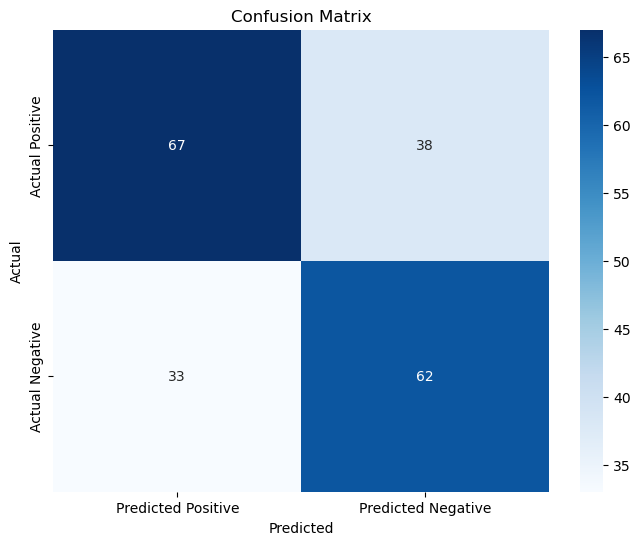

In [13]:
import seaborn as sns
import pandas as pd
# Create a matrix
conf_matrix = [
    [positive_count, false_positive_count],
    [false_negative_count, negative_count]
]

# Convert to a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Positive', 'Actual Negative'], columns=['Predicted Positive', 'Predicted Negative'])

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [7]:
import argparse

default_args = {
    'gpu': 0,
    'ptlm': 'microsoft/deberta-v3-large',
    'lmn': 'deberta',
    'data': '/Hui/R&D/NLI4CT/training_data',
    'epoch': 40,
    'eval_every': 10,
    'prompt': 2,
    'mode': 'trn',
    'from_check_point': False,
    'tokenizer_dir': None,
    'model_dir': None,
    'seed': 621
}

args = argparse.Namespace(**default_args)


path = "/Hui/R&D/NLI4CT/training_data"


train_dataset = Recorddataset(args, path, split='train')


dev_dataset = Recorddataset(args, path, split='dev')
print(dev_dataset[3])

#test_dataset = Recorddataset(args, path, split='test')


('the primary trial does not report the PFS or objective response rate of its patient cohort [SEP] Results [SEP] Outcome Measurement:,Local Control Using Ipsilateral Breast Tumor Recurrence Rates,[Not Specified],Time frame: 2 years after treatment completion,Results 1:,Arm/Group Title: Accelerated Partial Breast Brachytherapy,Arm/Group Description: Each patient will receive accelerated partial breast brachytherapy with multiple plane implant.,Patients will receive 3400 cGy delivered in 10 twice-daily fractions. Treatment is to be given over 5-7 days with a minimum of 6 hours separation between fractions.,Overall Number of Participants Analyzed: 151,Measure Type: Number,Unit of Measure: percentage of participants  .7 [SEP] ', tensor(1))
